In [51]:
#____________________________Lemurs Project____________________________________________
#__________________Nathan Le Boudec et Léa Louvion_________________________________________
#__________________________________SY09_______P2022_______________________________________

In [52]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import matplotlib as mpl
from scipy.stats import norm
from scipy import linalg
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
sns.set(rc={"figure.figsize":(20, 8)})
sns.set(style='white')
def scatterplot_pca(
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):
    """Diagramme de dispersion dans le premier plan principal.
    Permet d'afficher un diagramme de dispersion lorsque les données
    ont plus de deux dimensions. L'argument `columns` spécifie la
    liste des colonnes à utiliser pour la PCA dans le jeu de données
    `data`. Les arguments `style` et `hue` permettent de spécifier la
    forme et la couleur des marqueurs. Les arguments `pc1` et `pc2`
    permettent de sélectionner les composantes principales (par défaut
    la première et deuxième). Retourne l'objet `Axes` ainsi que le
    modèle `PCA` utilisé pour réduire la dimension.

    :param columns: Les colonnes quantitatives de `data` à utiliser
    :param hue: La colonne de coloration
    :param style: La colonne du style
    :param data: Le dataFrame Pandas
    :param pc1: La composante en abscisse
    :param pc2: La composante en ordonnée
    """
     # Select relevant columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions if needed
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **kwargs)

    return ax, pca


def plot_clustering(data, clus1, clus2=None, ax=None, **kwargs):
    """Affiche les données `data` dans le premier plan principal.

    :param data: Le dataFrame Pandas
    :param clus1: Un premier groupement
    :param clus2: Un deuxième groupement
    :param ax: Les axes sur lesquels dessiner

    """

    if ax is None:
        ax = plt.gca()

    other_kwargs = {e: kwargs.pop(e) for e in ["centers", "covars"] if e in kwargs}

    ax, pca = scatterplot_pca(data=data, hue=clus1, style=clus2, ax=ax, **kwargs)

    if "centers" in other_kwargs and "covars" in other_kwargs:
        # Hack to get colors
        # TODO use legend_out = True
        levels = [str(l) for l in np.unique(clus1)]
        hdls, labels = ax.get_legend_handles_labels()
        colors = [
            artist.get_facecolor().ravel()
            for artist, label in zip(hdls, labels)
            if label in levels
        ]
        colors = colors[: len(levels)]

        if data.shape[1] == 2:
            centers_2D = other_kwargs["centers"]
            covars_2D = other_kwargs["covars"]
        else:
            centers_2D = pca.transform(other_kwargs["centers"])
            covars_2D = [
                pca.components_ @ c @ pca.components_.T for c in other_kwargs["covars"]
            ]

        p = 0.9
        sig = norm.ppf(p ** (1 / 2))

        for covar_2D, center_2D, color in zip(covars_2D, centers_2D, colors):
            v, w = linalg.eigh(covar_2D)
            v = 2.0 * sig * np.sqrt(v)

            u = w[0] / linalg.norm(w[0])
            if u[0] == 0:
                angle = np.pi / 2
            else:
                angle = np.arctan(u[1] / u[0])
            angle = 180.0 * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(center_2D, v[0], v[1], 180.0 + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.5)
            ax.add_artist(ell)
    return ax, pca
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import MDS
from scipy.spatial.distance import cdist


def plot_Shepard(mds_model, plot=True):
    """Affiche le diagramme de Shepard et retourne un couple contenant les
    dissimilarités originales et les distances apprises par le
    modèle.
    """

    assert isinstance(mds_model, MDS)

    # Inter-distances apprises
    dist = cdist(mds_model.embedding_, mds_model.embedding_)
    idxs = np.tril_indices_from(dist, k=-1)
    dist_mds = dist[idxs]

    # Inter-distances d'origine
    dist = mds_model.dissimilarity_matrix_
    dist_orig = dist[idxs]

    dists = np.column_stack((dist_orig, dist_mds))

    if plot:
        f, ax = plt.subplots()
        range = [dists.min(), dists.max()]
        ax.plot(range, range, 'r--')
        ax.scatter(*dists.T)
        ax.set_xlabel('Dissimilarités')
        ax.set_ylabel('Distances')

    return (*dists.T,)


# Taken from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    default_kwargs = dict(leaf_font_size=10)
    default_kwargs.update(kwargs or {})
    dendrogram(linkage_matrix, **default_kwargs)

from sklearn.base import BaseEstimator


def add_decision_boundary(
    model,
    resolution=100,
    ax=None,
    levels=None,
    label=None,
    color=None,
    region=True,
    model_classes=None,
):
    """Trace une frontière et des régions de décision sur une figure existante.

    :param model: Un modèle scikit-learn ou une fonction `predict`
    :param resolution: La discrétisation en nombre de points par abcisses/ordonnées à utiliser
    :param ax: Les axes sur lesquels dessiner
    :param label: Le nom de la frontière dans la légende
    :param color: La couleur de la frontière
    :param region: Colorer les régions ou pas
    :param model_classes: Les étiquettes des classes dans le cas où `model` est une fonction

    """

    # Set axes
    if ax is None:
        ax = plt.gca()

    # Add decision boundary to legend
    color = "red" if color is None else color
    sns.lineplot(x=[0], y=[0], label=label, ax=ax, color=color, linestyle="dashed")

    # Create grid to evaluate model
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], resolution)
    yy = np.linspace(ylim[0], ylim[1], resolution)
    XX, YY = np.meshgrid(xx, yy)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    def draw_boundaries(XX, YY, Z_num, color):
        # Boundaries
        mask = np.zeros_like(Z_num, dtype=bool)
        for k in range(len(model_classes) - 1):
            mask |= Z_num == k - 1
            Z_num_mask = np.ma.array(Z_num, mask=mask)
            ax.contour(
                XX,
                YY,
                Z_num_mask,
                levels=[k + 0.5],
                linestyles="dashed",
                corner_mask=True,
                colors=[color],
                antialiased=True,
            )

    def get_regions(predict_fun, xy, shape, model_classes):
        Z_pred = predict_fun(xy).reshape(shape)
        cat2num = {cat: num for num, cat in enumerate(model_classes)}
        num2cat = {num: cat for num, cat in enumerate(model_classes)}
        vcat2num = np.vectorize(lambda x: cat2num[x])
        Z_num = vcat2num(Z_pred)
        return Z_num, num2cat

    def draw_regions(ax, model_classes, num2cat, Z_num):
        # Hack to get colors
        # TODO use legend_out = True
        slabels = [str(l) for l in model_classes]
        hdls, hlabels = ax.get_legend_handles_labels()
        hlabels_hdls = {l: h for l, h in zip(hlabels, hdls)}

        color_dict = {}
        for label in model_classes:
            if str(label) in hlabels_hdls:
                hdl = hlabels_hdls[str(label)]
                color = hdl.get_facecolor().ravel()
                color_dict[label] = color
            else:
                raise Exception("No corresponding label found for ", label)

        colors = [color_dict[num2cat[i]] for i in range(len(model_classes))]
        cmap = mpl.colors.ListedColormap(colors)

        ax.imshow(
            Z_num,
            interpolation="nearest",
            extent=ax.get_xlim() + ax.get_ylim(),
            aspect="auto",
            origin="lower",
            cmap=cmap,
            alpha=0.2,
        )

    if isinstance(model, BaseEstimator):
        if model_classes is None:
            model_classes = model.classes_

        if levels is not None:
            if len(model.classes_) != 2:
                raise Exception("Lignes de niveaux supportées avec seulement deux classes")

            # Scikit-learn model, 2 classes + levels
            Z = model.predict_proba(xy)[:, 0].reshape(XX.shape)
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            # Only 2 classes, simple contour
            ax.contour(
                XX,
                YY,
                Z,
                levels=levels,
                colors=[color]
            )

            draw_regions(ax, model_classes, num2cat, Z_num)
        else:
            # Scikit-learn model + no levels
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            draw_boundaries(XX, YY, Z_num, color)
            if region:
                draw_regions(ax, model_classes, num2cat, Z_num)
    else:
        if model_classes is None:
            raise Exception("Il faut spécifier le nom des classes")
        if levels is not None:
            raise Exception("Lignes de niveaux avec fonction non supporté")

        # Model is a predict function, no levels
        Z_num, num2cat = get_regions(model, xy, XX.shape, model_classes)
        draw_boundaries(XX, YY, Z_num, color)
        if region:
            draw_regions(ax, model_classes, num2cat, Z_num)


data = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-08-24/lemur_data.csv', encoding='cp1252')
df=pd.DataFrame(data)

In [53]:
#sns.pairplot(df)

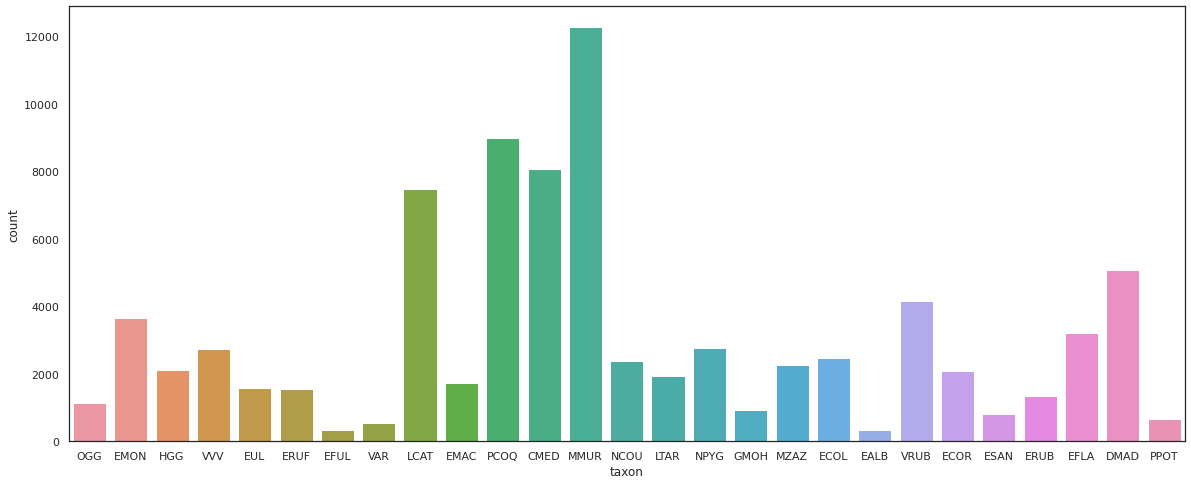

In [54]:
sns.set(rc={"figure.figsize":(20, 8)})
sns.set(style='white')
sns.countplot(x=df['taxon'])
#nombre de mesures moyennes par espèce

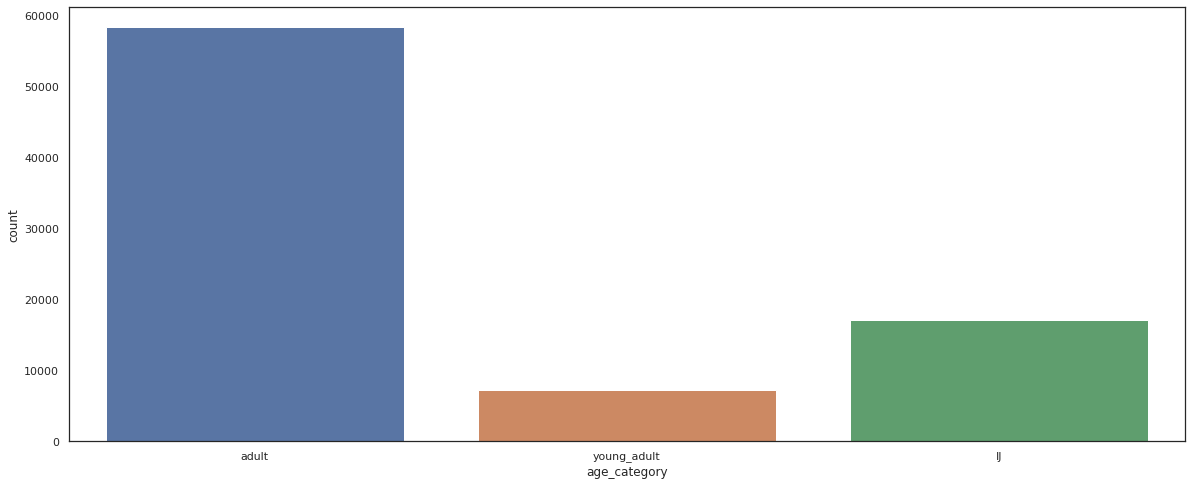

In [55]:
sns.countplot(x=df['age_category'])

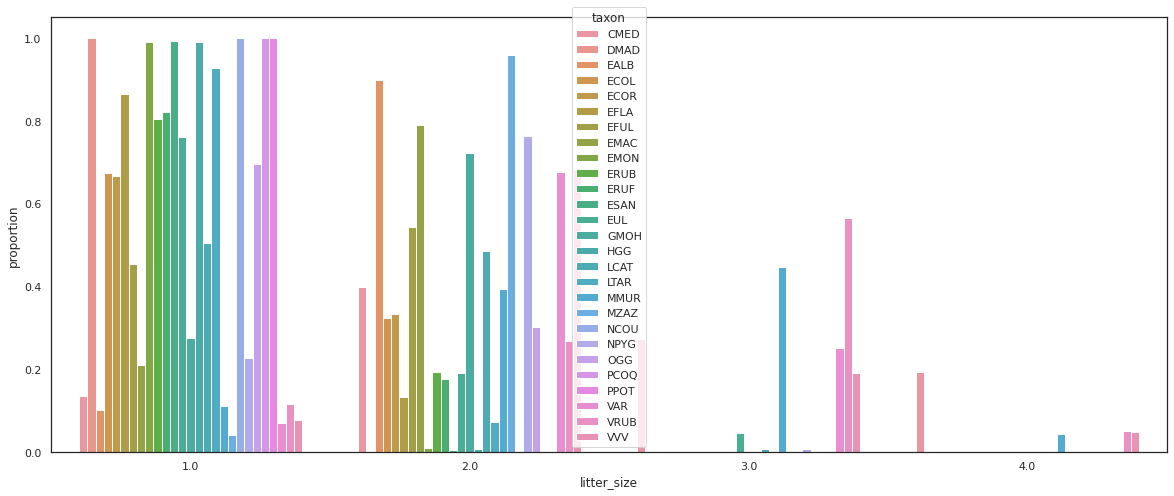

In [56]:
x, y, hue = "litter_size", "proportion", "taxon"

(df[x].groupby(df[hue]).value_counts(normalize=True).rename(y).reset_index().pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

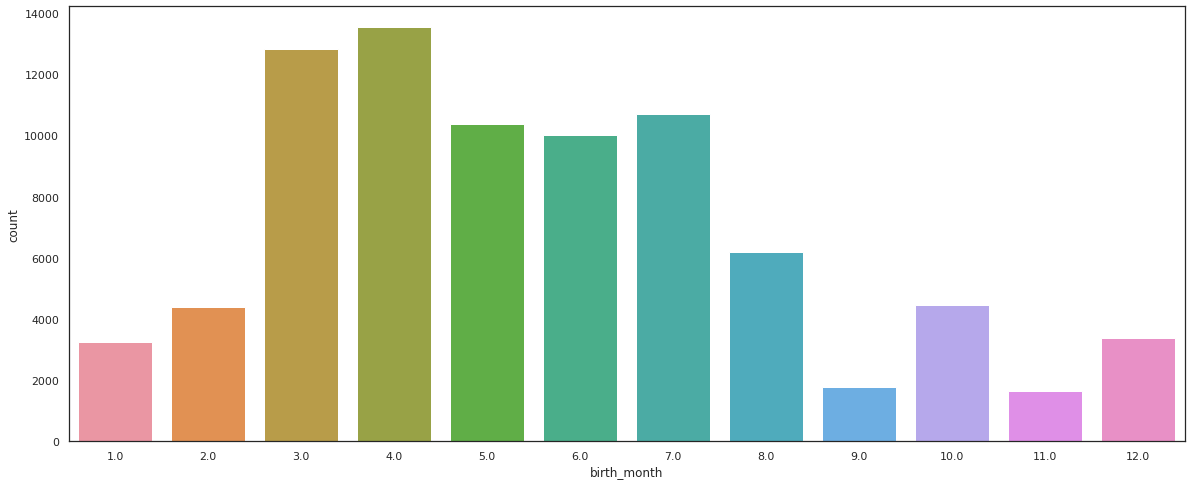

In [57]:
sns.countplot(df['birth_month'])

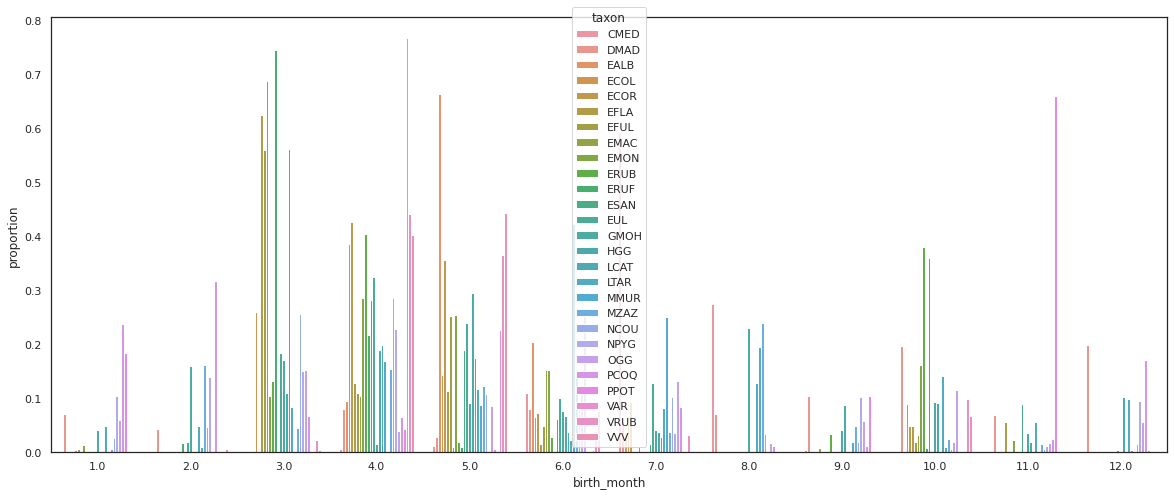

In [58]:
x, y, hue = "birth_month", "proportion", "taxon"
(df[x].groupby(df[hue]).value_counts(normalize=True).rename(y).reset_index().pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

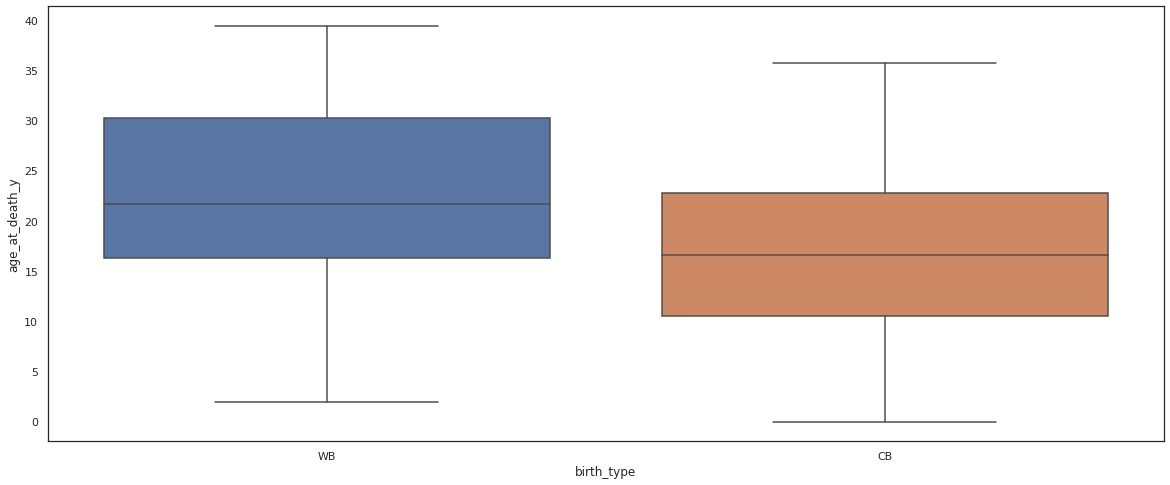

In [59]:
df_sauv_capt = df.loc[df['birth_type']=='WB']
df_sauv_capt = df_sauv_capt.append(df.loc[df['birth_type']=='CB'])
sns.boxplot(x="birth_type", y="age_at_death_y", data=df_sauv_capt)

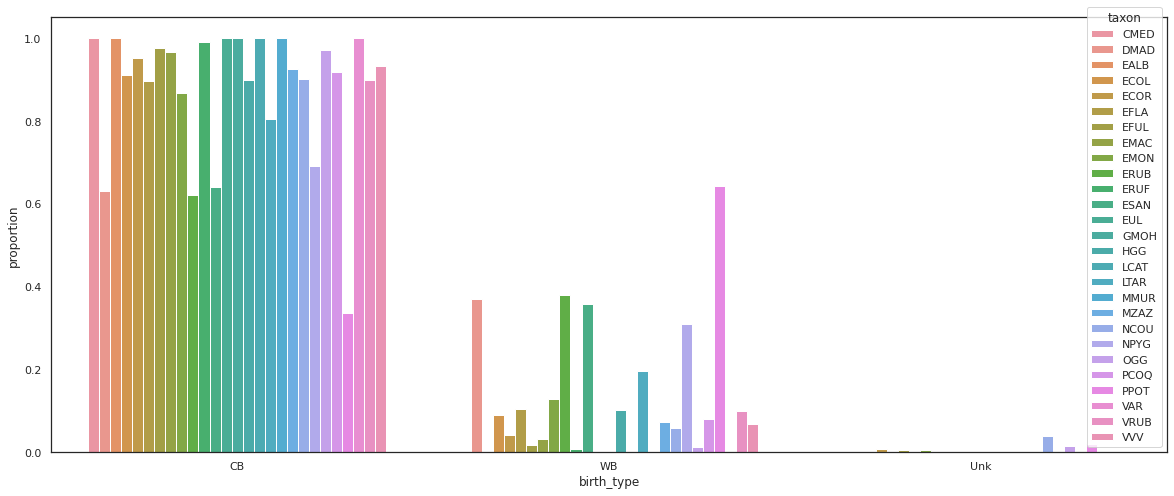

In [60]:
x, y, hue = "birth_type", "proportion", "taxon"

(df[x].groupby(df[hue]).value_counts(normalize=True).rename(y).reset_index().pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

In [61]:
df2=pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-08-24/lemur_data.csv', encoding= 'unicode_escape')
df2['idx'] = df2.groupby('dlc_id').cumcount()
df2_mod=df2.pivot(index='dlc_id',columns='idx')
new=df2_mod.xs(0,level='idx',axis=1) #pour sélectionner juste la première colonne
#cas de multiindexe
new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2270 entries, 5 to 8039
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   taxon                          2270 non-null   object 
 1   hybrid                         2270 non-null   object 
 2   sex                            2270 non-null   object 
 3   name                           2270 non-null   object 
 4   current_resident               2270 non-null   object 
 5   stud_book                      2053 non-null   object 
 6   dob                            2269 non-null   object 
 7   birth_month                    2269 non-null   float64
 8   estimated_dob                  184 non-null    object 
 9   birth_type                     2270 non-null   object 
 10  birth_institution              2270 non-null   object 
 11  litter_size                    1897 non-null   float64
 12  expected_gestation             2270 non-null   f

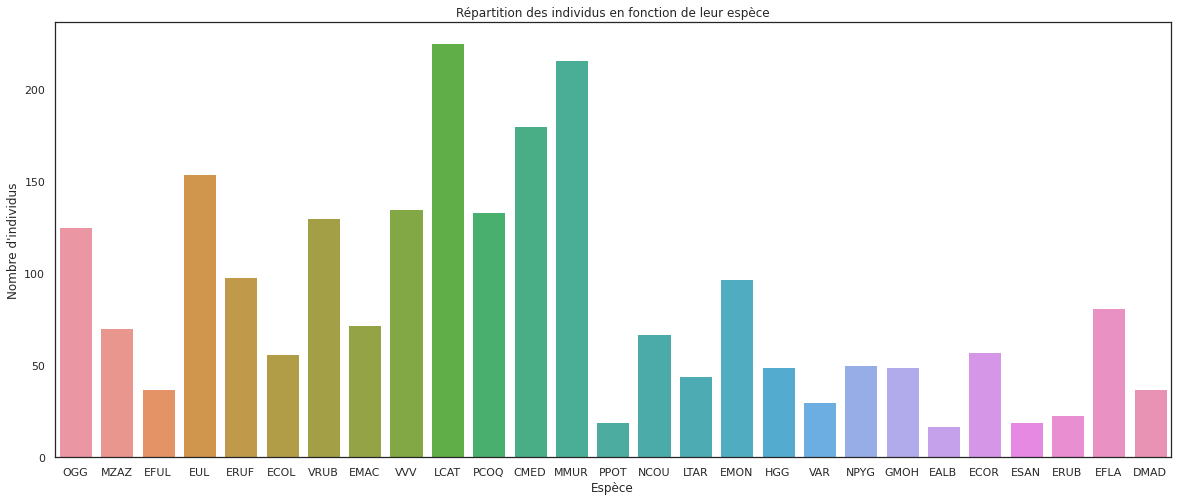

In [62]:
new_species = pd.crosstab(index=new["taxon"], columns="count")
new_species #Tableau faisant un comptage des différentes appartenances à un taxon

sns.countplot(x=new['taxon'])
plt.ylabel("Nombre d'individus")
plt.xlabel("Espèce")
plt.title("Répartition des individus en fonction de leur espèce")
plt.show()

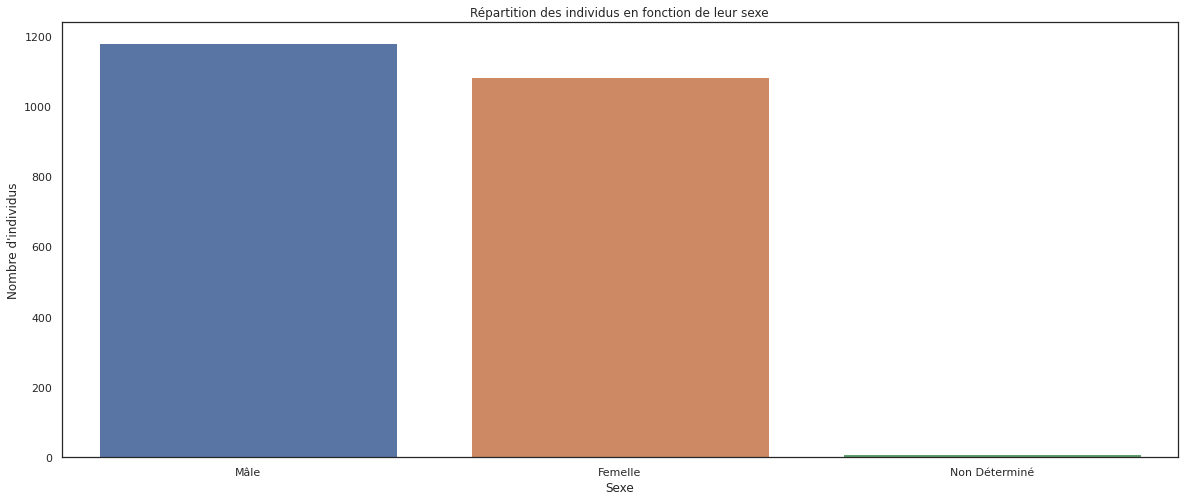

In [63]:
s=new['sex']
s=s.rename({'M': 'Mâle', 'F': 'Femelle','ND':'Non Déterminé'})
new['sex'] = new['sex'].map({'M': 'Mâle', 'F': 'Femelle','ND':'Non Déterminé'},
                             na_action=None)
sns.countplot(x=new['sex'])
plt.ylabel("Nombre d'individus")
plt.xlabel("Sexe")
plt.title("Répartition des individus en fonction de leur sexe")
plt.show()

Text(0.5, 1.0, "Répartition des individus en fonction de s'ils sont hybrides ou non")

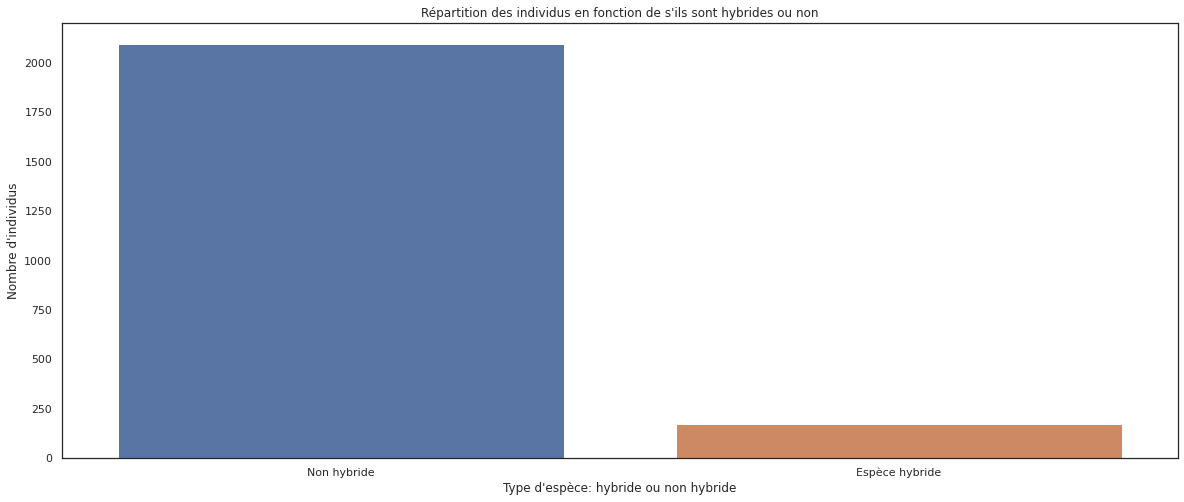

In [64]:
new['hybrid'] = new['hybrid'].map({'N':'Non hybride',
                             'Sp':'Espèce hybride'},
                             na_action=None)
sns.countplot(x=new['hybrid'])
plt.ylabel("Nombre d'individus")
plt.xlabel("Type d'espèce: hybride ou non hybride")
plt.title("Répartition des individus en fonction de s'ils sont hybrides ou non")

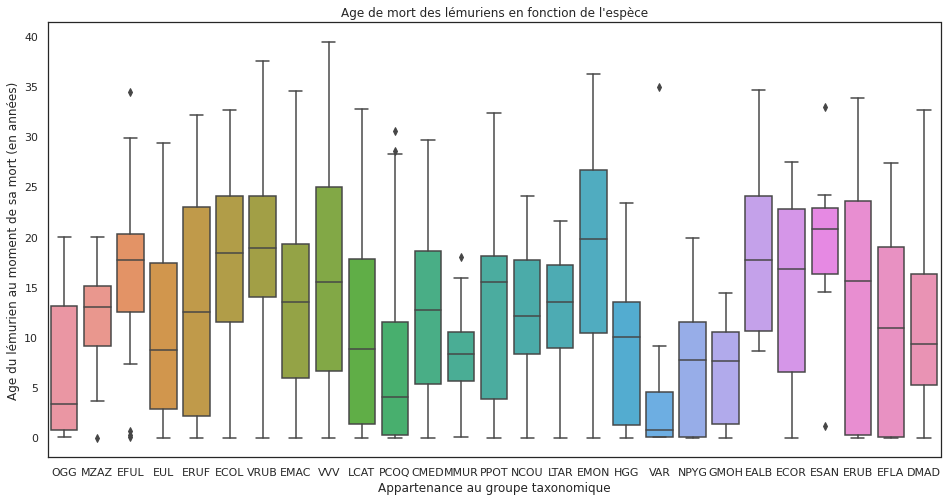

In [65]:
sns.set(rc={"figure.figsize":(16, 8)}) #age max taxons
sns.set(style='white')
sns.boxplot(x="taxon",y="age_at_death_y",data=new) #modifier affichage pour avoir plus beaux graphiques
plt.ylabel("Age du lémurien au moment de sa mort (en années)")
plt.xlabel("Appartenance au groupe taxonomique")
plt.title("Age de mort des lémuriens en fonction de l'espèce")
plt.show()

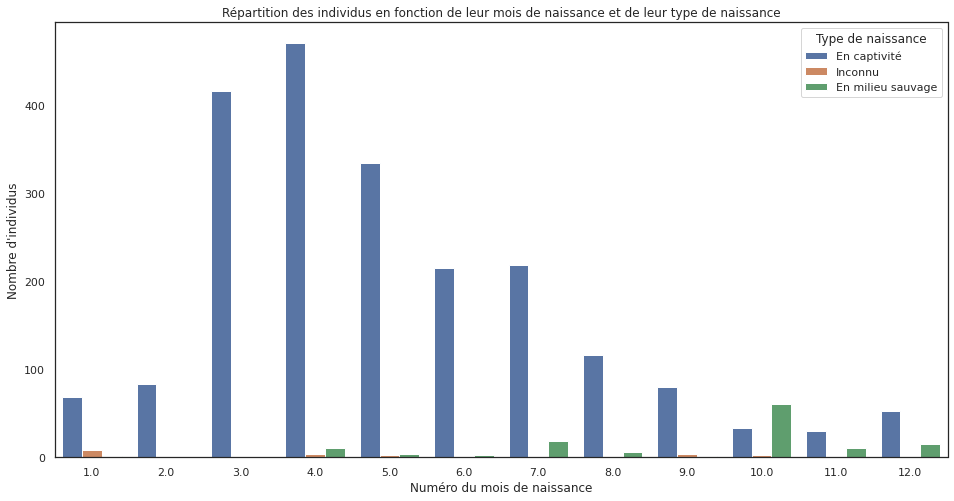

In [66]:
new=new.rename(columns={"birth_type": "Type de naissance"})
new['Type de naissance'] = new['Type de naissance'].map({'CB':'En captivité',
                             'Unk':'Inconnu',
                             'WB':'En milieu sauvage'},
                             na_action=None)
sns.countplot(x=new['birth_month'], hue=new['Type de naissance'])
plt.ylabel("Nombre d'individus")
plt.xlabel("Numéro du mois de naissance")
plt.title("Répartition des individus en fonction de leur mois de naissance et de leur type de naissance")
plt.show()

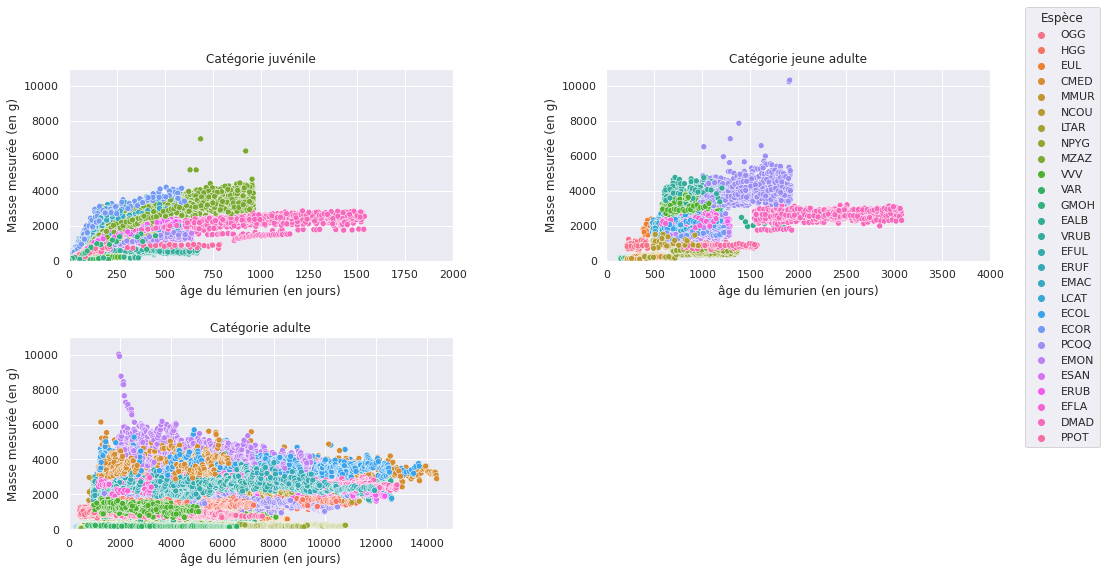

In [67]:
#subplot 
df2_juvenile = df2.loc[df2.age_category=="IJ"] #tableau que de juvéniles
df2_juvenile['idx'] = df2_juvenile.groupby('dlc_id').cumcount()
df2_juvenile_mod=df2_juvenile.pivot(index='dlc_id',columns='idx')
new_juvenile=df2_juvenile_mod.xs(0,level='idx',axis=1) #pour sélectionner juste la première colonne
df2_adult = df2.loc[df2.age_category=="adult"] #tableau que d'adultes
df2_adult['idx'] = df2_adult.groupby('dlc_id').cumcount()
df2_adult_mod=df2_adult.pivot(index='dlc_id',columns='idx')
new_adult=df2_adult_mod.xs(0,level='idx',axis=1) #pour sélectionner juste la première colonne
df2_jeune_adulte = df2.loc[df2.age_category=="young_adult"] #tableau que de jeunes adultes
df2_jeune_adulte['idx'] = df2_jeune_adulte.groupby('dlc_id').cumcount()
df2_jeune_adulte_mod=df2_jeune_adulte.pivot(index='dlc_id',columns='idx')
new_jeune=df2_jeune_adulte_mod.xs(0,level='idx',axis=1) #pour sélectionner juste la première colonne
sns.set(rc={"figure.figsize":(16, 8)}) 
plt.subplot(221,xlim=(0,2000),ylim=(0,11000),title="Catégorie juvénile",xlabel="âge du lémurien (en jours)", ylabel="Masse mesurée (en g)")
sns.scatterplot(x=df2_juvenile['age_at_wt_d'], y=df2_juvenile['weight_g'],hue=df2_juvenile['taxon'],data=df2_juvenile,legend=False)
plt.subplot(222,xlim=(0,4000),ylim=(0,11000),title="Catégorie jeune adulte",xlabel="âge du lémurien (en jours)", ylabel="Masse mesurée (en g)")
ax=sns.scatterplot(x=df2_jeune_adulte['age_at_wt_d'], y=df2_jeune_adulte['weight_g'],hue=df2_jeune_adulte['taxon'],data=df2_jeune_adulte)
sns.move_legend(
    ax, "lower right",bbox_to_anchor=(1.3, -1),
    title="Espèce")
plt.subplot(223,xlim=(0,15000),ylim=(0,11000),title="Catégorie adulte",xlabel="âge du lémurien (en jours)", ylabel="Masse mesurée (en g)")
sns.scatterplot(x=df2_adult['age_at_wt_d'], y=df2_adult['weight_g'],hue=df2_adult['taxon'],data=df2_adult,legend=False)
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

plt.show()

Text(0.5, 1.0, 'Répartition des individus en fonction de leur année de naissance et de leur type de naissance')

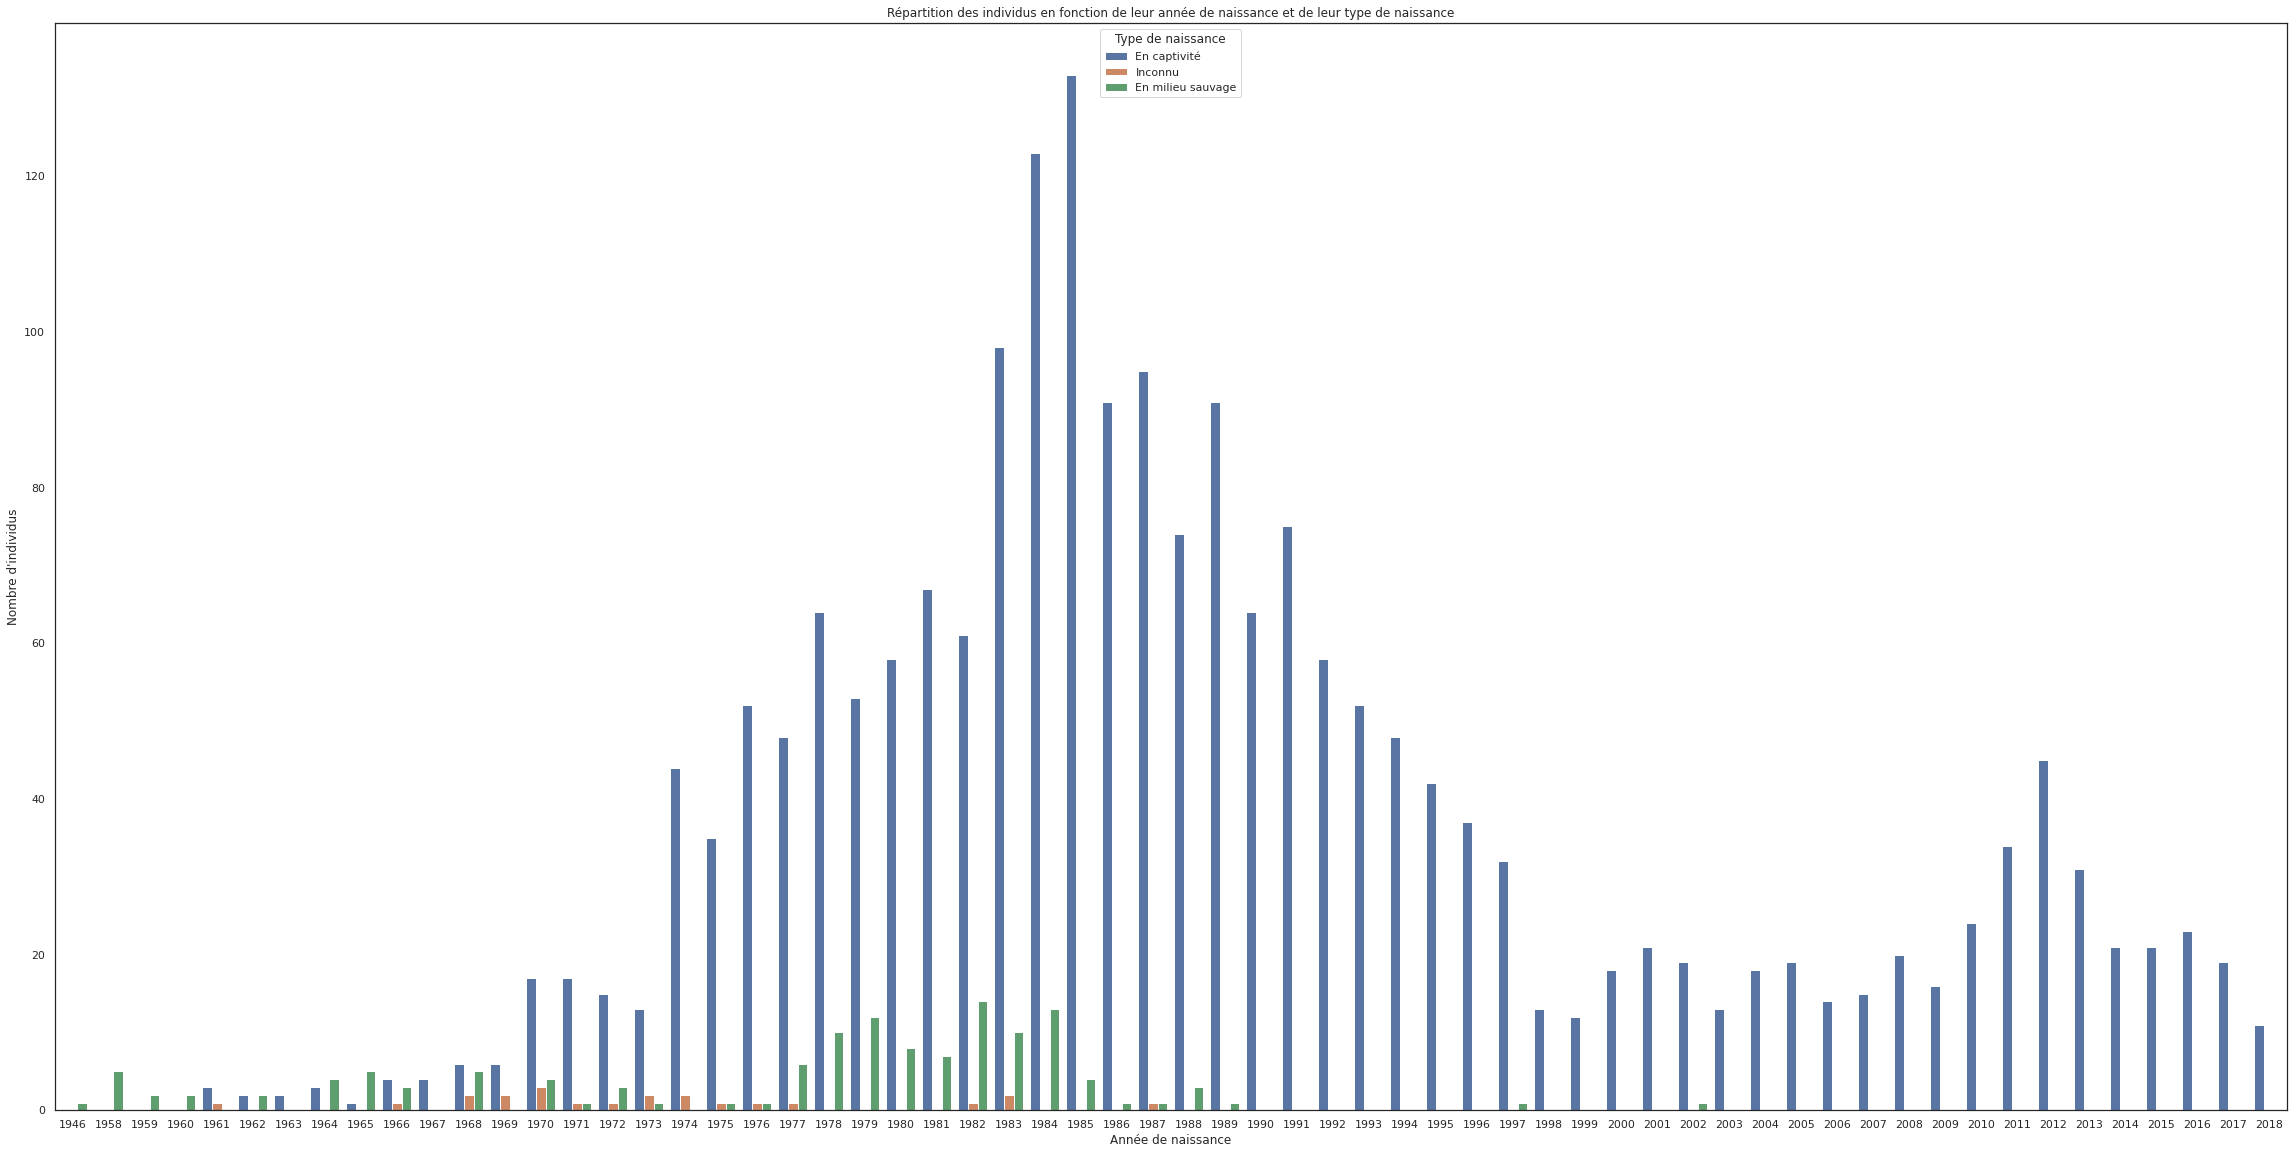

In [68]:
df_annee = new.assign(dob=new.dob.str[:4])
df_annee=df_annee.rename(columns={"dob": "year_birth"})
df_annee["year_birth"] = pd.Categorical(df_annee["year_birth"], ordered=True) #remettre dans l'ordre les années
sns.set(rc={"figure.figsize":(40, 20)}) 
sns.set(style='white')
sns.countplot(df_annee['year_birth'],hue=df_annee['Type de naissance'])

#le plus de naissance dans les années 1980, naissance, établissement en 1966
plt.ylabel("Nombre d'individus")
plt.xlabel("Année de naissance")
plt.title("Répartition des individus en fonction de leur année de naissance et de leur type de naissance")

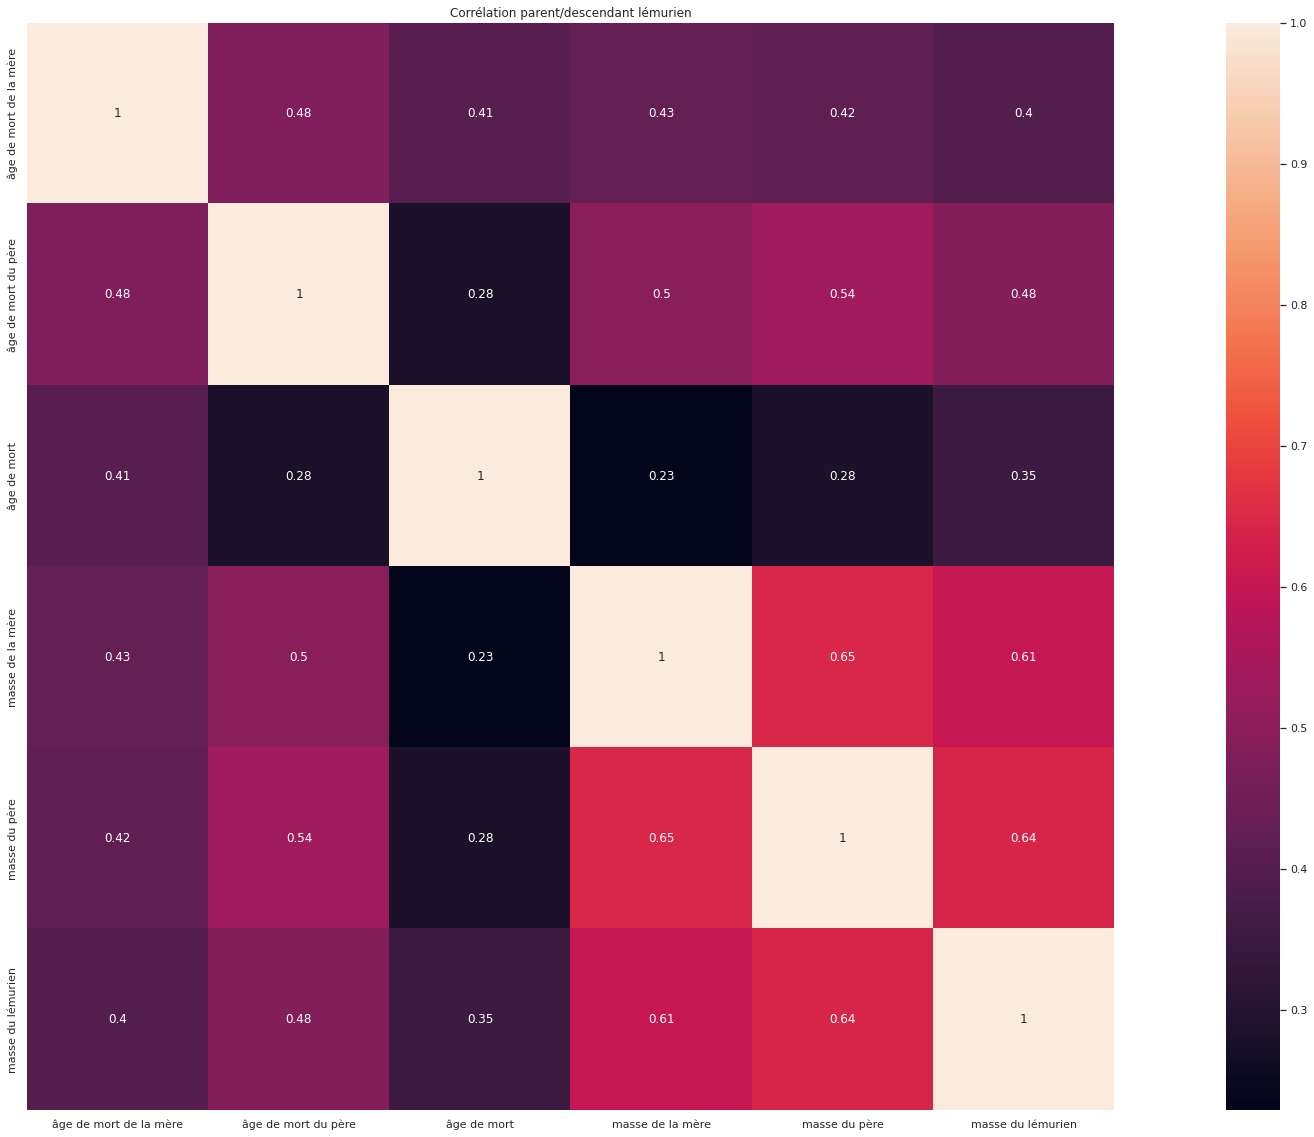

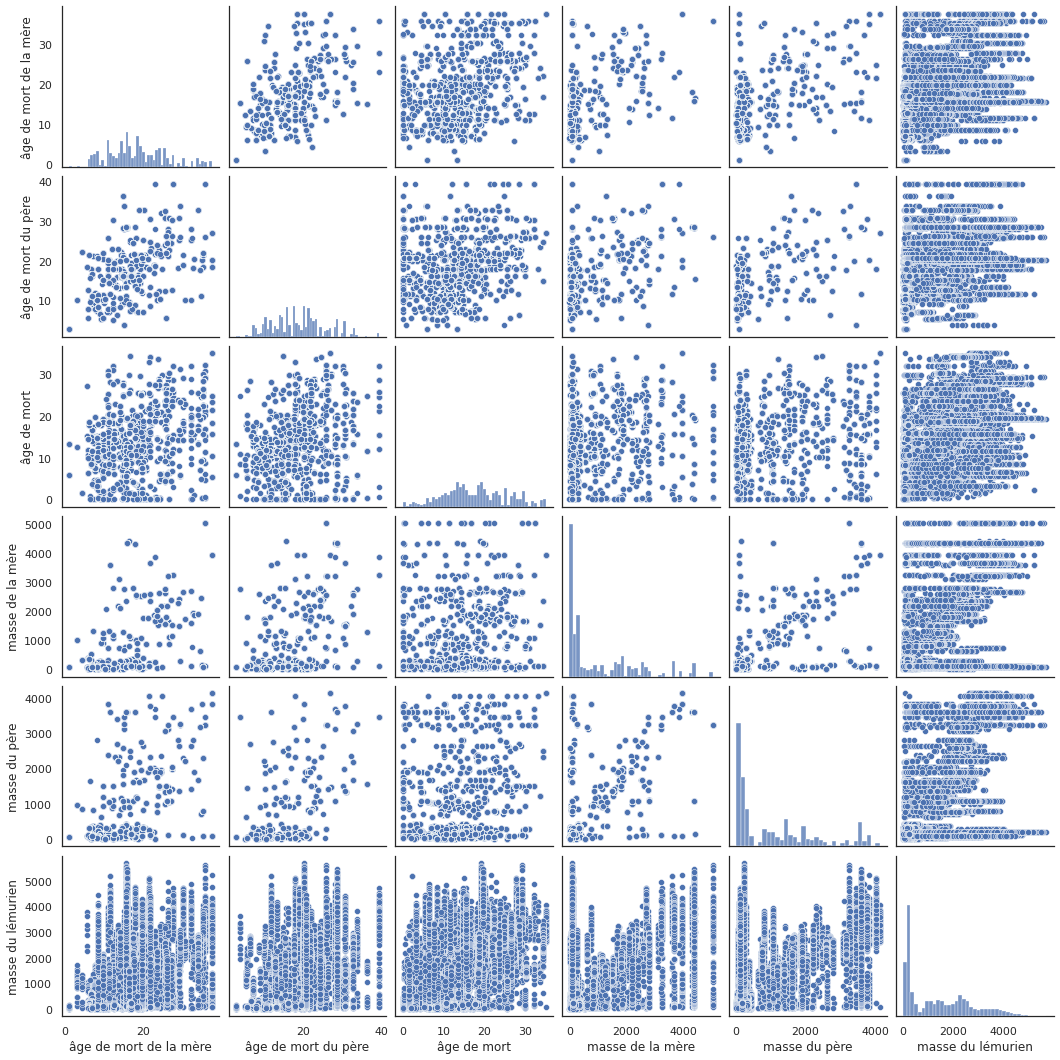

In [69]:
df_parent=pd.read_csv("https://raw.githubusercontent.com/Nathpreums/Lemur/main/lemur_weight_parents.csv")
df_par_reduit=pd.DataFrame()
df_par_reduit['dam_age_death']=df_parent["dam_age_death"]
df_par_reduit['sire_age_death']=df_parent["sire_age_death"]
df_par_reduit['age_at_death_y']=df_parent["age_at_death_y"]
df_par_reduit['dam_weight']=df_parent["dam_weight"]
df_par_reduit['sire_weight']=df_parent["sire_weight"]
df_par_reduit['weight_g']=df_parent["weight_g"]
index_with_nan = df_par_reduit.index[df_par_reduit.isnull().any(axis=1)]
df_par_reduit.drop(index_with_nan,0, inplace=True)
#on enlève les lignes où c'est à 0. 
df_par_reduit=df_par_reduit.rename(columns={"age_at_death_y": "âge de mort","dam_age_death":"âge de mort de la mère",
                        "sire_age_death":"âge de mort du père","dam_weight":"masse de la mère","sire_weight":"masse du père",
                        "weight_g":"masse du lémurien"})
df_par_reduit = df_par_reduit[df_par_reduit["âge de mort"] != 0]
df_par_reduit = df_par_reduit[df_par_reduit["âge de mort du père"] != 0]
df_par_reduit = df_par_reduit[df_par_reduit["âge de mort de la mère"]!= 0]
df_par_reduit
corr = df_par_reduit.corr()

sns.heatmap(corr,square=True,annot=True)
plt.title("Corrélation parent/descendant lémurien")
plt.show()

sns.pairplot(df_par_reduit)
plt.show()
#en revanche sur le pairplot on voit assez bien qu'il y a une faible corrélation
#corrélation assez faible entre age des parents et age progeniture, prévisible quand on voit la tête de la distribution

# en revanche on voit que les caractéristiques des poids sont assez corrélées
#entre 0,6 et 0,7

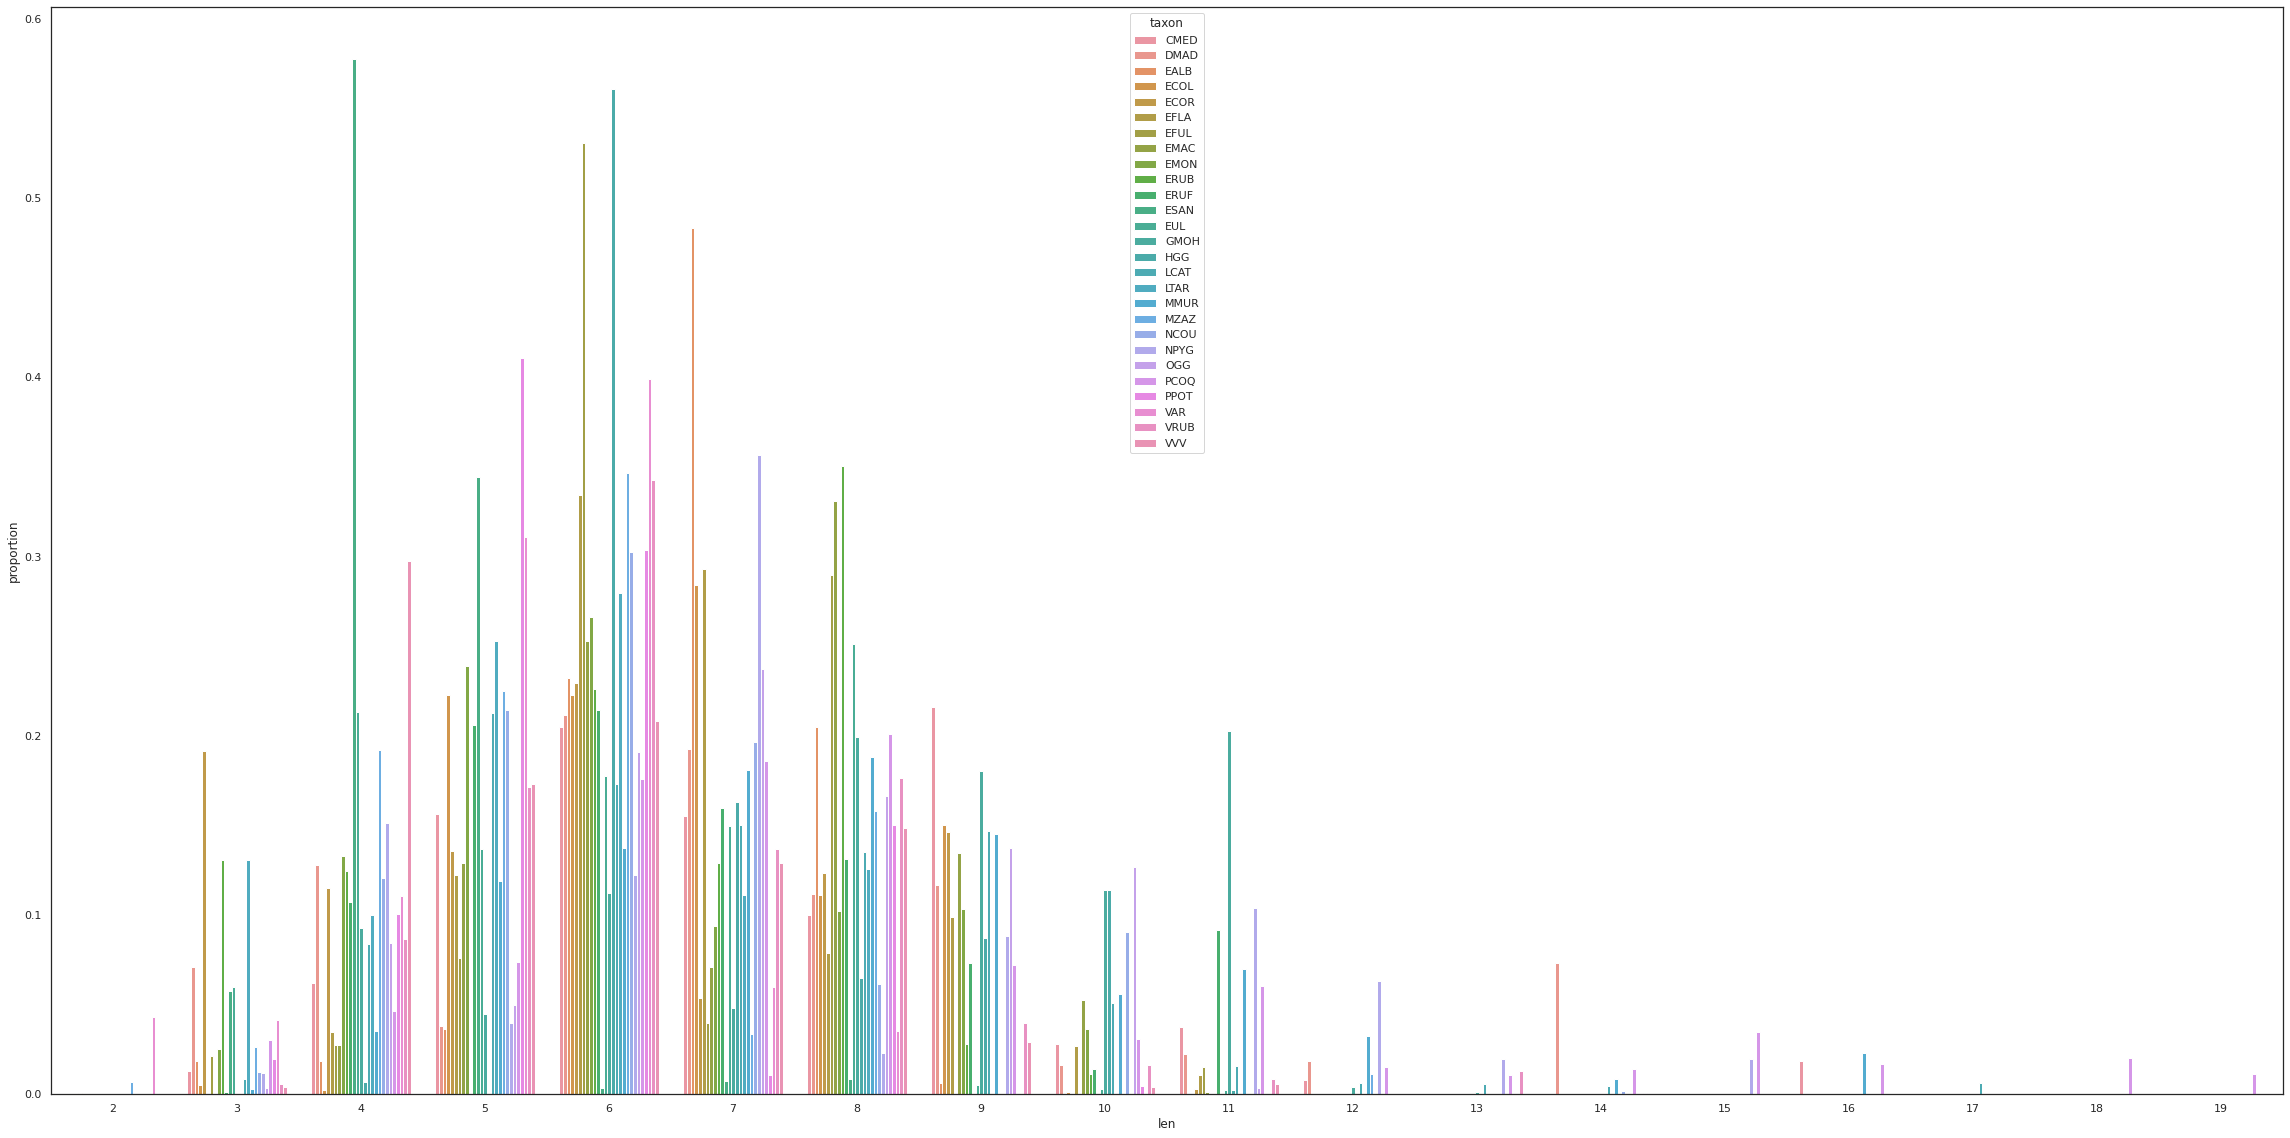

In [70]:
list_len_name=[]
list_taxx=[]
for i in range(len(df)):
    list_len_name.append(len(df.name[i]))
    list_taxx.append(df.taxon[i])
list_taxx

name=pd.DataFrame()
name["len"]=list_len_name
name['taxon']=list_taxx

x, y, hue = "len", "proportion", "taxon"

(name[x].groupby(name[hue]).value_counts(normalize=True).rename(y).reset_index().pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

In [71]:
map_data = pd.read_csv('https://raw.githubusercontent.com/Nathpreums/Lemur/main/map.csv')
map_df = pd.DataFrame(map_data)
del(map_df['Unnamed: 0'])
map_df
#https://github.com/python-visualization/folium/issues/340
import folium
import sys
sys.path.insert(0,'folium')
import folium.plugins
from folium.features import *

class DivIcon(MacroElement):
    def __init__(self, html='', size=(2,2), anchor=(0,0), style=''):
        """TODO : docstring here"""
        super(DivIcon, self).__init__()
        self._name = 'DivIcon'
        self.size = size
        self.anchor = anchor
        self.html = html
        self.style = style
        self._template = Template(u"""
            {% macro header(this, kwargs) %}
              <style>
                .{{this.get_name()}} {
                    {{this.style}}
                    }
              </style>
            {% endmacro %}
            {% macro script(this, kwargs) %}
                var {{this.get_name()}} = L.divIcon({
                    className: '{{this.get_name()}}',
                    iconSize: [{{ this.size[0] }},{{ this.size[1] }}],
                    iconAnchor: [{{ this.anchor[0] }},{{ this.anchor[1] }}],
                    html : "{{this.html}}",
                    });
                {{this._parent.get_name()}}.setIcon({{this.get_name()}});
            {% endmacro %}
            """)

mapObj2 = folium.Map(location=[10, 10], zoom_start=2)

for i in range(len(map_df)):
    folium.Circle(location=[map_df.iloc[i]['lat'],map_df.iloc[i]['lon']],radius=int(sqrt(map_df.iloc[i]['count'])*50000),fill_color='blue',fill_opacity = 0.5).add_to(mapObj2)

folium.map.Marker(
    [-38, 5],
    icon=DivIcon(
        size=(0,0),
        anchor=(0,0),
        html='Emplacement inconnu',
        style="""
            font-size:12px;
            background-color: transparent;
            border-color: transparent;
            text-align: right;
            """)).add_to(mapObj2)

folium.map.Marker(
    [-48, 5],
    icon=DivIcon(
        size=(0,0),
        anchor=(0,0),
        html='Grand public',
        style="""
            font-size:12px;
            background-color: transparent;
            border-color: transparent;
            text-align: right;
            """)).add_to(mapObj2)

#mapObj2.save('C:/Users/lebou/Downloads/output.html')
mapObj2

Il y a 2270 lémuriens différents.


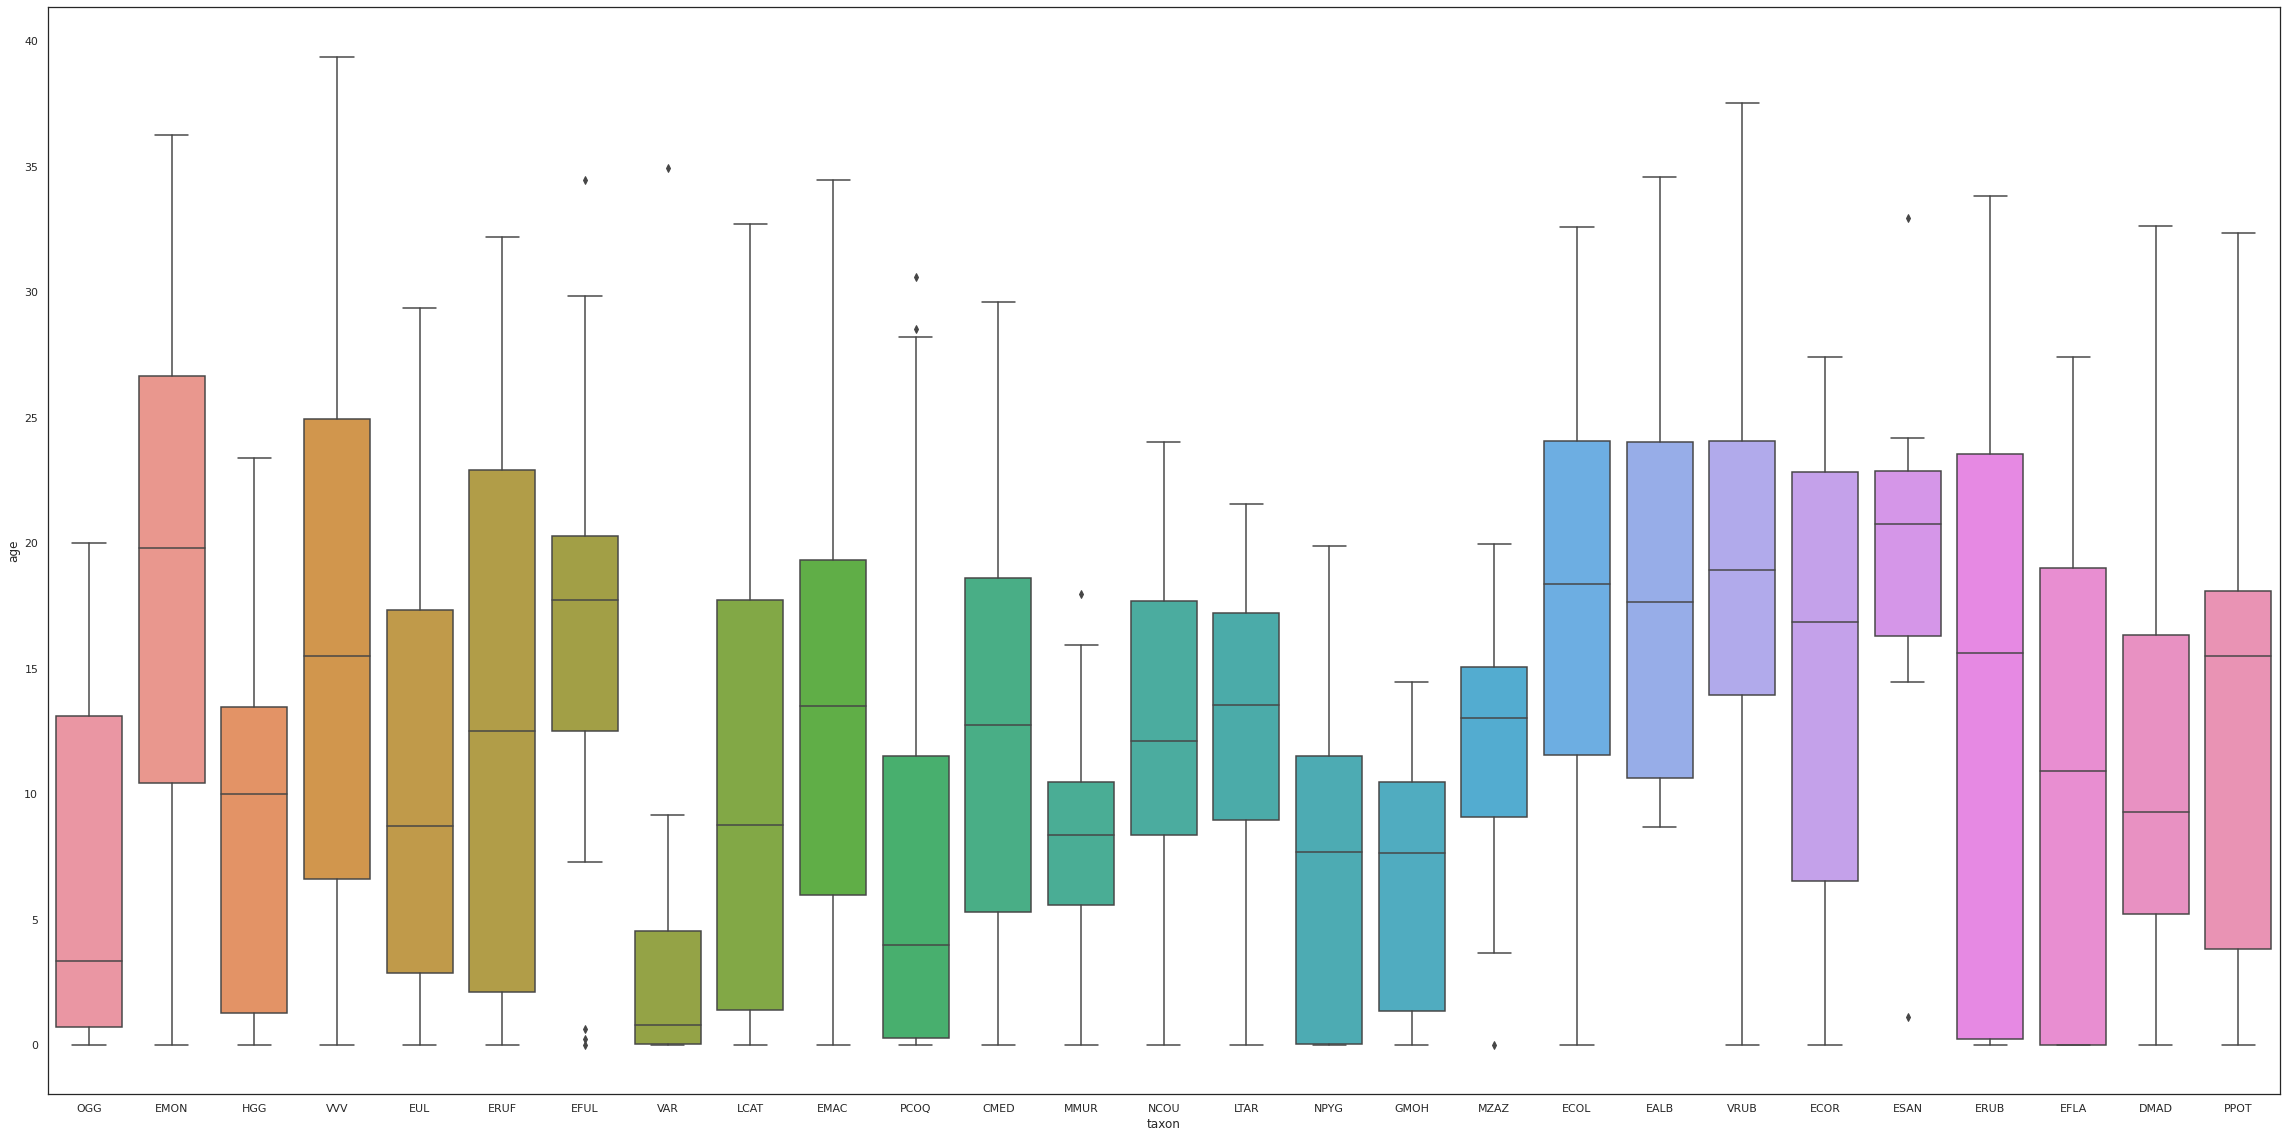

In [72]:
list_id=[]
for i in range(len(df)):
    list_id.append(df.dlc_id[i])
resultantList = []
 
for element in list_id:
    if element not in resultantList:
        resultantList.append(element)

print("Il y a",len(resultantList),"lémuriens différents.")

list_age=[]
list_taxon=[]

for i in resultantList:
    di=df.loc[df['dlc_id']==i]['age_at_death_y']
    list_age.append(di.iloc[0])
    di=df.loc[df['dlc_id']==i]['taxon']
    list_taxon.append(di.iloc[0])
list_age
d=pd.DataFrame()
d['age']=list_age
d['taxon']=list_taxon
index_with_nan = d.index[d.isnull().any(axis=1)]
d.drop(index_with_nan,0, inplace=True)
sns.boxplot(x="taxon", y="age", data=d)

Text(0.5, 1.0, 'Masse des lémuriens en fonction du jour de la pesée et de leur sexe')

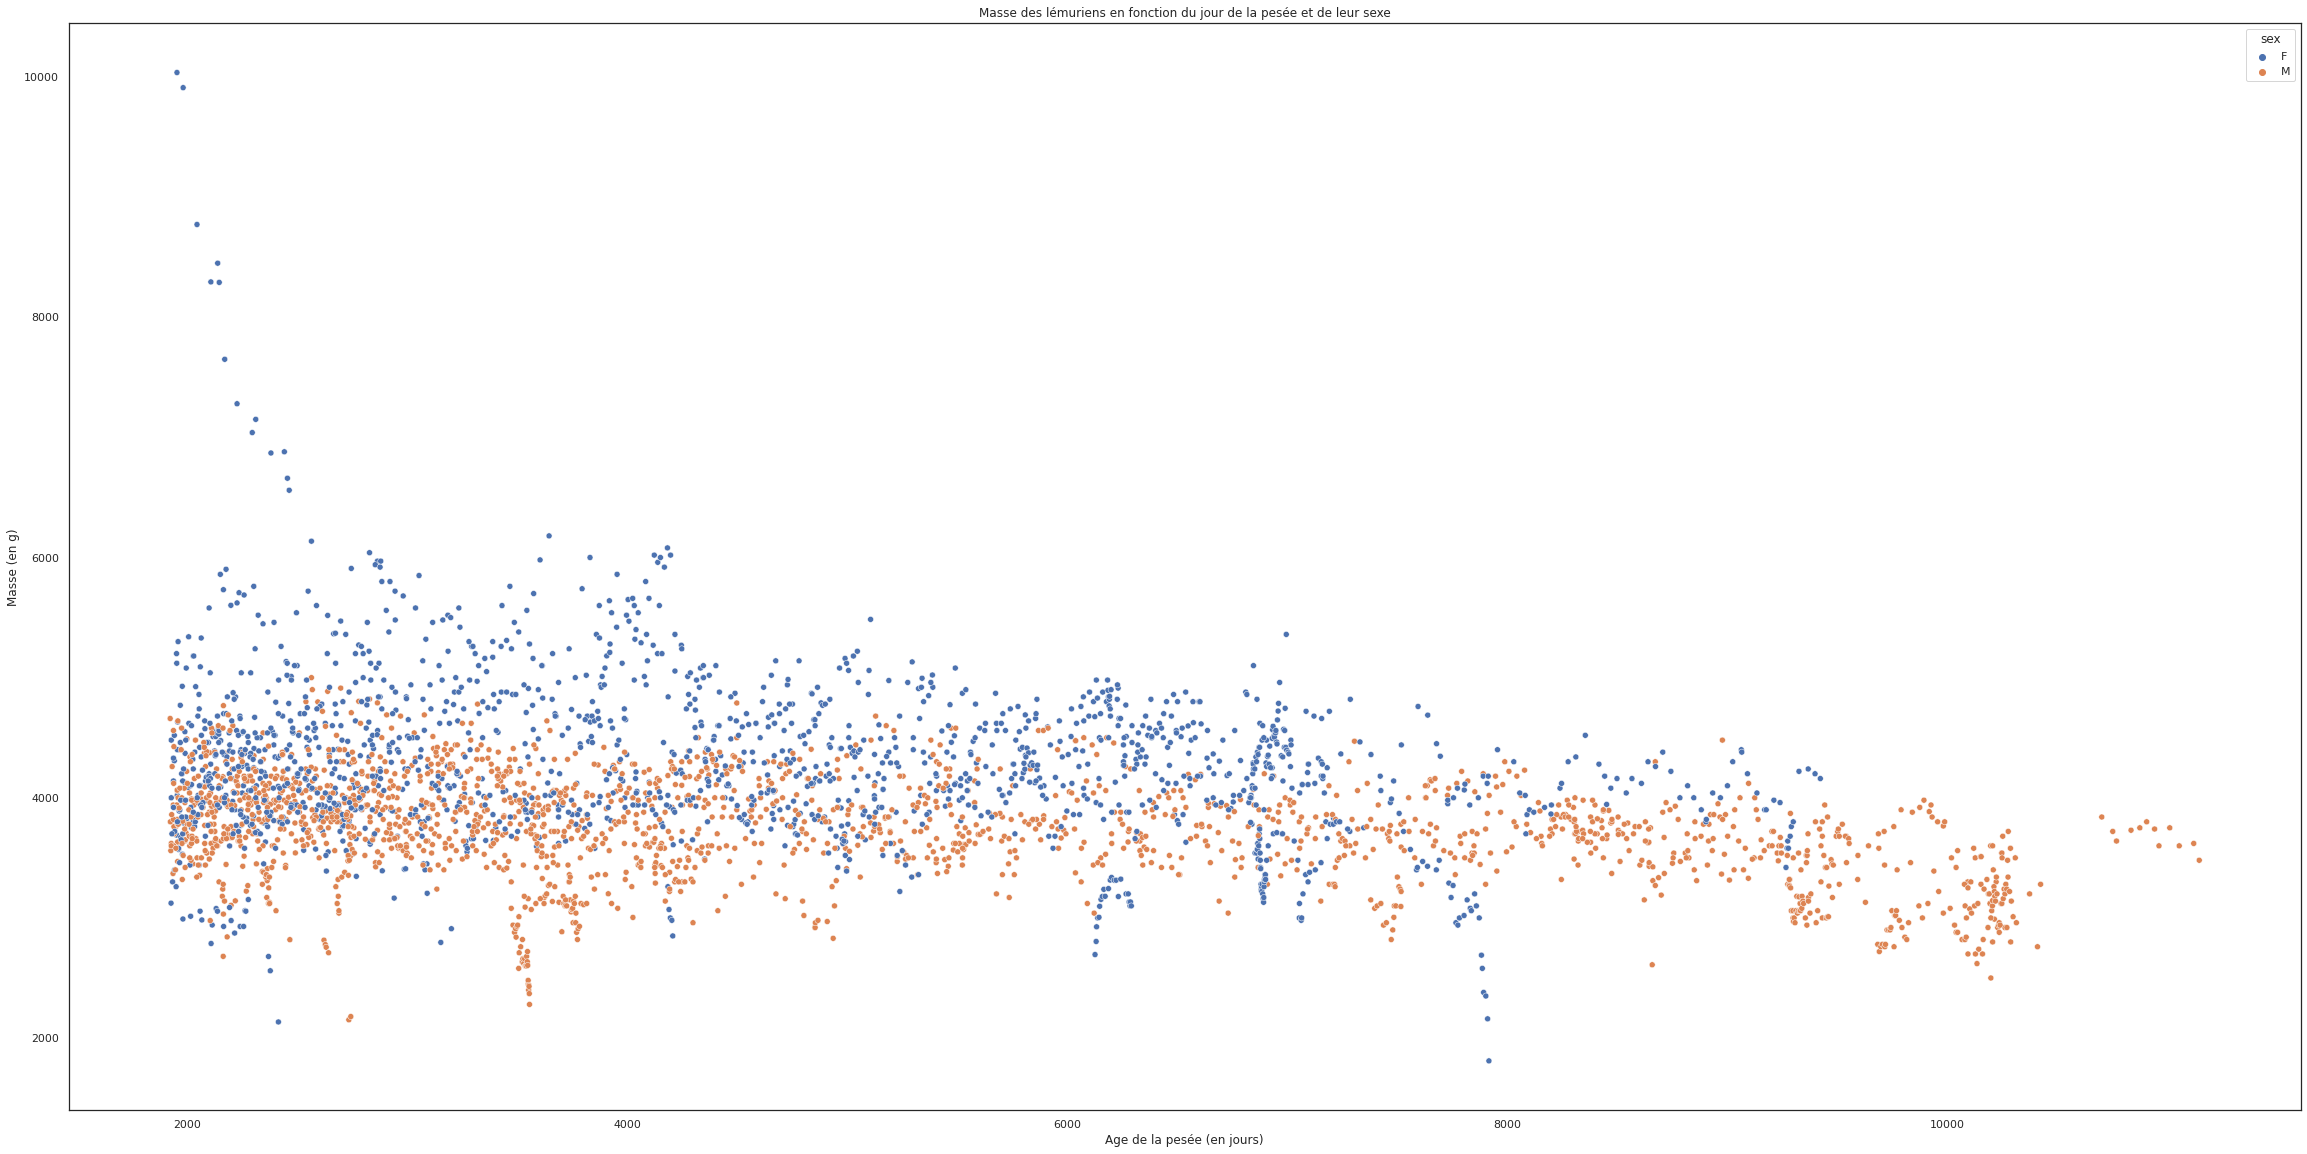

In [73]:
df_adult=df.loc[df['age_category']=='adult']
df_adult_PCOQ=df_adult.loc[df_adult['taxon']=='PCOQ']
sns.scatterplot(x=df_adult_PCOQ['age_at_wt_d'],y=df_adult_PCOQ['weight_g'],hue=df_adult_PCOQ['sex'],data=df_adult_PCOQ)
plt.ylabel("Masse (en g)")
plt.xlabel("Age de la pesée (en jours)")
plt.title("Masse des lémuriens en fonction du jour de la pesée et de leur sexe")
#on remarque que pour certaines espèces de lémuriens, les femelles ont une masse plus grande

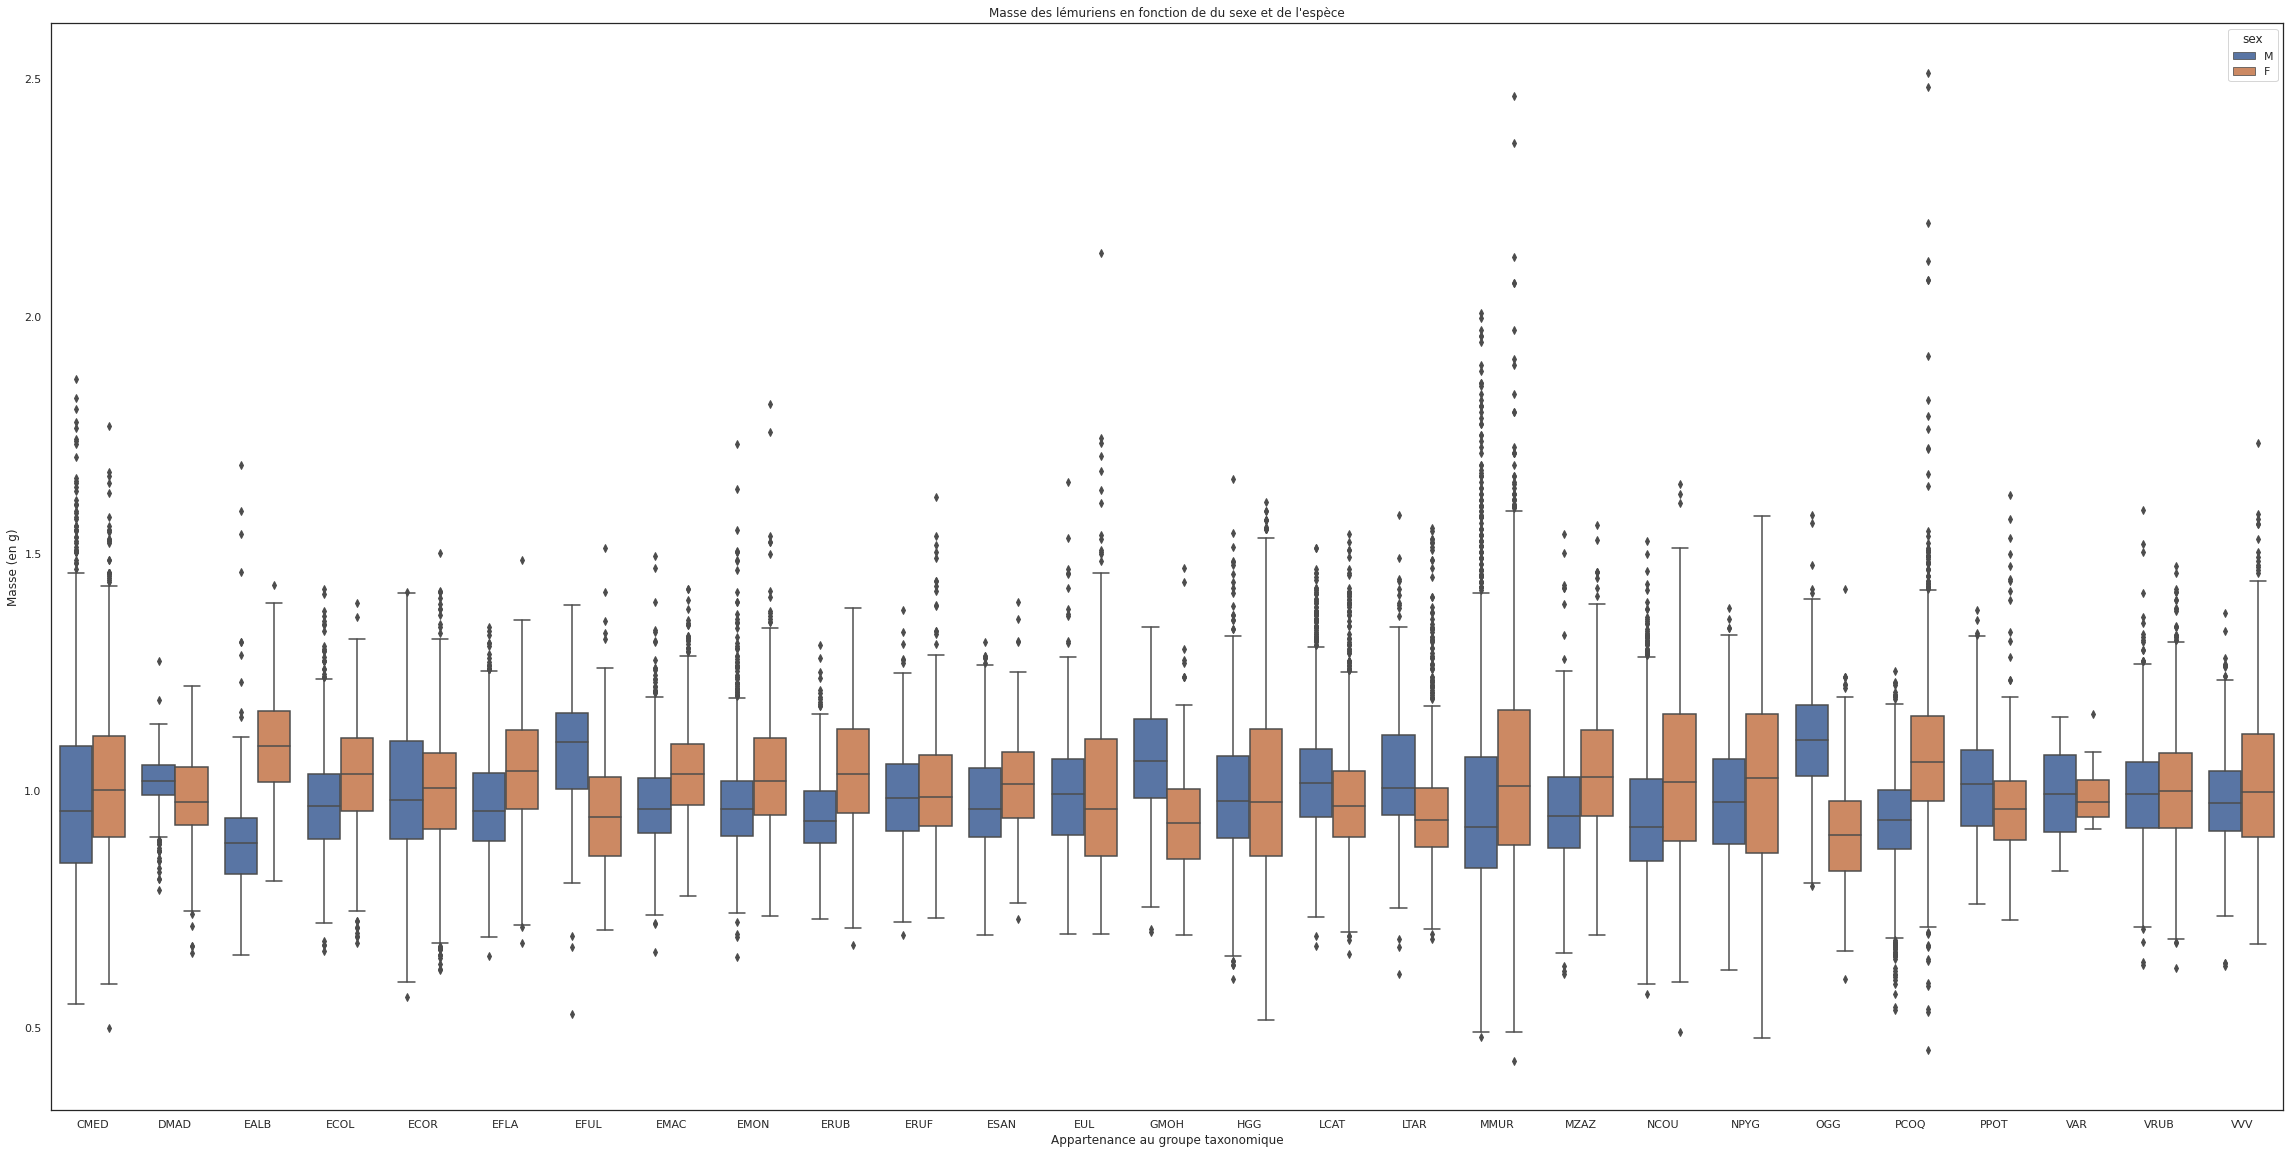

In [74]:
#https://www.sciencesetavenir.fr/animaux/les-femelles-lemuriens-sont-dominantes-grace-a-la-testosterone_100800
df_adult_EFLA=df_adult.loc[df_adult['taxon']=='EFLA']
df_adult_EMON=df_adult.loc[df_adult['taxon']=='EMON']
df_adult_EMON['weight_g']=df_adult_EMON['weight_g']/df_adult_EMON['weight_g'].mean()
df_adult_EFLA['weight_g']=df_adult_EFLA['weight_g']/df_adult_EFLA['weight_g'].mean()
df_adult_EALB=df_adult.loc[df_adult['taxon']=='EALB']
df_adult_EALB['weight_g']=df_adult_EALB['weight_g']/df_adult_EALB['weight_g'].mean()
df_adult_CMED=df_adult.loc[df_adult['taxon']=='CMED']
df_adult_CMED['weight_g']=df_adult_CMED['weight_g']/df_adult_CMED['weight_g'].mean()
df_adult_DMAD=df_adult.loc[df_adult['taxon']=='DMAD']
df_adult_DMAD['weight_g']=df_adult_DMAD['weight_g']/df_adult_DMAD['weight_g'].mean()
df_adult_ECOL=df_adult.loc[df_adult['taxon']=='ECOL']
df_adult_ECOL['weight_g']=df_adult_ECOL['weight_g']/df_adult_ECOL['weight_g'].mean()
df_adult_ECOR=df_adult.loc[df_adult['taxon']=='ECOR']
df_adult_ECOR['weight_g']=df_adult_ECOR['weight_g']/df_adult_ECOR['weight_g'].mean()
df_adult_EFUL=df_adult.loc[df_adult['taxon']=='EFUL']
df_adult_EFUL['weight_g']=df_adult_EFUL['weight_g']/df_adult_EFUL['weight_g'].mean()
df_adult_EMAC=df_adult.loc[df_adult['taxon']=='EMAC']
df_adult_EMAC['weight_g']=df_adult_EMAC['weight_g']/df_adult_EMAC['weight_g'].mean()
df_adult_ERUB=df_adult.loc[df_adult['taxon']=='ERUB']
df_adult_ERUB['weight_g']=df_adult_ERUB['weight_g']/df_adult_ERUB['weight_g'].mean()
df_adult_ERUF=df_adult.loc[df_adult['taxon']=='ERUF']
df_adult_ERUF['weight_g']=df_adult_ERUF['weight_g']/df_adult_ERUF['weight_g'].mean()
df_adult_ESAN=df_adult.loc[df_adult['taxon']=='ESAN']
df_adult_ESAN['weight_g']=df_adult_ESAN['weight_g']/df_adult_ESAN['weight_g'].mean()
df_adult_EUL=df_adult.loc[df_adult['taxon']=='EUL']
df_adult_EUL['weight_g']=df_adult_EUL['weight_g']/df_adult_EUL['weight_g'].mean()
df_adult_GMOH=df_adult.loc[df_adult['taxon']=='GMOH']
df_adult_GMOH['weight_g']=df_adult_GMOH['weight_g']/df_adult_GMOH['weight_g'].mean()
df_adult_HGG=df_adult.loc[df_adult['taxon']=='HGG']
df_adult_HGG['weight_g']=df_adult_HGG['weight_g']/df_adult_HGG['weight_g'].mean()
df_adult_LCAT=df_adult.loc[df_adult['taxon']=='LCAT']
df_adult_LCAT['weight_g']=df_adult_LCAT['weight_g']/df_adult_LCAT['weight_g'].mean()
df_adult_LTAR=df_adult.loc[df_adult['taxon']=='LTAR']
df_adult_LTAR['weight_g']=df_adult_LTAR['weight_g']/df_adult_LTAR['weight_g'].mean()
df_adult_MMUR=df_adult.loc[df_adult['taxon']=='MMUR']
df_adult_MMUR['weight_g']=df_adult_MMUR['weight_g']/df_adult_MMUR['weight_g'].mean()
df_adult_MZAZ=df_adult.loc[df_adult['taxon']=='MZAZ']
df_adult_MZAZ['weight_g']=df_adult_MZAZ['weight_g']/df_adult_MZAZ['weight_g'].mean()
df_adult_NCOU=df_adult.loc[df_adult['taxon']=='NCOU']
df_adult_NCOU['weight_g']=df_adult_NCOU['weight_g']/df_adult_NCOU['weight_g'].mean()
df_adult_NPYG=df_adult.loc[df_adult['taxon']=='NPYG']
df_adult_NPYG['weight_g']=df_adult_NPYG['weight_g']/df_adult_NPYG['weight_g'].mean()
df_adult_OGG=df_adult.loc[df_adult['taxon']=='OGG']
df_adult_OGG['weight_g']=df_adult_OGG['weight_g']/df_adult_OGG['weight_g'].mean()
df_adult_PCOQ['weight_g']=df_adult_PCOQ['weight_g']/df_adult_PCOQ['weight_g'].mean()
df_adult_PPOT=df_adult.loc[df_adult['taxon']=='PPOT']
df_adult_PPOT['weight_g']=df_adult_PPOT['weight_g']/df_adult_PPOT['weight_g'].mean()
df_adult_VAR=df_adult.loc[df_adult['taxon']=='VAR']
df_adult_VAR['weight_g']=df_adult_VAR['weight_g']/df_adult_VAR['weight_g'].mean()
df_adult_VRUB=df_adult.loc[df_adult['taxon']=='VRUB']
df_adult_VRUB['weight_g']=df_adult_VRUB['weight_g']/df_adult_VRUB['weight_g'].mean()
df_adult_VVV=df_adult.loc[df_adult['taxon']=='VVV']
df_adult_VVV['weight_g']=df_adult_VVV['weight_g']/df_adult_VVV['weight_g'].mean()
df_adult_weight_norm = pd.DataFrame()
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_CMED)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_DMAD)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_EALB)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_ECOL)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_ECOR)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_EFLA)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_EFUL)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_EMAC)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_EMON)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_ERUB)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_ERUF)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_ESAN)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_EUL)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_GMOH)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_HGG)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_LCAT)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_LTAR)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_MMUR)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_MZAZ)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_NCOU)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_NPYG)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_OGG)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_PCOQ)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_PPOT)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_VAR)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_VRUB)
df_adult_weight_norm = df_adult_weight_norm.append(df_adult_VVV)
sns.boxplot(x="taxon", y=df_adult_weight_norm["weight_g"], hue='sex',data=df_adult_weight_norm)
plt.ylabel("Masse (en g)")
plt.xlabel("Appartenance au groupe taxonomique")
plt.title("Masse des lémuriens en fonction de du sexe et de l'espèce")
plt.show()
#on remarque que c'est particulièrement vrai pour les Eulemeur (de EALB à EUL)

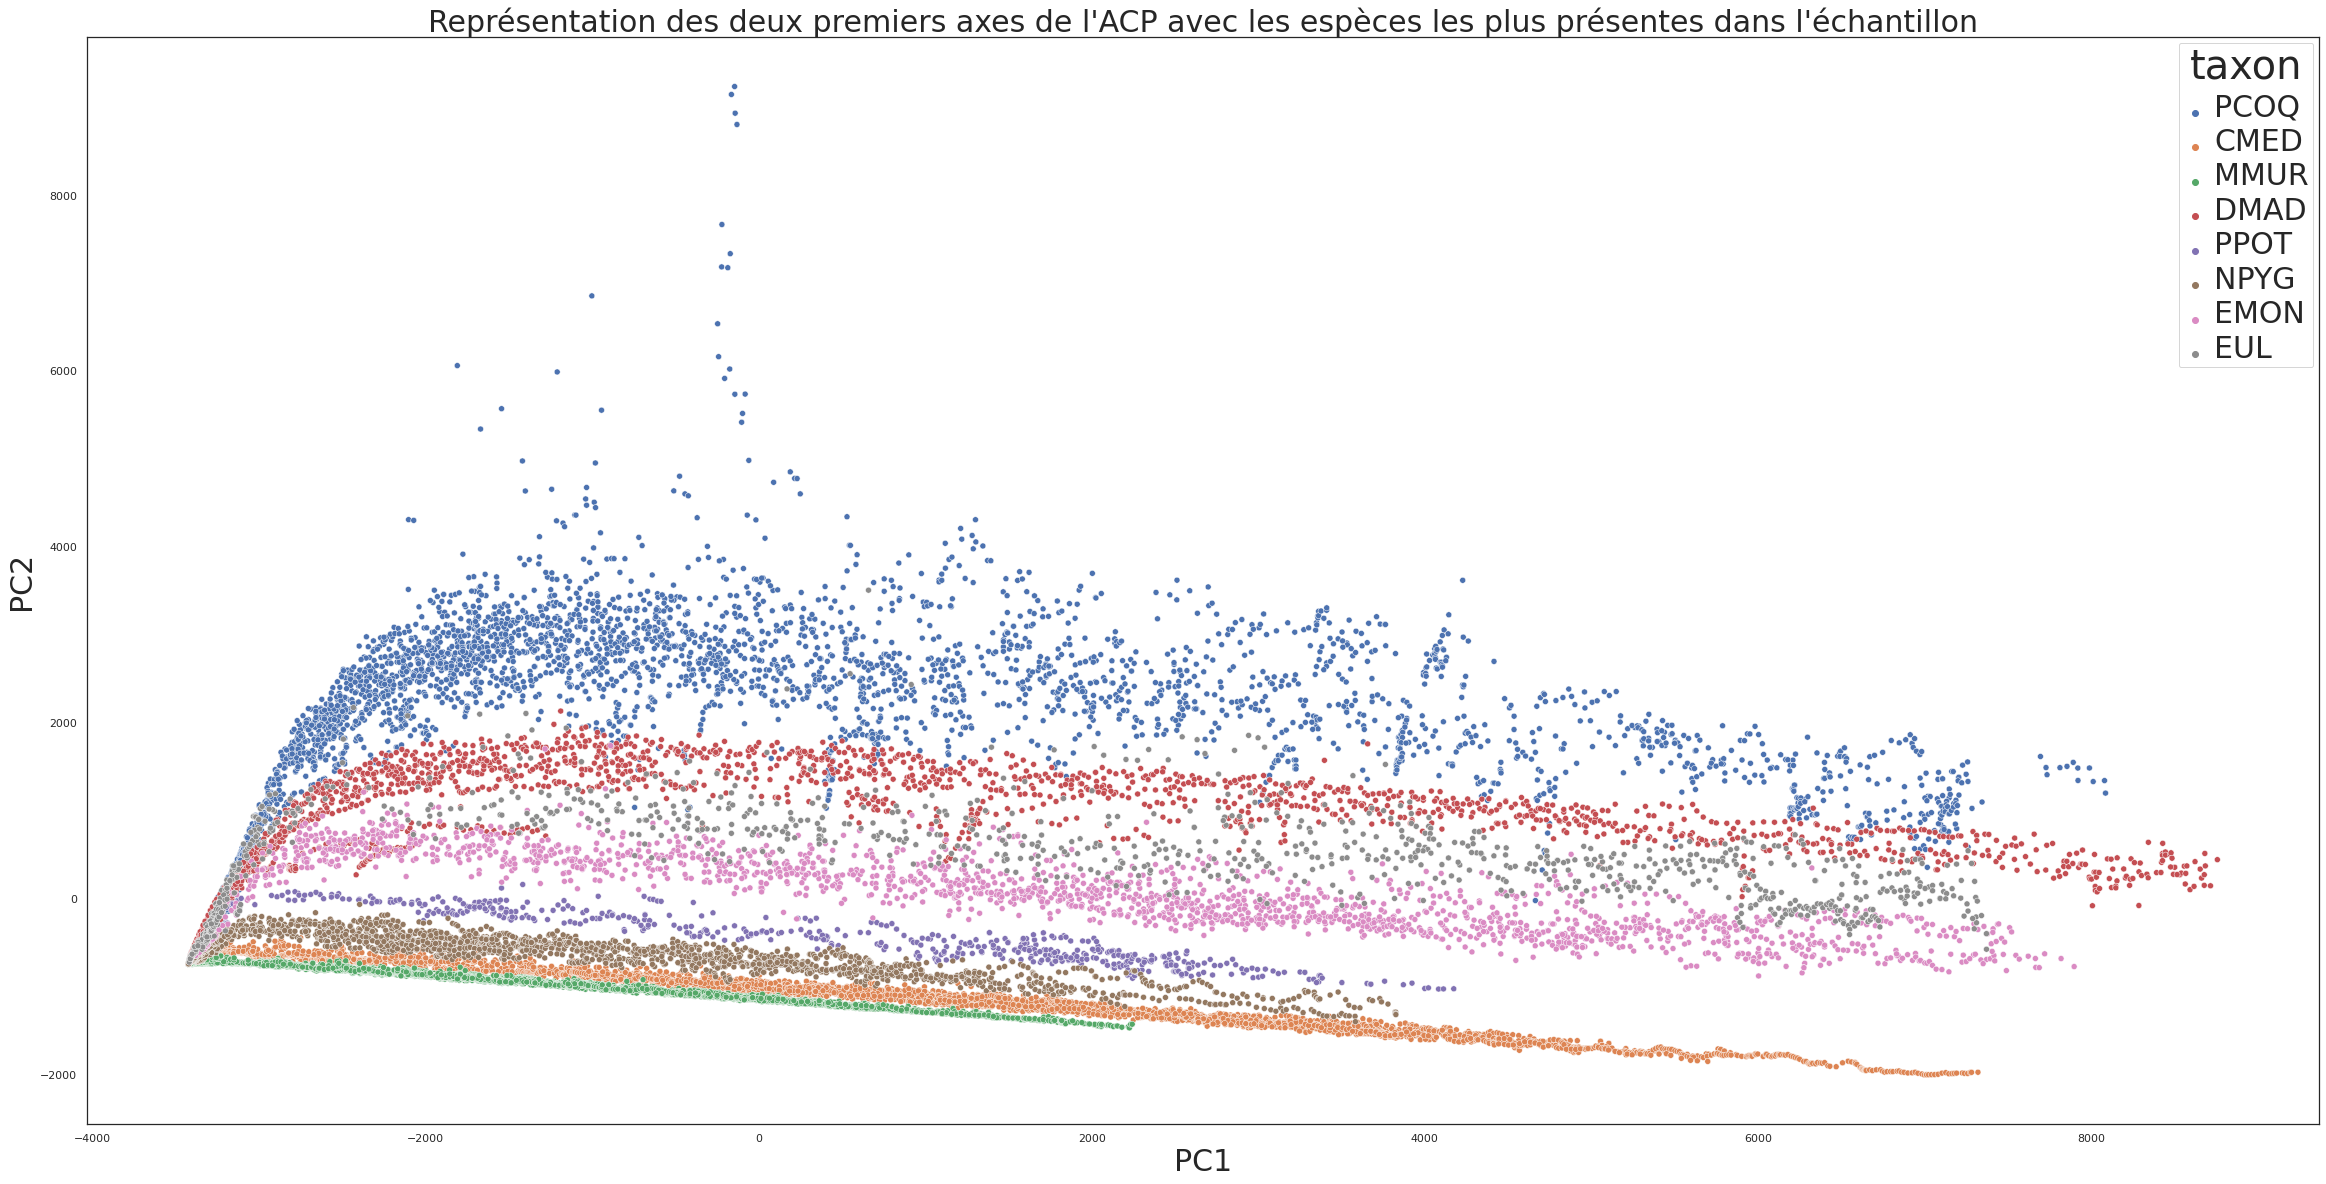

In [75]:
df_no_preg=df.loc[df['preg_status']=='NP']
df_taxo=pd.DataFrame()
#df_taxo=df_no_preg.loc[df_no_preg['taxon']=="LCAT"] #Ajouter choix des groupes taxonomiques
df_taxo=df_taxo.append(df_no_preg.loc[df_no_preg['taxon']=="PCOQ"])
df_taxo=df_taxo.append(df_no_preg.loc[df_no_preg['taxon']=="CMED"])
df_taxo=df_taxo.append(df_no_preg.loc[df_no_preg['taxon']=="MMUR"])
df_taxo=df_taxo.append(df_no_preg.loc[df_no_preg['taxon']=="DMAD"])
df_taxo=df_taxo.append(df_no_preg.loc[df_no_preg['taxon']=="PPOT"])
df_taxo=df_taxo.append(df_no_preg.loc[df_no_preg['taxon']=="NPYG"])
df_taxo=df_taxo.append(df_no_preg.loc[df_no_preg['taxon']=="EMON"])
df_taxo=df_taxo.append(df_no_preg.loc[df_no_preg['taxon']=="EUL"])
cls = PCA(n_components=4) #Pourquoi 4? 
df_pca=pd.DataFrame()
df_pca['birth_month'] = df_taxo['birth_month']
df_pca['age_at_death_y'] = df_taxo['age_at_death_y']
df_pca['weight_g'] = df_taxo['weight_g']
df_pca['age_at_wt_d'] = df_taxo['age_at_wt_d']
df_pca['taxon'] = df_taxo['taxon']
index_with_nan = df_pca.index[df_pca.isnull().any(axis=1)]
df_pca.drop(index_with_nan,0, inplace=True)
pcs_stroop = cls.fit_transform(df_pca.iloc[:,0:4])
df_crabs = pd.DataFrame(pcs_stroop, columns=[f"PC{i}" for i in range(1, 5)])
df_crabs
list_id=[]
for i in range(len(df_pca)):
    list_id.append(df_pca.index[i])
list_taxon=[]
for i in range(len(list_id)):
    #print(df_taxon['taxon'][list_id[i]])
    list_taxon.append(df_taxo['taxon'][list_id[i]])
    #print(list_taxon[i])
df_crabs["taxon"]=list_taxon
df_crabs["taxon"].astype(str)
#plt.title("Représentation des deux premiers axes de l'ACP avec les espèces les plus présentes dans l'échantillon")
p=sns.scatterplot(x=df_crabs['PC1'],y=df_crabs['PC2'],hue=df_crabs['taxon'],data=df_crabs)
p.set_xlabel("PC1", fontsize = 30)
p.set_ylabel("PC2", fontsize = 30)
p.set_title("Représentation des deux premiers axes de l'ACP avec les espèces les plus présentes dans l'échantillon", fontsize = 30)
plt.setp(p.get_legend().get_texts(), fontsize='30') 
# for legend title
plt.setp(p.get_legend().get_title(), fontsize='40')
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.show()

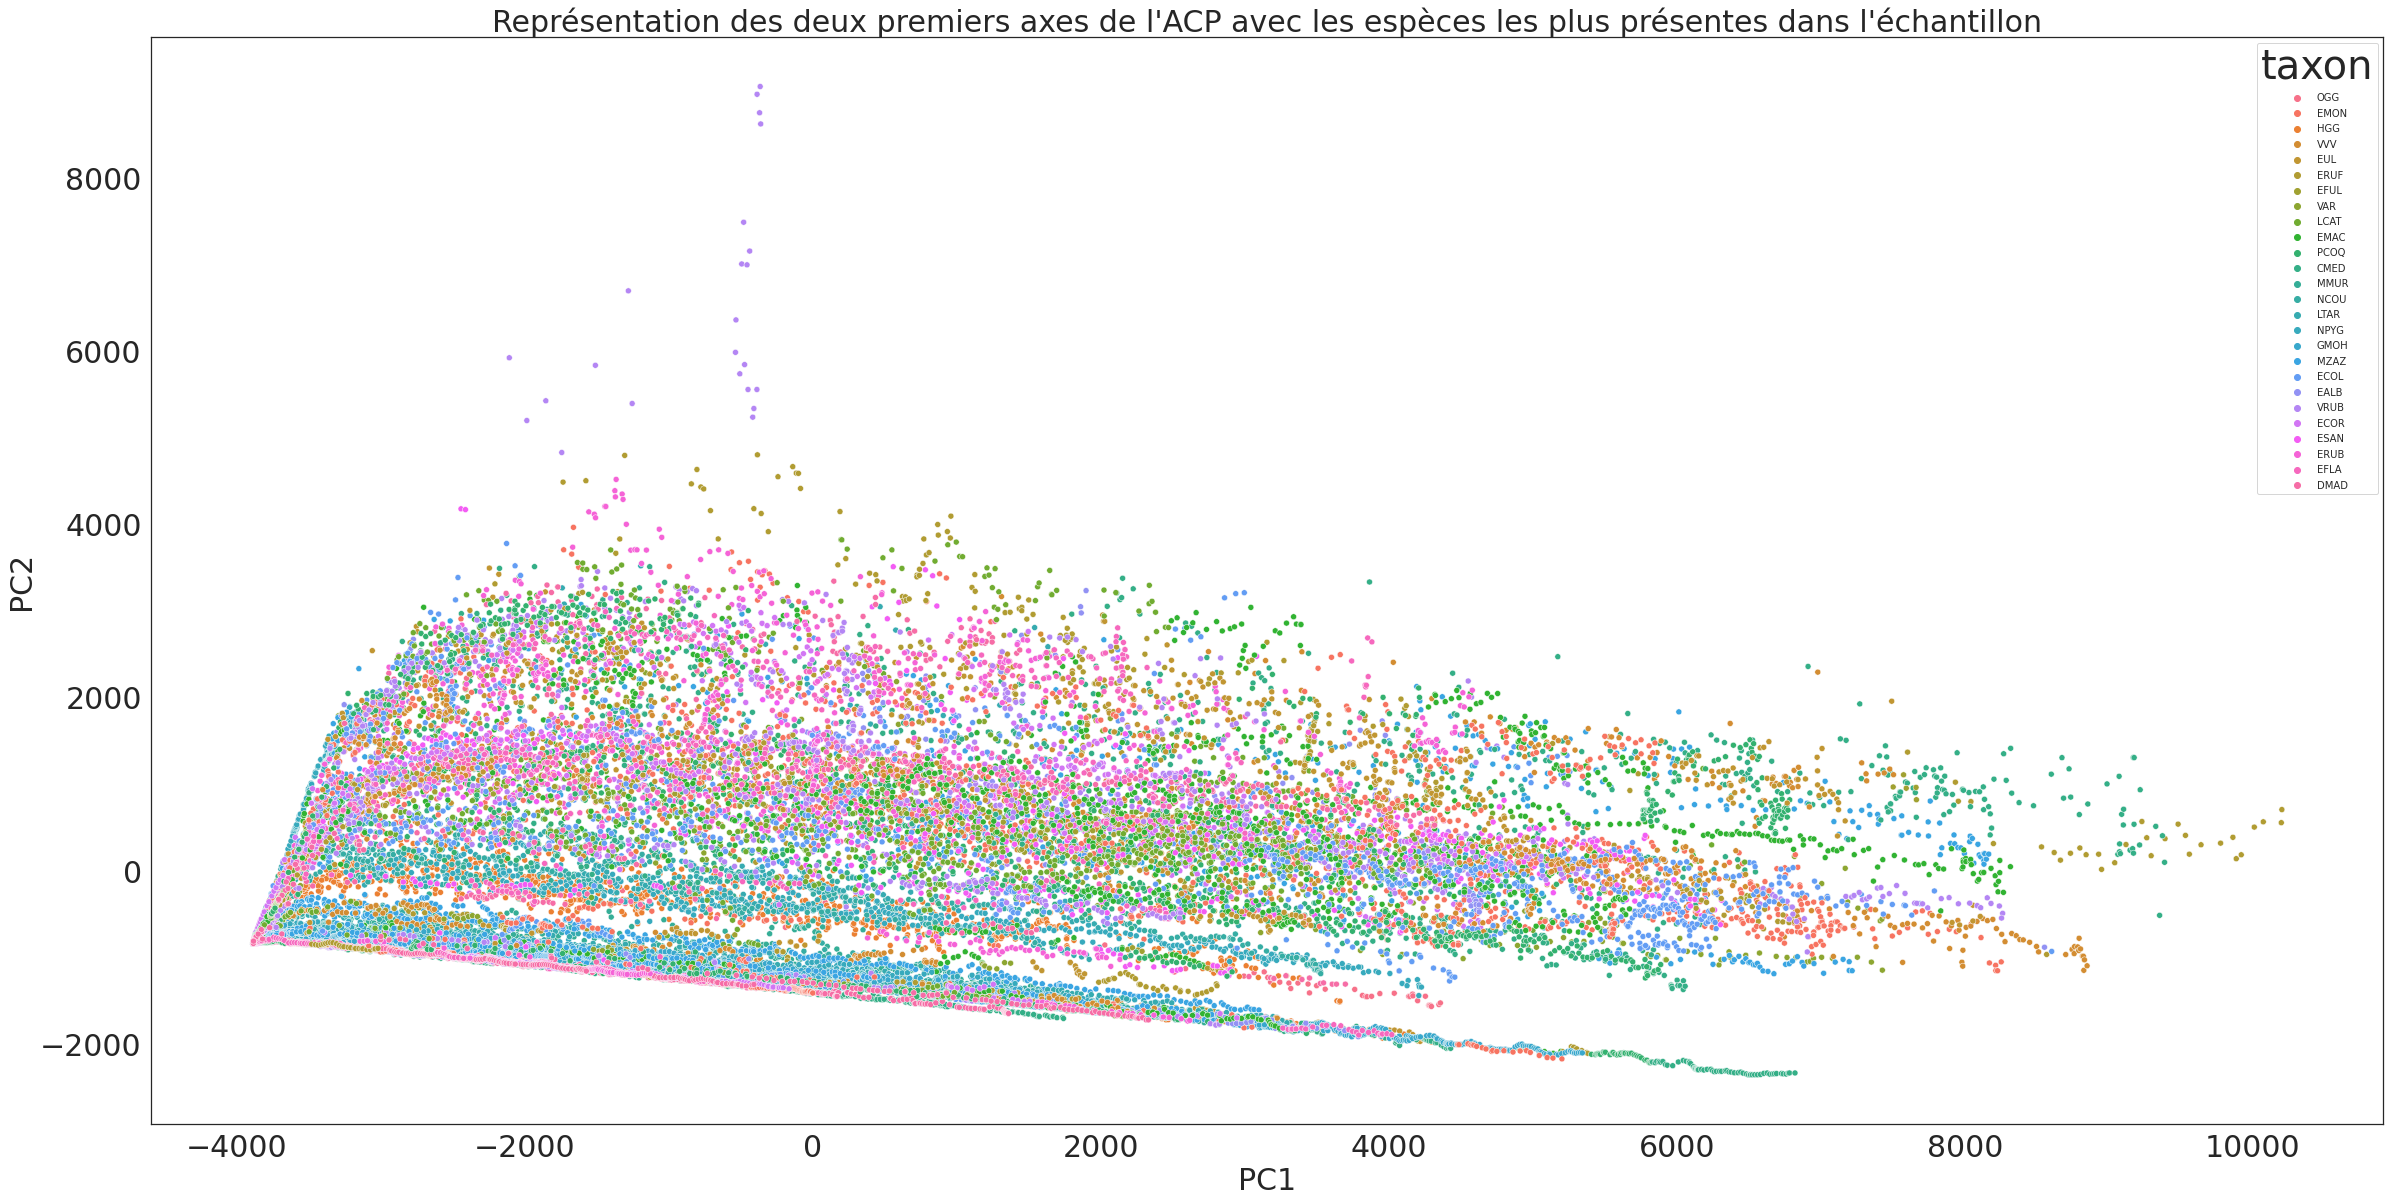

In [76]:
df_no_preg=df.loc[df['preg_status']=='NP']
cls = PCA(n_components=4) #Pourquoi 4?
df_pca=pd.DataFrame()
df_pca['birth_month'] = df_no_preg['birth_month']
df_pca['age_at_death_y'] = df_no_preg['age_at_death_y']
df_pca['weight_g'] = df_no_preg['weight_g']
df_pca['age_at_wt_d'] = df_no_preg['age_at_wt_d']
df_pca['taxon'] = df_no_preg['taxon']
index_with_nan = df_pca.index[df_pca.isnull().any(axis=1)]
df_pca.drop(index_with_nan,0, inplace=True)
pcs_stroop = cls.fit_transform(df_pca.iloc[:,0:4])
df_crabs = pd.DataFrame(pcs_stroop, columns=[f"PC{i}" for i in range(1, 5)])
df_crabs
df_crabs["taxon"]=df_pca["taxon"]
#plt.title("Représentation des deux premiers axes de l'ACP avec les espèces les plus présentes dans l'échantillon")
p=sns.scatterplot(x=df_crabs['PC1'],y=df_crabs['PC2'],hue=df_crabs['taxon'],data=df_crabs)
p.set_xlabel("PC1", fontsize = 30)
p.set_ylabel("PC2", fontsize = 30)
p.set_title("Représentation des deux premiers axes de l'ACP avec les espèces les plus présentes dans l'échantillon", fontsize = 30)
plt.setp(p.get_legend().get_texts(), fontsize='10')
# for legend title
plt.setp(p.get_legend().get_title(), fontsize='40')
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30)
plt.show()

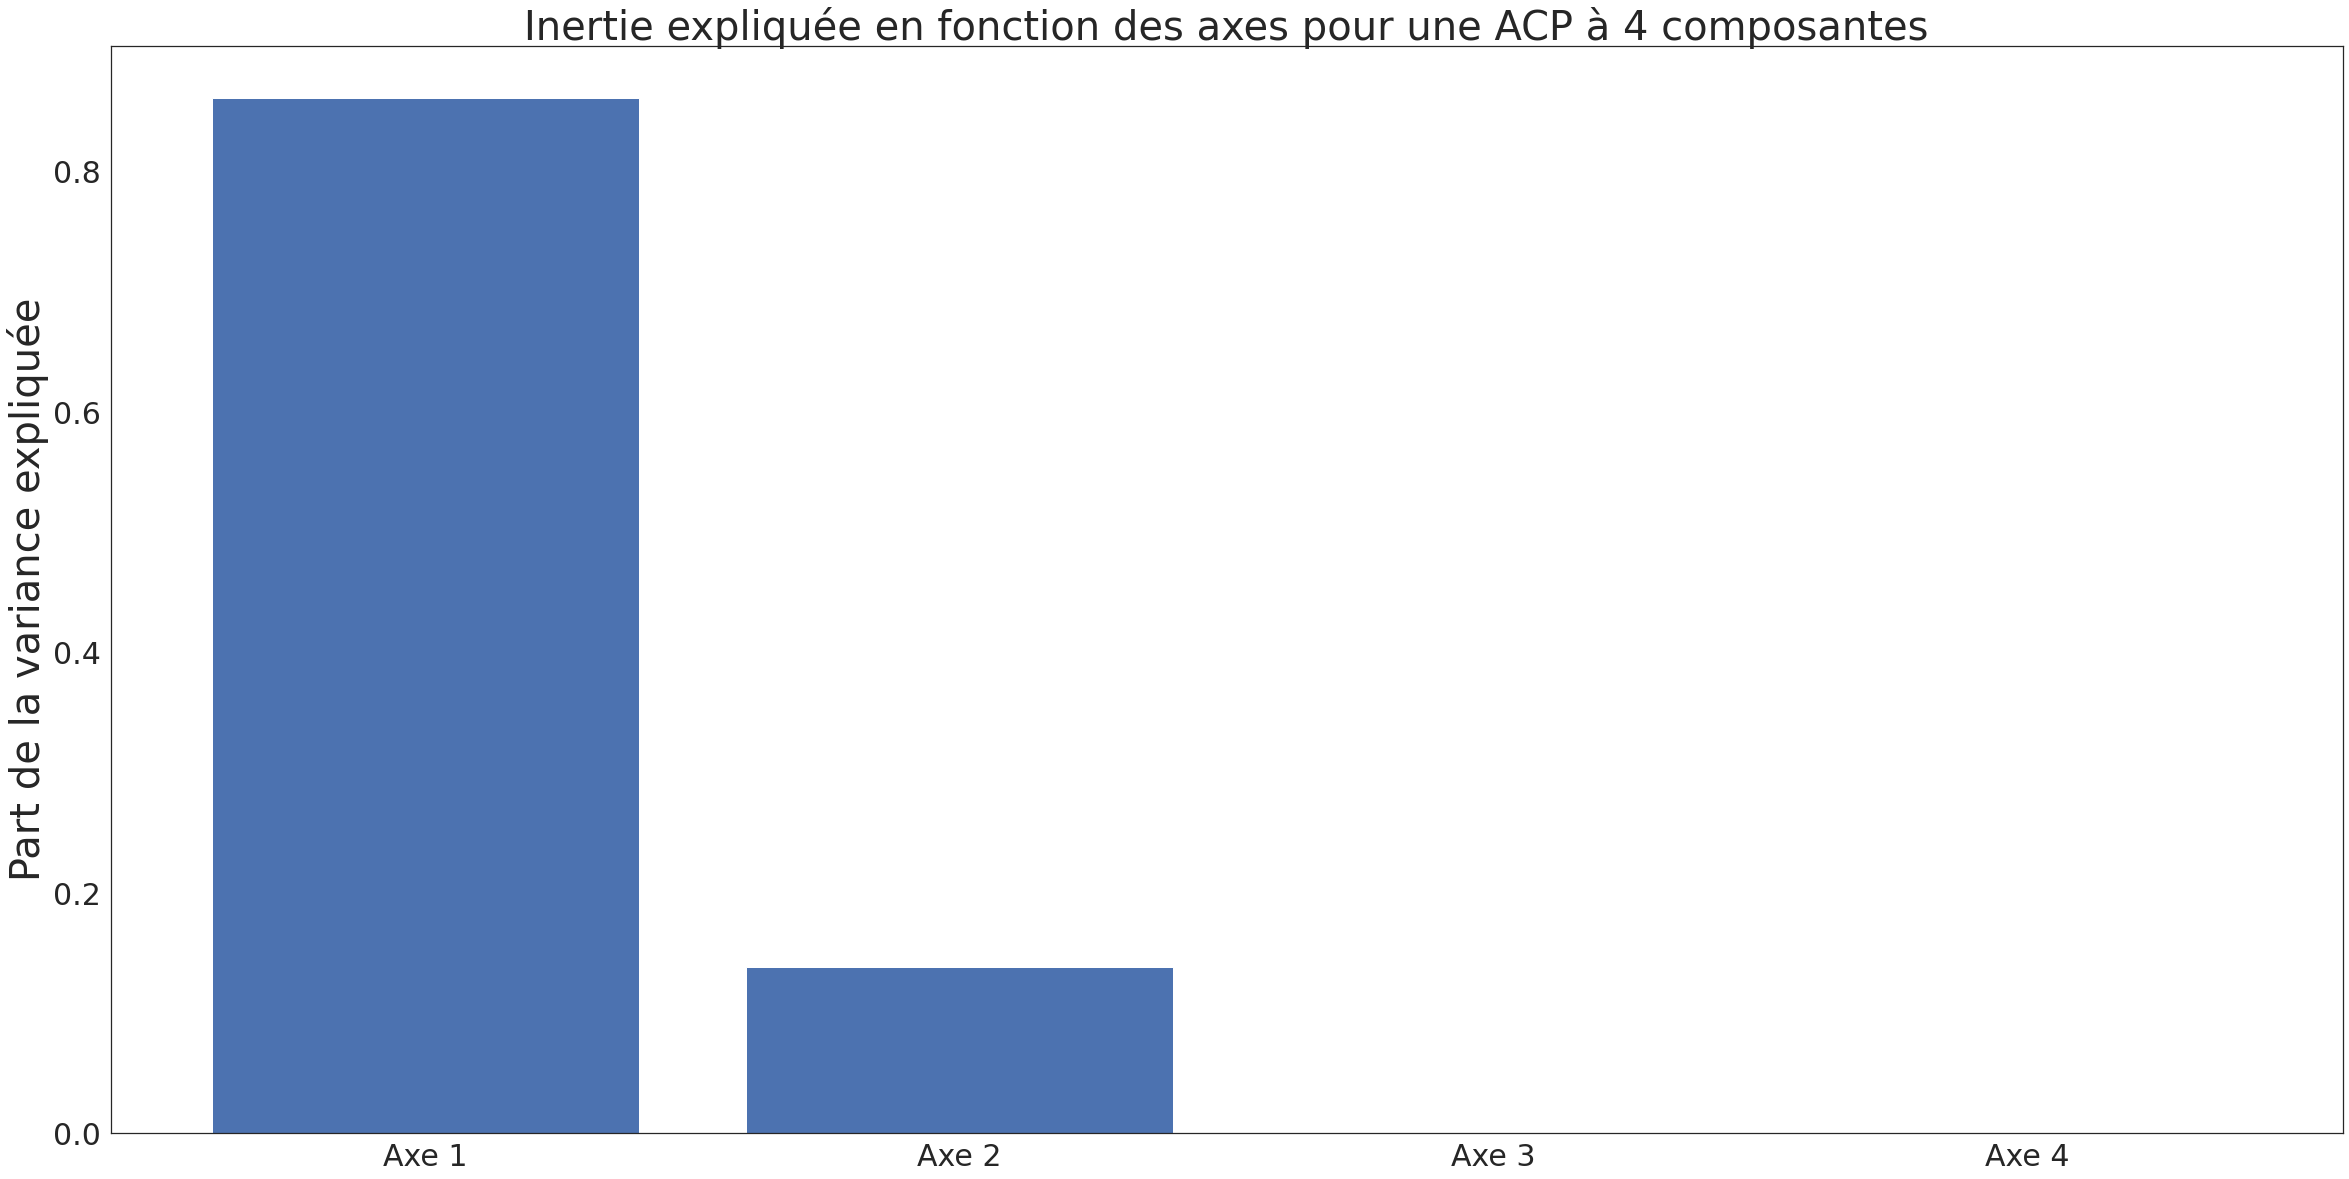

In [77]:
plt.ylabel("Part de la variance expliquée", fontsize=40)
plt.title("Inertie expliquée en fonction des axes pour une ACP à 4 composantes",fontsize=40)
plt.bar(["Axe 1", "Axe 2", "Axe 3","Axe 4"],cls.explained_variance_ratio_)
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
# for legend title

plt.show() #à mettre en annexe

Le meilleur paramètre pour les k plus proches voisins est : 13


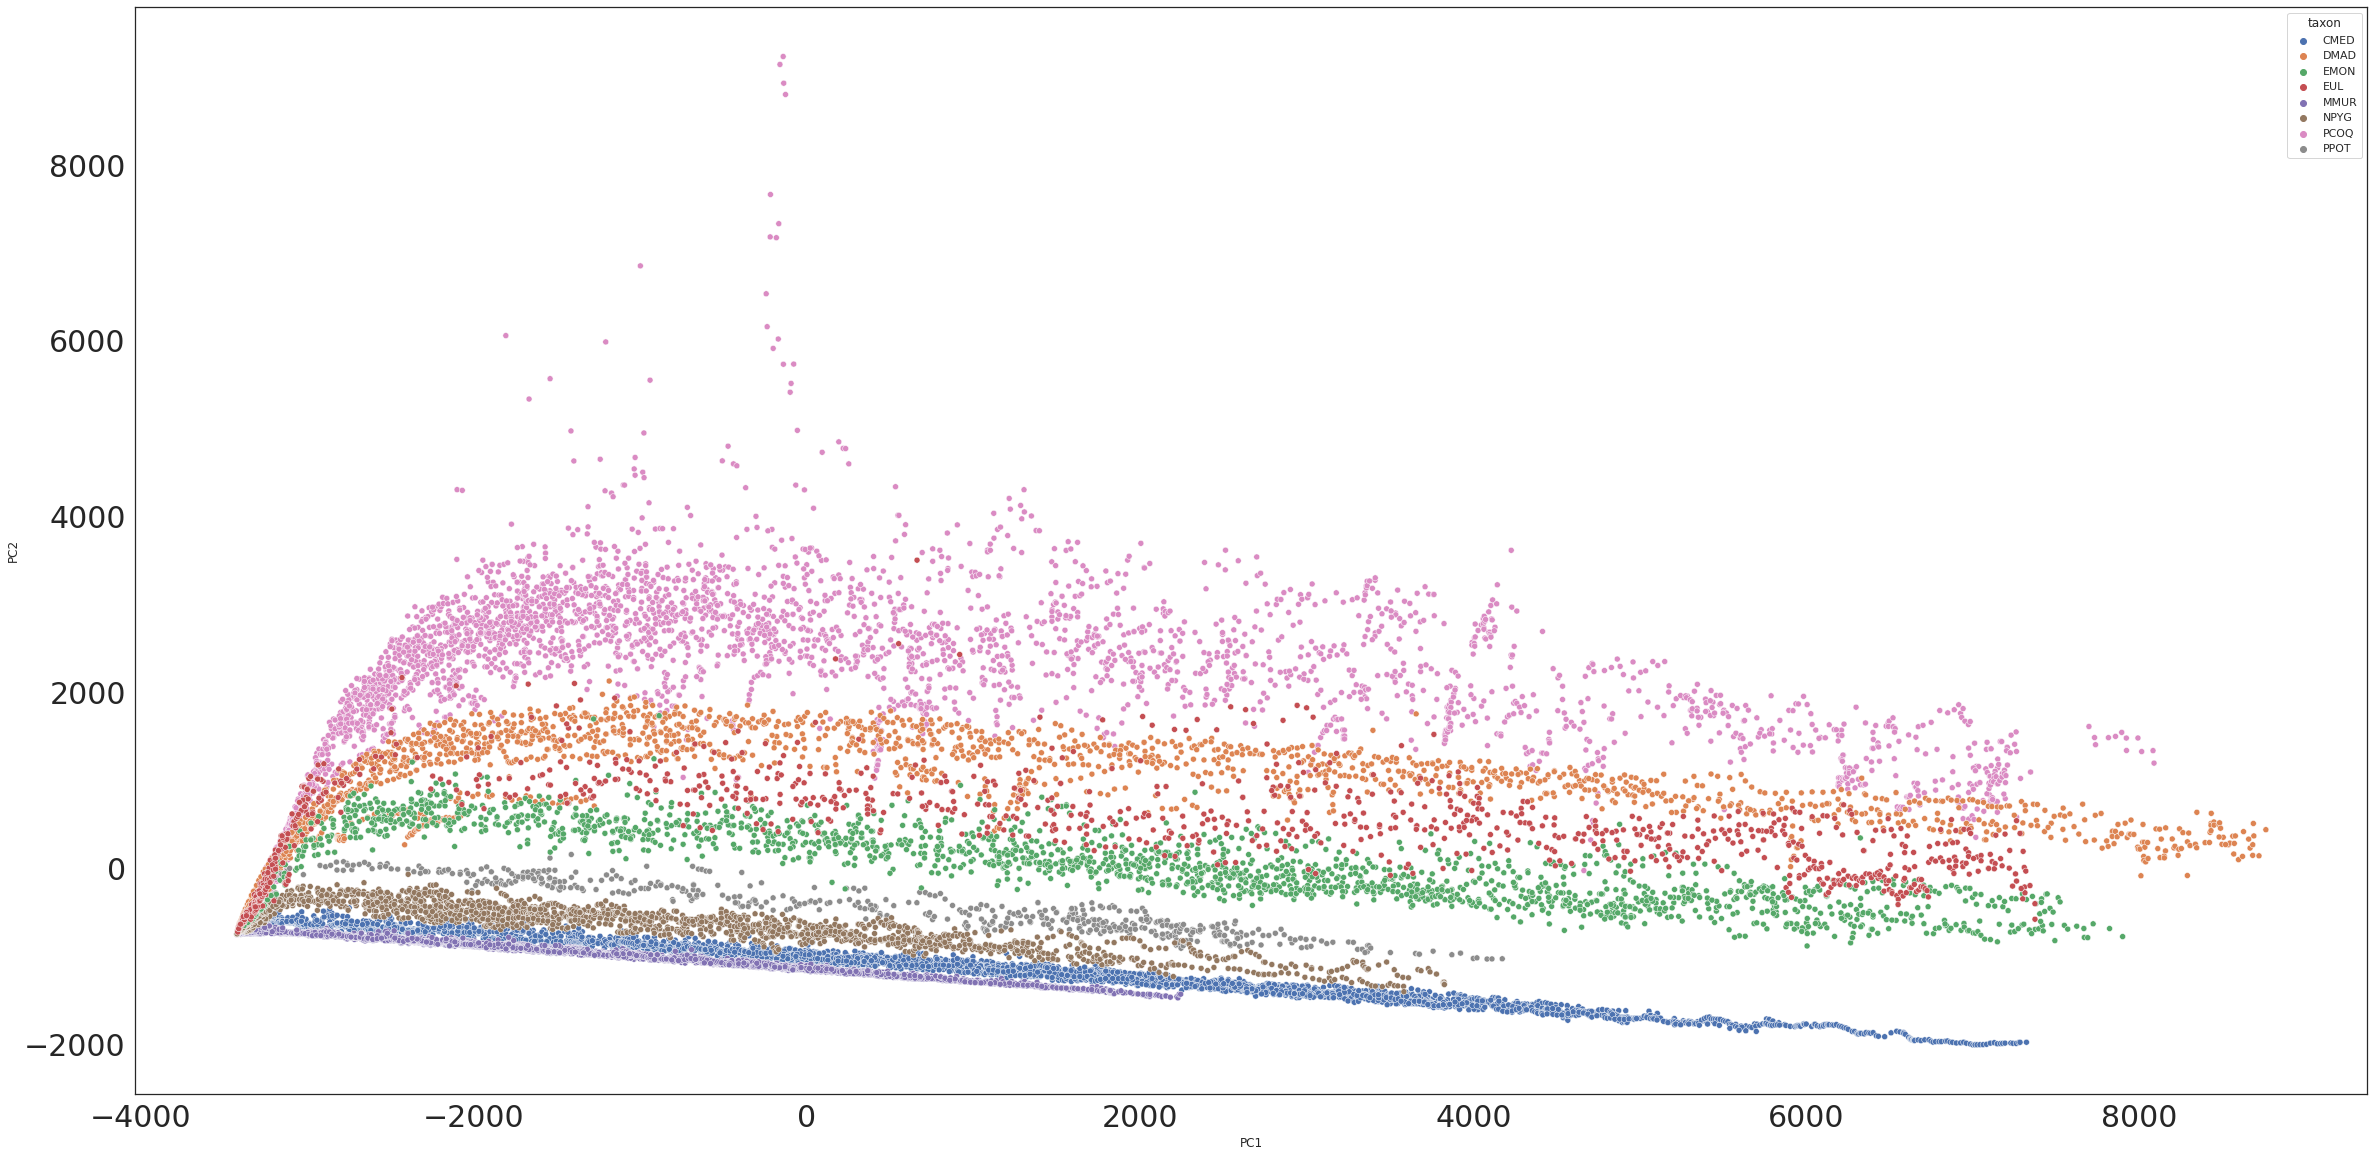

Les bonnes réponses sont : PCOQ, CMED, MMUR, DMAD, PPOT, NPYG, EMON, EUL
6 /8 bonnes réponses.


In [78]:
#il manquerait pas ici les frontières de décision?
import random
df_k=pd.DataFrame()
df_k=df_k.append(df_pca.loc[df_pca['taxon']=="PCOQ"])
df_k=df_k.append(df_pca.loc[df_pca['taxon']=="CMED"])
df_k=df_k.append(df_pca.loc[df_pca['taxon']=="MMUR"])
df_k=df_k.append(df_pca.loc[df_pca['taxon']=="DMAD"])
df_k=df_k.append(df_pca.loc[df_pca['taxon']=="PPOT"])
df_k=df_k.append(df_pca.loc[df_pca['taxon']=="NPYG"])
df_k=df_k.append(df_pca.loc[df_pca['taxon']=="EMON"])
df_k=df_k.append(df_pca.loc[df_pca['taxon']=="EUL"])
df_1 = df_k.loc[df_k['taxon']=='PCOQ']
df_2 = df_k.loc[df_k['taxon']=='CMED']
df_3 = df_k.loc[df_k['taxon']=='MMUR']
df_4 = df_k.loc[df_k['taxon']=='DMAD']
df_5 = df_k.loc[df_k['taxon']=='PPOT']
df_6 = df_k.loc[df_k['taxon']=='NPYG']
df_7 = df_k.loc[df_k['taxon']=='EMON']
df_8 = df_k.loc[df_k['taxon']=='EUL']

a = random.randint(0,len(df_1))
b = random.randint(0,len(df_2))
c = random.randint(0,len(df_3))
d = random.randint(0,len(df_4))
e = random.randint(0,len(df_5))
f = random.randint(0,len(df_6))
g = random.randint(0,len(df_7))
h = random.randint(0,len(df_8))

df1 = df_1.iloc[a]
df2 = df_2.iloc[b]
df3 = df_3.iloc[c]
df4 = df_4.iloc[d]
df5 = df_5.iloc[e]
df6 = df_6.iloc[f]
df7 = df_7.iloc[g]
df8 = df_8.iloc[h]
df_1 = df_1.drop(df_1.index[a])
df_2 = df_2.drop(df_2.index[b])
df_3 = df_3.drop(df_3.index[c])
df_4 = df_4.drop(df_4.index[d])
df_5 = df_5.drop(df_5.index[e])
df_6 = df_6.drop(df_6.index[f])
df_7 = df_7.drop(df_7.index[g])
df_8 = df_8.drop(df_8.index[h])
df_k=pd.DataFrame()
df_k=df_k.append(df_1)
df_k=df_k.append(df_2)
df_k=df_k.append(df_3)
df_k=df_k.append(df_4)
df_k=df_k.append(df_5)
df_k=df_k.append(df_6)
df_k=df_k.append(df_7)
df_k=df_k.append(df_8)

X = df_k.iloc[:, :-1]
y = df_k.iloc[:, -1]
from sklearn.model_selection import GridSearchCV
# De 1 à 50 voisins (exclu), échelle logarithmique
n_neighbors_list = np.unique(np.round(np.geomspace(1, 50, 100)).astype(int))
param_grid = {"n_neighbors": n_neighbors_list}
cls = KNeighborsClassifier()
search = GridSearchCV(cls, param_grid, scoring="accuracy", cv=10)
X = df_k.iloc[:, :-1]
y = df_k.iloc[:, -1]
search.fit(X, y)
k=search.best_params_['n_neighbors']
print("Le meilleur paramètre pour les k plus proches voisins est :",k)

plot_clustering(X, y)
#add_decision_boundary(search,model_classes=k)
plt.show()

cls = KNeighborsClassifier(n_neighbors=k)
cls.fit(X, y)
Y = np.array([[df1[0],df1[1],df1[2],df1[3]],[df2[0],df2[1],df2[2],df2[3]],[df3[0],df3[1],df3[2],df3[3]],[df4[0],df4[1],df4[2],df4[3]],[df5[0],df5[1],df5[2],df5[3]],[df6[0],df6[1],df6[2],df6[3]],[df7[0],df7[1],df7[2],df7[3]],[df8[0],df8[1],df8[2],df8[3]]])
labels = cls.predict(Y)
labels
good_answer=['PCOQ', 'CMED', 'MMUR', 'DMAD', 'PPOT', 'NPYG', 'EMON', 'EUL']
print("Les bonnes réponses sont : PCOQ, CMED, MMUR, DMAD, PPOT, NPYG, EMON, EUL")

good=0
for i in range(len(labels)):
    if labels[i]==good_answer[i]:
        good=good+1
print(good,'/8 bonnes réponses.')

In [79]:
pc=0
n=100
for j in range(n):
    df_k=pd.DataFrame()
    df_k=df_k.append(df_pca.loc[df_pca['taxon']=="PCOQ"])
    df_k=df_k.append(df_pca.loc[df_pca['taxon']=="CMED"])
    df_k=df_k.append(df_pca.loc[df_pca['taxon']=="MMUR"])
    df_k=df_k.append(df_pca.loc[df_pca['taxon']=="DMAD"])
    df_k=df_k.append(df_pca.loc[df_pca['taxon']=="PPOT"])
    df_k=df_k.append(df_pca.loc[df_pca['taxon']=="NPYG"])
    df_k=df_k.append(df_pca.loc[df_pca['taxon']=="EMON"])
    df_k=df_k.append(df_pca.loc[df_pca['taxon']=="EUL"])
    df_1 = df_k.loc[df_k['taxon']=='PCOQ']
    df_2 = df_k.loc[df_k['taxon']=='CMED']
    df_3 = df_k.loc[df_k['taxon']=='MMUR']
    df_4 = df_k.loc[df_k['taxon']=='DMAD']
    df_5 = df_k.loc[df_k['taxon']=='PPOT']
    df_6 = df_k.loc[df_k['taxon']=='NPYG']
    df_7 = df_k.loc[df_k['taxon']=='EMON']
    df_8 = df_k.loc[df_k['taxon']=='EUL']

    a = random.randint(0,len(df_1)-1)
    b = random.randint(0,len(df_2)-1)
    c = random.randint(0,len(df_3)-1)
    d = random.randint(0,len(df_4)-1)
    e = random.randint(0,len(df_5)-1)
    f = random.randint(0,len(df_6)-1)
    g = random.randint(0,len(df_7)-1)
    h = random.randint(0,len(df_8)-1)

    df1 = df_1.iloc[a]
    df2 = df_2.iloc[b]
    df3 = df_3.iloc[c]
    df4 = df_4.iloc[d]
    df5 = df_5.iloc[e]
    df6 = df_6.iloc[f]
    df7 = df_7.iloc[g]
    df8 = df_8.iloc[h]

    df_1 = df_1.drop(df_1.index[a])
    df_2 = df_2.drop(df_2.index[b])
    df_3 = df_3.drop(df_3.index[c])
    df_4 = df_4.drop(df_4.index[d])
    df_5 = df_5.drop(df_5.index[e])
    df_6 = df_6.drop(df_6.index[f])
    df_7 = df_7.drop(df_7.index[g])
    df_8 = df_8.drop(df_8.index[h])

    df_k=pd.DataFrame()
    df_k=df_k.append(df_1)
    df_k=df_k.append(df_2)
    df_k=df_k.append(df_3)
    df_k=df_k.append(df_4)
    df_k=df_k.append(df_5)
    df_k=df_k.append(df_6)
    df_k=df_k.append(df_7)
    df_k=df_k.append(df_8)

    X = df_k.iloc[:, :-1]
    y = df_k.iloc[:, -1]
    cls = KNeighborsClassifier(n_neighbors=13)
    cls.fit(X, y)
    Y = np.array([[df1[0],df1[1],df1[2],df1[3]],[df2[0],df2[1],df2[2],df2[3]],[df3[0],df3[1],df3[2],df3[3]],[df4[0],df4[1],df4[2],df4[3]],[df5[0],df5[1],df5[2],df5[3]],[df6[0],df6[1],df6[2],df6[3]],[df7[0],df7[1],df7[2],df7[3]],[df8[0],df8[1],df8[2],df8[3]]])
    labels = cls.predict(Y)
    labels
    good_answer=['PCOQ', 'CMED', 'MMUR', 'DMAD', 'PPOT', 'NPYG', 'EMON', 'EUL']

    good=0
    for i in range(len(labels)):
        if labels[i]==good_answer[i]:
            good+=1
            pc+=1
    
print("Sur",n,"essais de 8 espèces, une précision de :",pc/(8*n))

Sur 100 essais de 8 espèces, une précision de : 0.8825


[None]

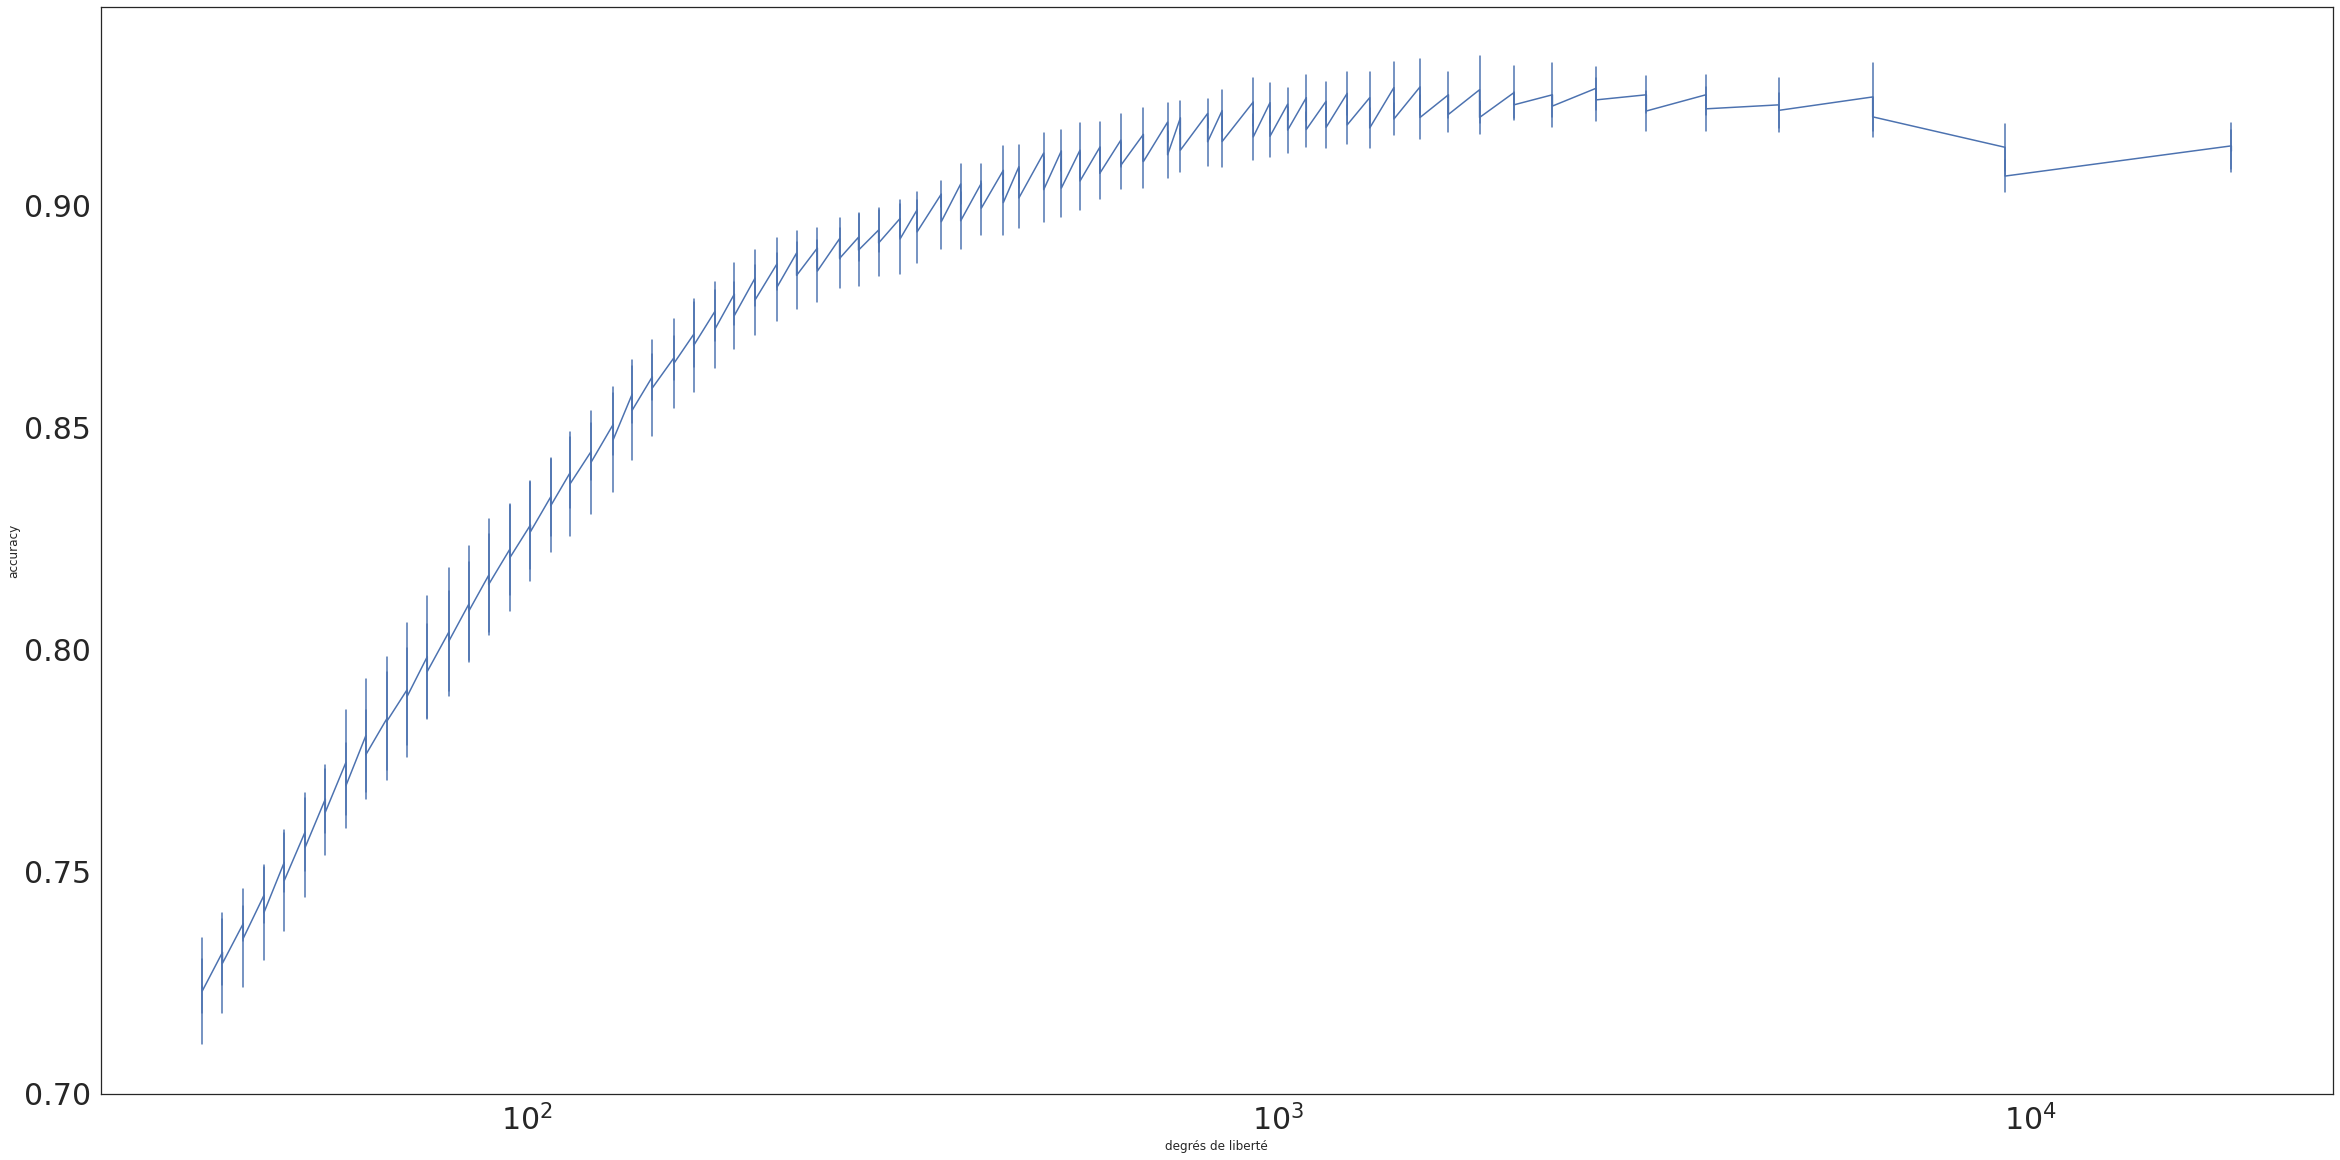

In [80]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.utils import check_X_y
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
#scores validation croisée

def accuracy(X_train, y_train, X_val, y_val, n_neighbors):
    """Précision d'un modèle Knn pour un jeu de données
    d'apprentissage et de validation fournis."""

    # Définition, apprentissage et prédiction par la méthode des
    # plus proches voisins avec `n_neighbors` voisins
    cls = KNeighborsClassifier(n_neighbors=n_neighbors)
    cls.fit(X_train, y_train)
    pred = cls.predict(X_val)

    # Calcul de la précision avec `accuracy_score`
    acc = accuracy_score(pred, y_val)

    return acc

def knn_cross_validation(X, y, n_folds, n_neighbors_list):
    """Génère les couples nombre de voisins et précisions correspondantes."""

    # Conversion en tableau numpy si on fournit des DataFrame par exemple
    from sklearn.utils import check_X_y
    X, y = check_X_y(X, y)

    def models_accuracies(train_index, val_index, n_neighbors_list):
        """Précision de tous les modèles pour un jeu de données fixé."""

        # Création de `X_train`, `y_train`, `X_val` et `y_val`
        X_train = X[train_index, :]
        y_train = y[train_index]
        X_val = X[val_index, :]
        y_val = y[val_index]

        # Calcul des précisions pour chaque nombre de voisins présent
        # dans `n_neighbors`
        n = len(train_index)
        for n_neighbors in n_neighbors_list:
            yield (
                n_neighbors,
                accuracy(X_train, y_train, X_val, y_val, n_neighbors),
                n / n_neighbors
            )

    # Définition de `n_folds` jeu de données avec `KFold`
    kf = KFold(n_splits=n_folds, shuffle=True).split(X)

    # Calcul et retour des précisions avec `models_accuracies` pour
    # chaque jeu de données défini par `KFold`.
    for train_index, test_index in kf:
        yield from models_accuracies(train_index, test_index, n_neighbors_list)

n_neighbors_list = np.unique(np.round(np.geomspace(1, 500, 100)).astype(int))
n_folds = 10
gen = knn_cross_validation(X, y, n_folds, n_neighbors_list)
df_validation = pd.DataFrame(gen, columns=["# neighbors", "accuracy", "degrés de liberté"])
Kopt = df_validation.groupby("# neighbors").mean().accuracy.idxmax()
Kopt
sp = sns.lineplot(x="degrés de liberté", y="accuracy",err_style="bars", ci="sd", data=df_validation)
sp.set(xscale="log")



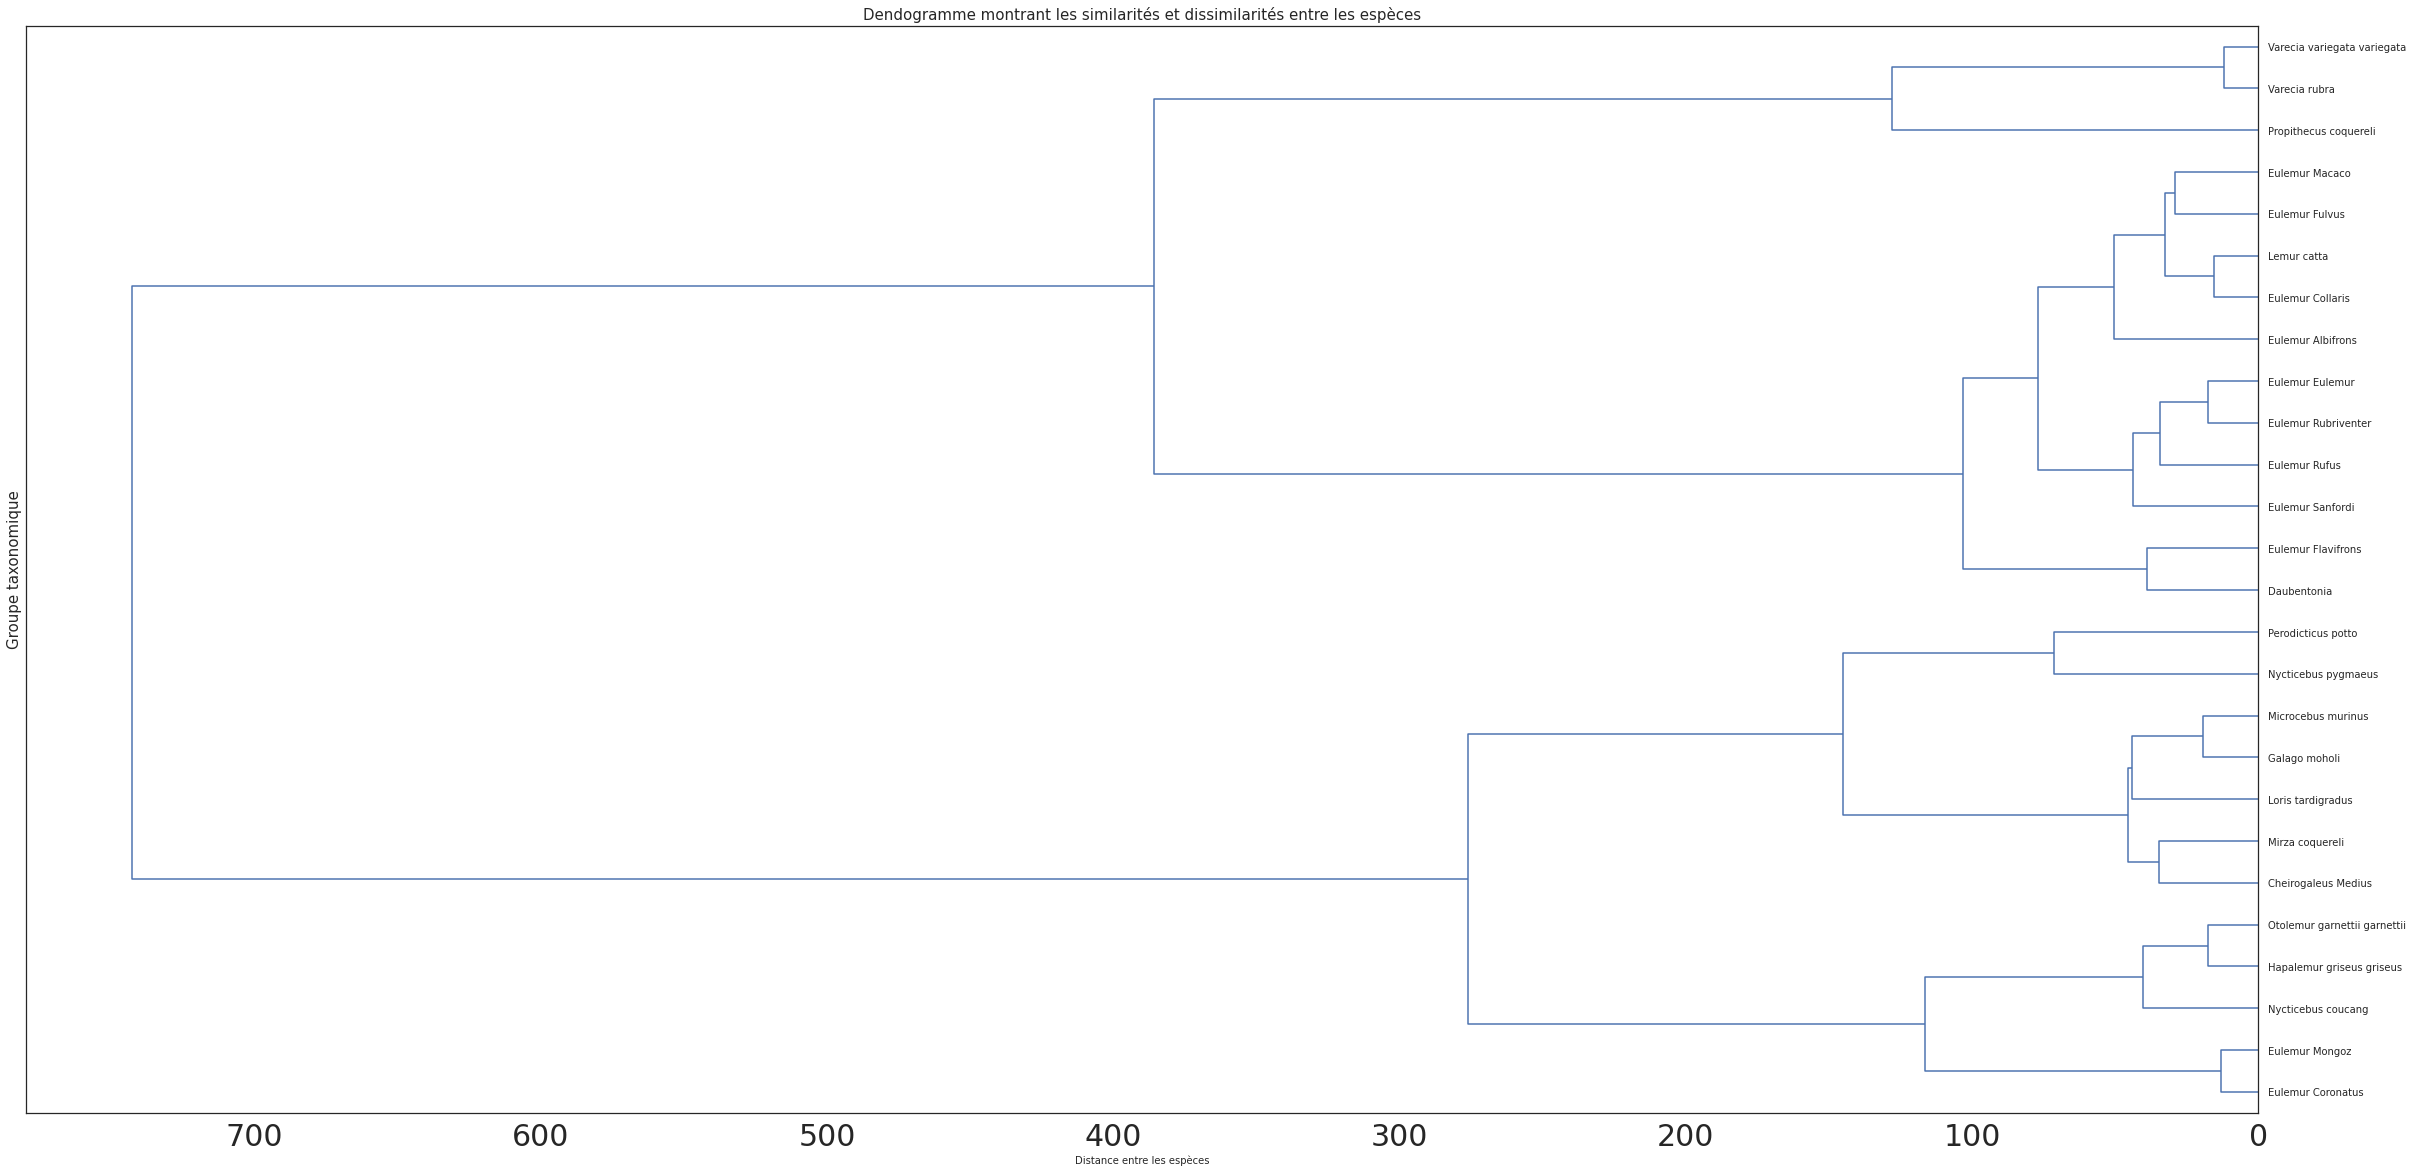

In [81]:
from sklearn.cluster import AgglomerativeClustering
index_taxon=["Cheirogaleus Medius","Daubentonia","Eulemur Albifrons","Eulemur Collaris","Eulemur Coronatus","Eulemur Flavifrons","Eulemur Fulvus","Eulemur Macaco","Eulemur Mongoz","Eulemur Rubriventer","Eulemur Rufus","Eulemur Sanfordi","Eulemur Eulemur","Galago moholi","Hapalemur griseus griseus","Lemur catta","Loris tardigradus","Microcebus murinus","Mirza coquereli","Nycticebus coucang","Nycticebus pygmaeus","Otolemur garnettii garnettii","Propithecus coquereli","Perodicticus potto","Varecia rubra","Varecia variegata variegata"]
df_aftd=pd.DataFrame()
df_aftd=df_aftd.append(df_no_preg.loc[df_no_preg['age_category']=="adult"])
df_aftd_f=df_aftd.loc[df_aftd['sex']=='F']
df_aftd_f.loc[df_aftd_f['preg_status']=='NP']
df_aftd_f_CMED=df_aftd_f.loc[df_aftd_f['taxon']=='CMED']
df_aftd_f_DMAD=df_aftd_f.loc[df_aftd_f['taxon']=='DMAD']
df_aftd_f_EALB=df_aftd_f.loc[df_aftd_f['taxon']=='EALB']
df_aftd_f_ECOL=df_aftd_f.loc[df_aftd_f['taxon']=='ECOL']
df_aftd_f_ECOR=df_aftd_f.loc[df_aftd_f['taxon']=='ECOR']
df_aftd_f_EFLA=df_aftd_f.loc[df_aftd_f['taxon']=='EFLA']
df_aftd_f_EFUL=df_aftd_f.loc[df_aftd_f['taxon']=='EFUL']
df_aftd_f_EMAC=df_aftd_f.loc[df_aftd_f['taxon']=='EMAC']
df_aftd_f_EMON=df_aftd_f.loc[df_aftd_f['taxon']=='EMON']
df_aftd_f_ERUB=df_aftd_f.loc[df_aftd_f['taxon']=='ERUB']
df_aftd_f_ERUF=df_aftd_f.loc[df_aftd_f['taxon']=='ERUF']
df_aftd_f_ESAN=df_aftd_f.loc[df_aftd_f['taxon']=='ESAN']
df_aftd_f_EUL=df_aftd_f.loc[df_aftd_f['taxon']=='EUL']
df_aftd_f_GMOH=df_aftd_f.loc[df_aftd_f['taxon']=='GMOH']
df_aftd_f_HGG=df_aftd_f.loc[df_aftd_f['taxon']=='HGG']
df_aftd_f_LCAT=df_aftd_f.loc[df_aftd_f['taxon']=='LCAT']
df_aftd_f_LTAR=df_aftd_f.loc[df_aftd_f['taxon']=='LTAR']
df_aftd_f_MMUR=df_aftd_f.loc[df_aftd_f['taxon']=='MMUR']
df_aftd_f_MZAZ=df_aftd_f.loc[df_aftd_f['taxon']=='MZAZ']
df_aftd_f_NCOU=df_aftd_f.loc[df_aftd_f['taxon']=='NCOU']
df_aftd_f_NPYG=df_aftd_f.loc[df_aftd_f['taxon']=='NPYG']
df_aftd_f_OGG=df_aftd_f.loc[df_aftd_f['taxon']=='OGG']
df_aftd_f_PCOQ=df_aftd_f.loc[df_aftd_f['taxon']=='PCOQ']
df_aftd_f_PPOT=df_aftd_f.loc[df_aftd_f['taxon']=='PPOT']
df_aftd_f_VAR=df_aftd_f.loc[df_aftd_f['taxon']=='VAR']
df_aftd_f_VRUB=df_aftd_f.loc[df_aftd_f['taxon']=='VRUB']
df_aftd_f_VVV=df_aftd_f.loc[df_aftd_f['taxon']=='VVV']
CMED=[df_aftd_f_CMED["weight_g"].mean()/17.78024378195863,df_aftd_f_CMED["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_CMED["birth_month"].mean()/0.05719030477155992,df_aftd_f_CMED["litter_size"].mean()/0.01452294416330647]
DMAD=[df_aftd_f_DMAD["weight_g"].mean()/17.78024378195863,df_aftd_f_DMAD["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_DMAD["birth_month"].mean()/0.05719030477155992,df_aftd_f_DMAD["litter_size"].mean()/0.01452294416330647]
EALB=[df_aftd_f_EALB["weight_g"].mean()/17.78024378195863,df_aftd_f_EALB["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_EALB["birth_month"].mean()/0.05719030477155992,df_aftd_f_EALB["litter_size"].mean()/0.01452294416330647]
ECOL=[df_aftd_f_ECOL["weight_g"].mean()/17.78024378195863,df_aftd_f_ECOL["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_ECOL["birth_month"].mean()/0.05719030477155992,df_aftd_f_ECOL["litter_size"].mean()/0.01452294416330647]
ECOR=[df_aftd_f_ECOR["weight_g"].mean()/17.78024378195863,df_aftd_f_ECOR["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_ECOR["birth_month"].mean()/0.05719030477155992,df_aftd_f_ECOR["litter_size"].mean()/0.01452294416330647]
EFLA=[df_aftd_f_EFLA["weight_g"].mean()/17.78024378195863,df_aftd_f_EFLA["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_EFLA["birth_month"].mean()/0.05719030477155992,df_aftd_f_EFLA["litter_size"].mean()/0.01452294416330647]
EFUL=[df_aftd_f_EFUL["weight_g"].mean()/17.78024378195863,df_aftd_f_EFUL["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_EFUL["birth_month"].mean()/0.05719030477155992,df_aftd_f_EFUL["litter_size"].mean()/0.01452294416330647]
EMAC=[df_aftd_f_EMAC["weight_g"].mean()/17.78024378195863,df_aftd_f_EMAC["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_EMAC["birth_month"].mean()/0.05719030477155992,df_aftd_f_EMAC["litter_size"].mean()/0.01452294416330647]
EMON=[df_aftd_f_EMON["weight_g"].mean()/17.78024378195863,df_aftd_f_EMON["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_EMON["birth_month"].mean()/0.05719030477155992,df_aftd_f_EMON["litter_size"].mean()/0.01452294416330647]
ERUB=[df_aftd_f_ERUB["weight_g"].mean()/17.78024378195863,df_aftd_f_ERUB["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_ERUB["birth_month"].mean()/0.05719030477155992,df_aftd_f_ERUB["litter_size"].mean()/0.01452294416330647]
ERUF=[df_aftd_f_ERUF["weight_g"].mean()/17.78024378195863,df_aftd_f_ERUF["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_ERUF["birth_month"].mean()/0.05719030477155992,df_aftd_f_ERUF["litter_size"].mean()/0.01452294416330647]
ESAN=[df_aftd_f_ESAN["weight_g"].mean()/17.78024378195863,df_aftd_f_ESAN["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_ESAN["birth_month"].mean()/0.05719030477155992,df_aftd_f_ESAN["litter_size"].mean()/0.01452294416330647]
EUL=[df_aftd_f_EUL["weight_g"].mean()/17.78024378195863,df_aftd_f_EUL["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_EUL["birth_month"].mean()/0.05719030477155992,df_aftd_f_EUL["litter_size"].mean()/0.01452294416330647]
GMOH=[df_aftd_f_GMOH["weight_g"].mean()/17.78024378195863,df_aftd_f_GMOH["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_GMOH["birth_month"].mean()/0.05719030477155992,df_aftd_f_GMOH["litter_size"].mean()/0.01452294416330647]
HGG=[df_aftd_f_HGG["weight_g"].mean()/17.78024378195863,df_aftd_f_HGG["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_HGG["birth_month"].mean()/0.05719030477155992,df_aftd_f_HGG["litter_size"].mean()/0.01452294416330647]
LCAT=[df_aftd_f_LCAT["weight_g"].mean()/17.78024378195863,df_aftd_f_LCAT["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_LCAT["birth_month"].mean()/0.05719030477155992,df_aftd_f_LCAT["litter_size"].mean()/0.01452294416330647]
LTAR=[df_aftd_f_LTAR["weight_g"].mean()/17.78024378195863,df_aftd_f_LTAR["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_LTAR["birth_month"].mean()/0.05719030477155992,df_aftd_f_LTAR["litter_size"].mean()/0.01452294416330647]
MMUR=[df_aftd_f_MMUR["weight_g"].mean()/17.78024378195863,df_aftd_f_MMUR["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_MMUR["birth_month"].mean()/0.05719030477155992,df_aftd_f_MMUR["litter_size"].mean()/0.01452294416330647]
MZAZ=[df_aftd_f_MZAZ["weight_g"].mean()/17.78024378195863,df_aftd_f_MZAZ["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_MZAZ["birth_month"].mean()/0.05719030477155992,df_aftd_f_MZAZ["litter_size"].mean()/0.01452294416330647]
NCOU=[df_aftd_f_NCOU["weight_g"].mean()/17.78024378195863,df_aftd_f_NCOU["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_NCOU["birth_month"].mean()/0.05719030477155992,df_aftd_f_NCOU["litter_size"].mean()/0.01452294416330647]
NPYG=[df_aftd_f_NPYG["weight_g"].mean()/17.78024378195863,df_aftd_f_NPYG["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_NPYG["birth_month"].mean()/0.05719030477155992,df_aftd_f_NPYG["litter_size"].mean()/0.01452294416330647]
OGG=[df_aftd_f_OGG["weight_g"].mean()/17.78024378195863,df_aftd_f_OGG["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_OGG["birth_month"].mean()/0.05719030477155992,df_aftd_f_OGG["litter_size"].mean()/0.01452294416330647]
PCOQ=[df_aftd_f_PCOQ["weight_g"].mean()/17.78024378195863,df_aftd_f_PCOQ["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_PCOQ["birth_month"].mean()/0.05719030477155992,df_aftd_f_PCOQ["litter_size"].mean()/0.01452294416330647]
PPOT=[df_aftd_f_PPOT["weight_g"].mean()/17.78024378195863,df_aftd_f_PPOT["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_PPOT["birth_month"].mean()/0.05719030477155992,df_aftd_f_PPOT["litter_size"].mean()/0.01452294416330647]
VAR=[df_aftd_f_VAR["weight_g"].mean()/17.78024378195863,df_aftd_f_VAR["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_VAR["birth_month"].mean()/0.05719030477155992,df_aftd_f_VAR["litter_size"].mean()/0.01452294416330647]
VRUB=[df_aftd_f_VRUB["weight_g"].mean()/17.78024378195863,df_aftd_f_VRUB["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_VRUB["birth_month"].mean()/0.05719030477155992,df_aftd_f_VRUB["litter_size"].mean()/0.01452294416330647]
VVV=[df_aftd_f_VVV["weight_g"].mean()/17.78024378195863,df_aftd_f_VVV["age_at_death_y"].mean()/0.20926636164439156, df_aftd_f_VVV["birth_month"].mean()/0.05719030477155992,df_aftd_f_VVV["litter_size"].mean()/0.01452294416330647]
list_tax=[]
list_tax.append(CMED)
list_tax.append(DMAD)
list_tax.append(EALB)
list_tax.append(ECOL)
list_tax.append(ECOR)
list_tax.append(EFLA)
list_tax.append(EFUL)
list_tax.append(EMAC)
list_tax.append(EMON)
list_tax.append(ERUB)
list_tax.append(ERUF)
list_tax.append(ESAN)
list_tax.append(EUL)
list_tax.append(GMOH)
list_tax.append(HGG)
list_tax.append(LCAT)
list_tax.append(LTAR)
list_tax.append(MMUR)
list_tax.append(MZAZ)
list_tax.append(NCOU)
list_tax.append(NPYG)
list_tax.append(OGG)
list_tax.append(PCOQ)
list_tax.append(PPOT)
list_tax.append(VRUB)
list_tax.append(VVV)
list_tax
list_dist=[]
for i in range(len(list_tax)):
    list=[]
    for j in range(len(list_tax)):
        c=10*(list_tax[j][0]-list_tax[i][0])**2+0.4*(list_tax[j][1]-list_tax[i][1])**2+0.3*(list_tax[j][2]-list_tax[i][2])**2+0.1*(list_tax[j][3]-list_tax[i][3])**2
        list.append(sqrt(c))
    list_dist.append(list)
list_dist
dist=pd.DataFrame(list_dist)
dist.index=index_taxon
dist
#dist.to_csv('C:/Users/lebou/Downloads/lemur_dist_f.csv')
#d=pd.read_csv('C:/Users/lebou/Downloads/lemur_dist_f.csv', index_col=0)
#dist=pd.DataFrame(d)
model = AgglomerativeClustering(affinity="precomputed", linkage="complete", distance_threshold=0,n_clusters=None).fit(dist)
ax=plot_dendrogram(model, color_threshold=1, labels=dist.index,orientation="left")
sns.set(rc={"figure.figsize":(16, 8)}) #age max taxons
sns.set(style='white')
plt.ylabel("Groupe taxonomique",fontsize=15)
plt.xlabel("Distance entre les espèces",fontsize=10)
plt.title("Dendogramme montrant les similarités et dissimilarités entre les espèces",fontsize=15)
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=40) 
plt.show()

In [82]:
df_reg = pd.DataFrame()
#df_reg['age_at_wt_d']=df['age_at_wt_d']
df_reg['avg_daily_wt_change_g']=df['avg_daily_wt_change_g']
df_reg['taxon']=df['taxon']
df_reg['sex']=df['sex']
df_reg['weight_g']=df['weight_g']

df_reg['age_category']=df['age_category']
index_with_nan = df_reg.index[df_reg.isnull().any(axis=1)]
df_reg.drop(index_with_nan,0, inplace=True)

list_tax_order = ['MMUR','GMOH','LTAR','CMED','MZAZ','NPYG','PPOT','OGG','HGG','NCOU','ECOR','EMON',
'ESAN','ERUF','EUL','EALB','ERUB','EFUL','LCAT','ECOL','EMAC','EFLA','DMAD','VAR','VVV','VRUB','PCOQ']
list_tax_order

dict_tax_order={}
for i in range(len(list_tax_order)):
    dict_tax_order[list_tax_order[i]]=i+1
dict_tax_order

list_sex_order = ['F','M','ND']

dict_sex_order={}
for i in range(len(list_sex_order)):
    dict_sex_order[list_sex_order[i]]=i
dict_sex_order

df_reg = pd.DataFrame()
#df_reg['age_at_wt_d']=df['age_at_wt_d']
df_reg['avg_daily_wt_change_g']=df['avg_daily_wt_change_g']
df_reg['taxon']=df['taxon']
df_reg['sex']=df['sex']
df_reg['weight_g']=df['weight_g']

df_reg['age_category']=df['age_category']
index_with_nan = df_reg.index[df_reg.isnull().any(axis=1)]
df_reg.drop(index_with_nan,0, inplace=True)
list_sex=[]
list_num_tax=[]
for i in range(len(df_reg)):
    list_num_tax.append(dict_tax_order[df_reg.iloc[i]['taxon']])
    list_sex.append(dict_sex_order[df_reg.iloc[i]['sex']])
   
        
list_num_tax
list_sex
        
df_reg['tax']=list_num_tax
df_reg = df_reg.drop('taxon', 1) 
df_reg = df_reg.drop('sex', 1) 
df_reg['sex']=list_sex
sex = df_reg.pop('sex') 
df_reg.insert(0, 'sex', sex) 
tax = df_reg.pop('tax') 
df_reg.insert(0, 'tax', tax) 
df_reg

tax  sex  avg_daily_wt_change_g  weight_g age_category
1        8    1                   0.83    1190.0        adult
3        8    0                   1.73    1174.0        adult
5        8    1                   1.38     917.0        adult
6        8    1                  -0.06     910.0        adult
8        8    1                   0.41    1236.0        adult
...    ...  ...                    ...       ...          ...
82602    3    0                   0.34     225.0        adult
82603    3    0                  -0.13     220.0        adult
82606   10    1                  -1.38    1003.0        adult
82607   10    1                  -0.84     902.0        adult
82608   10    1                  -1.57     806.0        adult

[80139 rows x 5 columns]

In [83]:
X=df_reg.iloc[:,:-1]
y=df_reg.iloc[:,-1]
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
print("Taille des données de train :",x_train.shape)
print("Taille des données de test :",x_test.shape)
model=LogisticRegression()
model.fit(x_train,y_train)
predictions=model.predict(x_test)
print(classification_report(y_test,predictions))
print("Cette régression a une précision de :",accuracy_score(y_test,predictions))

Taille des données de train : (64111, 4)
Taille des données de test : (16028, 4)
              precision    recall  f1-score   support

          IJ       0.92      0.55      0.69      3065
       adult       0.80      0.98      0.88     11504
 young_adult       0.16      0.02      0.03      1459

    accuracy                           0.81     16028
   macro avg       0.63      0.52      0.54     16028
weighted avg       0.77      0.81      0.77     16028

Cette régression a une précision de : 0.8086473671075618


In [84]:
predictions
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predictions)
print(confusion_matrix)

[[ 1689  1375     1]
 [  111 11244   149]
 [   26  1405    28]]


In [85]:
 #print(X.columns[Waldtest_LR(model, X)[1][0]]) 


Taille des données de train : (33643, 2)
Taille des données de test : (8411, 2)
              precision    recall  f1-score   support

        CMED       0.35      0.74      0.48      1569
        DMAD       0.21      0.20      0.20       974
        EMON       0.26      0.30      0.28       728
         EUL       0.00      0.00      0.00       322
        MMUR       1.00      0.02      0.03      2413
        NPYG       0.00      0.00      0.00       498
        PCOQ       0.50      0.91      0.64      1787
        PPOT       0.00      0.00      0.00       120

    accuracy                           0.39      8411
   macro avg       0.29      0.27      0.20      8411
weighted avg       0.50      0.39      0.28      8411

Cette régression a une précision de : 0.3854476281060516


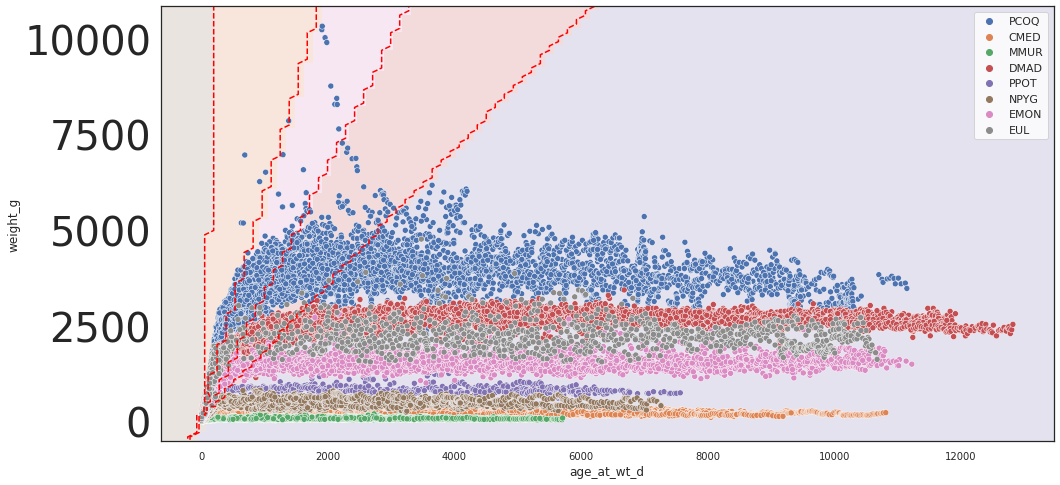

In [86]:
# à 2 features
#régression logistique pour prédire l'espèce mais précision médiocre à 2 features
df_reg2 = pd.DataFrame()
#df_reg['age_at_wt_d']=df['age_at_wt_d']
df_no_preg=df.loc[df['preg_status']=='NP']
df_taxo=pd.DataFrame()
df_taxo=df_taxo.append(df_no_preg.loc[df_no_preg['taxon']=="PCOQ"])
df_taxo=df_taxo.append(df_no_preg.loc[df_no_preg['taxon']=="CMED"])
df_taxo=df_taxo.append(df_no_preg.loc[df_no_preg['taxon']=="MMUR"])
df_taxo=df_taxo.append(df_no_preg.loc[df_no_preg['taxon']=="DMAD"])
df_taxo=df_taxo.append(df_no_preg.loc[df_no_preg['taxon']=="PPOT"])
df_taxo=df_taxo.append(df_no_preg.loc[df_no_preg['taxon']=="NPYG"])
df_taxo=df_taxo.append(df_no_preg.loc[df_no_preg['taxon']=="EMON"])
df_taxo=df_taxo.append(df_no_preg.loc[df_no_preg['taxon']=="EUL"])
cls = PCA(n_components=4) #Pourquoi 4?
df_pca=pd.DataFrame()
df_pca['birth_month'] = df_taxo['birth_month']
df_pca['age_at_death_y'] = df_taxo['age_at_death_y']
df_pca['weight_g'] = df_taxo['weight_g']
df_pca['age_at_wt_d'] = df_taxo['age_at_wt_d']
df_pca['taxon'] = df_taxo['taxon']

df_k=pd.DataFrame()
df_k=df_k.append(df_pca.loc[df_pca['taxon']=="PCOQ"])
df_k=df_k.append(df_pca.loc[df_pca['taxon']=="CMED"])
df_k=df_k.append(df_pca.loc[df_pca['taxon']=="MMUR"])
df_k=df_k.append(df_pca.loc[df_pca['taxon']=="DMAD"])
df_k=df_k.append(df_pca.loc[df_pca['taxon']=="PPOT"])
df_k=df_k.append(df_pca.loc[df_pca['taxon']=="NPYG"])
df_k=df_k.append(df_pca.loc[df_pca['taxon']=="EMON"])
df_k=df_k.append(df_pca.loc[df_pca['taxon']=="EUL"])

#df_reg2['age_at_death_y'] = df_k['age_at_death_y']
df_reg2['weight_g']=df_k['weight_g']
df_reg2['age_at_wt_d']=df_k['age_at_wt_d']
df_reg2['taxon']=df_k['taxon']
index_with_nan = df_reg2.index[df_reg2.isnull().any(axis=1)]
df_reg2.drop(index_with_nan, 0, inplace=True)


X2=df_reg2.iloc[:,:-1]
y2=df_reg2.iloc[:,-1]
x_train,x_test,y_train,y_test=train_test_split(X2,y2,test_size=0.2,random_state=42)
print("Taille des données de train :",x_train.shape)
print("Taille des données de test :",x_test.shape)
model3=LogisticRegression()
model3.fit(x_train,y_train)
predictions=model3.predict(x_test)
print(classification_report(y_test,predictions))
print("Cette régression a une précision de :",accuracy_score(y_test,predictions))
sns.scatterplot(x="age_at_wt_d", y="weight_g",hue="taxon",data=df_reg2)
add_decision_boundary(model3)
plt.show()

Taille des données de train : (64111, 2)
Taille des données de test : (16028, 2)
              precision    recall  f1-score   support

          IJ       0.50      0.03      0.05      3065
       adult       0.72      0.99      0.84     11504
 young_adult       0.00      0.00      0.00      1459

    accuracy                           0.72     16028
   macro avg       0.41      0.34      0.29     16028
weighted avg       0.61      0.72      0.61     16028

Cette régression a une précision de : 0.718243074619416


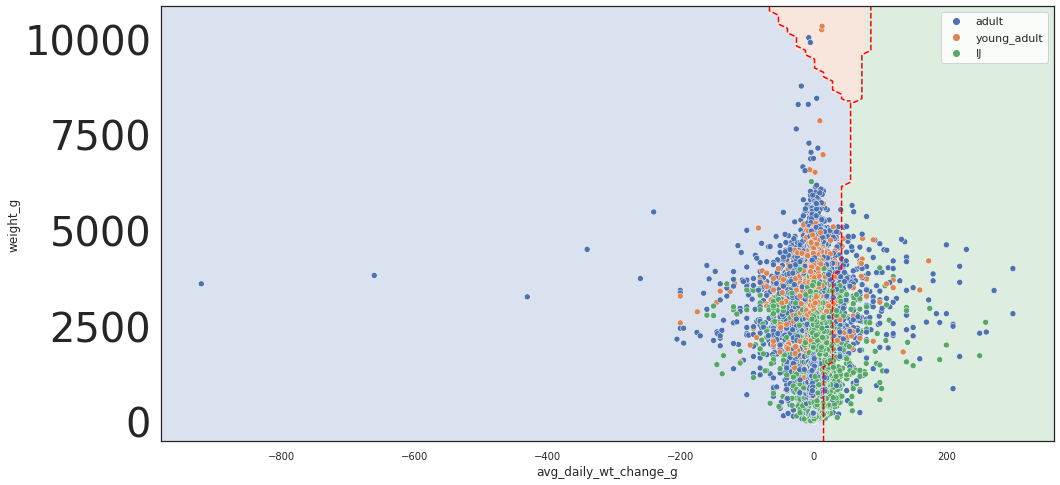

In [87]:
df_reg3 = pd.DataFrame()
df_reg3['avg_daily_wt_change_g']=df_reg['avg_daily_wt_change_g'] #on garde que 2 features
df_reg3['weight_g']=df_reg['weight_g']
df_reg3['age_category']=df_reg['age_category']
X=df_reg3.iloc[:,:-1]
y=df_reg3.iloc[:,-1]
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
print("Taille des données de train :",x_train.shape)
print("Taille des données de test :",x_test.shape)
model2=LogisticRegression()
model2.fit(x_train,y_train)
predictions=model2.predict(x_test)
print(classification_report(y_test,predictions))
print("Cette régression a une précision de :",accuracy_score(y_test,predictions))
sns.scatterplot(x="avg_daily_wt_change_g", y="weight_g",hue="age_category",data=df_reg3)
add_decision_boundary(model2)
plt.show()

In [88]:
#analyse discriminante

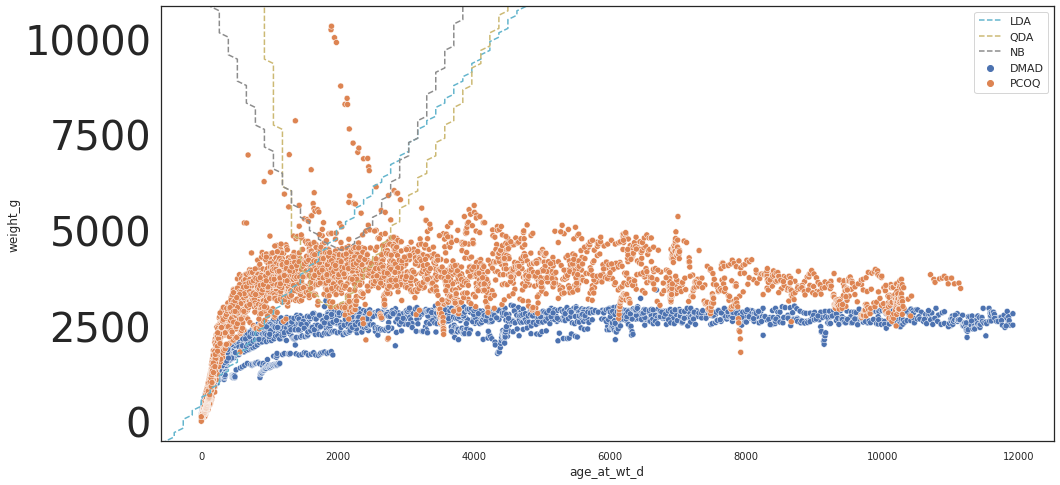

In [89]:
df_add=pd.DataFrame()
df_add=df_add.append(df_pca.loc[df_pca['taxon']=='DMAD'])
df_add=df_add.append(df_pca.loc[df_pca['taxon']=='PCOQ'])
index_with_nan = df_add.index[df_add.isnull().any(axis=1)]
df_add.drop(index_with_nan,0, inplace=True)
df_add = df_add.drop(columns = ["birth_month"])    # X = coordonnées des points
df_add = df_add.drop(columns = ["age_at_death_y"])    # X = coordonnées des points

#df_add.drop(df_add.birth_month)
#df_add.drop(df_add.age_at_death_y)

from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

def add_decision_boundaries(df_add, models):
  colors = sns.color_palette()
  for model, name in models:
    y = df_add.taxon                      # y = colonne étiquette
    X = df_add.drop(columns = ["taxon"])    # X = coordonnées des points
    cls = model()
    cls.fit(X,y)                    # on applique aux données le modèle pris par cls (LDA, QDA, NB)
    add_decision_boundary(cls, 
                          label = name,
                          color = colors.pop(),
                          region = False)
models = [
          (LinearDiscriminantAnalysis, "LDA"),
          (QuadraticDiscriminantAnalysis, "QDA"),
          (GaussianNB, "NB"),
         ]

sns.scatterplot(x= "age_at_wt_d", 
                y= "weight_g", 
                hue= "taxon",
                data = df_add)

add_decision_boundaries(df_add, models)

#pas adaptée à la forme des taxons

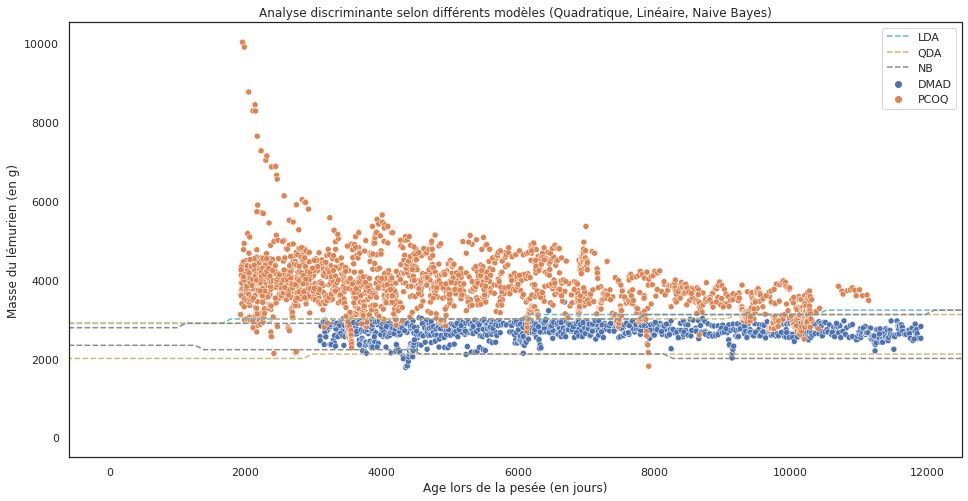

In [90]:
sns.set(rc={"figure.figsize":(16, 8)}) 
sns.set(style='white')
df_ad=pd.DataFrame()
df_ad['birth_month'] = df_taxo['birth_month']
df_ad['age_at_death_y'] = df_taxo['age_at_death_y']
df_ad['weight_g'] = df_taxo['weight_g']
df_ad['age_at_wt_d'] = df_taxo['age_at_wt_d']
df_ad['taxon'] = df_taxo['taxon']
df_ad['age_category'] = df_taxo['age_category']
df_adult=pd.DataFrame()
df_adult=df_adult.append(df_ad.loc[df_ad['age_category']=='adult'])
df_add=pd.DataFrame()
df_add=df_add.append(df_adult.loc[df_adult['taxon']=='DMAD'])
df_add=df_add.append(df_adult.loc[df_adult['taxon']=='PCOQ'])
del(df_add['age_category'])
index_with_nan = df_add.index[df_add.isnull().any(axis=1)]
df_add.drop(index_with_nan,0, inplace=True)
df_add = df_add.drop(columns = ["birth_month"])    # X = coordonnées des points
df_add = df_add.drop(columns = ["age_at_death_y"])    # X = coordonnées des points
age_at_wt_d = df_add.pop('age_at_wt_d') 
df_add.insert(0, 'age_at_wt_d', age_at_wt_d) 
#df_add.drop(df_add.birth_month)
#df_add.drop(df_add.age_at_death_y)

from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

def add_decision_boundaries(df_add, models):
  colors = sns.color_palette()
  for model, name in models:
    y = df_add.taxon                      # y = colonne étiquette
    X = df_add.drop(columns = ["taxon"])    # X = coordonnées des points
    cls = model()
    cls.fit(X,y)                    # on applique aux données le modèle pris par cls (LDA, QDA, NB)
    add_decision_boundary(cls, 
                          label = name,
                          color = colors.pop(),
                          region = False)
models = [
          (LinearDiscriminantAnalysis, "LDA"),
          (QuadraticDiscriminantAnalysis, "QDA"),
          (GaussianNB, "NB"),
         ]

sns.scatterplot(x= "age_at_wt_d", 
                y= "weight_g", 
                hue= "taxon",
                data = df_add)

add_decision_boundaries(df_add, models)
plt.ylabel("Masse du lémurien (en g)")
plt.xlabel("Age lors de la pesée (en jours)")
plt.title("Analyse discriminante selon différents modèles (Quadratique, Linéaire, Naive Bayes)")
plt.show()

#pas adaptée à la forme des taxons

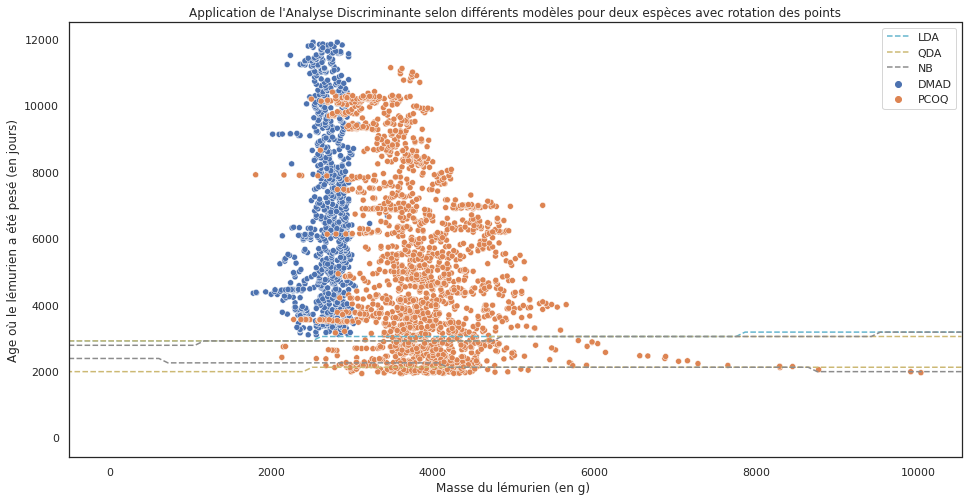

In [91]:
def add_decision_boundaries(df_add, models):
  colors = sns.color_palette()
  for model, name in models:
    y = df_add.taxon                      # y = colonne étiquette
    X = df_add.drop(columns = ["taxon"])    # X = coordonnées des points
    cls = model()
    cls.fit(X,y)                    # on applique aux données le modèle pris par cls (LDA, QDA, NB)
    add_decision_boundary(cls, 
                          label = name,
                          color = colors.pop(),
                          region = False)
models = [
          (LinearDiscriminantAnalysis, "LDA"),
          (QuadraticDiscriminantAnalysis, "QDA"),
          (GaussianNB, "NB"),
         ]

sns.scatterplot(x= "weight_g", 
                y= "age_at_wt_d", 
                hue= "taxon",
                data = df_add)
plt.ylabel("Age où le lémurien a été pesé (en jours)")
plt.xlabel("Masse du lémurien (en g) ")
plt.title("Application de l'Analyse Discriminante selon différents modèles pour deux espèces avec rotation des points")

add_decision_boundaries(df_add, models)

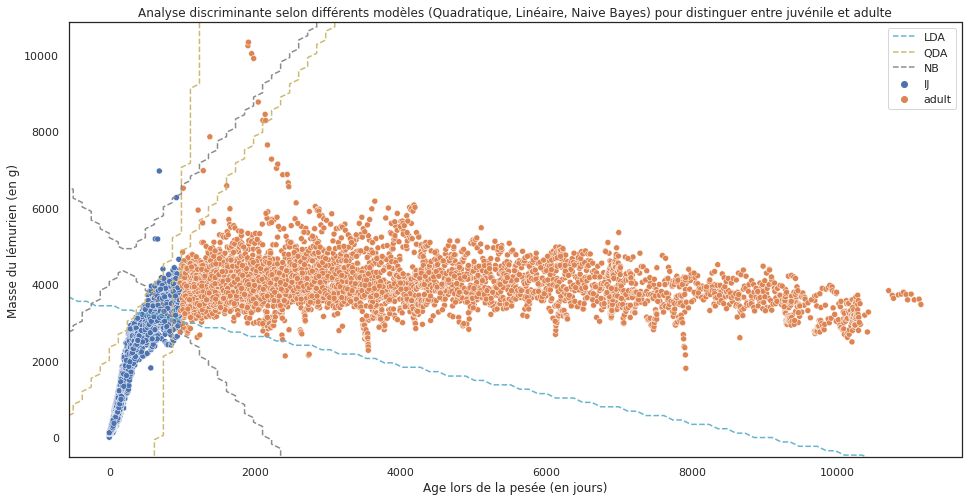

In [92]:

df_ada = pd.DataFrame()
df_ada['age_category']=df['age_category']
df_ada['taxon']=df['taxon']
df_ada['age_at_wt_d']=df['age_at_wt_d']
df_ada['weight_g']=df['weight_g']
df_add = pd.DataFrame()

df_add=df_add.append(df_ada.loc[df_ada['taxon']=='PCOQ'])
df_add = df_add.drop(columns = ["taxon"])    # X = coordonnées des points
age_category = df_add.pop('age_category') 
df_add.insert(2, 'age_category', age_category) 
df_add
list_cat=[]
for i in range(len(df_add)):
    if df_add.iloc[i]['age_category']=='IJ':
        list_cat.append('IJ')
    else:
        list_cat.append('adult')
age_category = df_add.pop('age_category') 

df_add['age_category']=list_cat
df_add

from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

def add_decision_boundaries(df_add, models):
  colors = sns.color_palette()
  for model, name in models:
    y = df_add.age_category                      # y = colonne étiquette
    X = df_add.drop(columns = ["age_category"])    # X = coordonnées des points
    cls = model()
    cls.fit(X,y)                    # on applique aux données le modèle pris par cls (LDA, QDA, NB)
    add_decision_boundary(cls, 
                          label = name,
                          color = colors.pop(),
                          region = False)
models = [
          (LinearDiscriminantAnalysis, "LDA"),
          (QuadraticDiscriminantAnalysis, "QDA"),
          (GaussianNB, "NB"),
         ]

sns.scatterplot(x= "age_at_wt_d", 
                y= "weight_g", 
                hue= "age_category",
                data = df_add)
plt.ylabel("Masse du lémurien (en g)")
plt.xlabel("Age lors de la pesée (en jours)")
plt.title("Analyse discriminante selon différents modèles (Quadratique, Linéaire, Naive Bayes) pour distinguer entre juvénile et adulte")

add_decision_boundaries(df_add, models)

In [93]:
df_add

age_at_wt_d  weight_g age_category
2862           1.0     107.0           IJ
2863          15.0     172.0           IJ
2864          21.0     206.0           IJ
2865          28.0     241.0           IJ
2866          40.0     317.0           IJ
...            ...       ...          ...
79852        363.0    2420.0           IJ
79853        378.0    2440.0           IJ
79854        387.0    2540.0           IJ
79855        392.0    2540.0           IJ
79984          0.0     125.0           IJ

[8996 rows x 3 columns]

In [94]:
def validation_errors(df, models):
  y = df_add.age_category
  X = df_add.drop(columns=["age_category"])
  for model, name in models:
    for acc in cross_val_score(model(), X, y, cv=10):
      yield name, acc


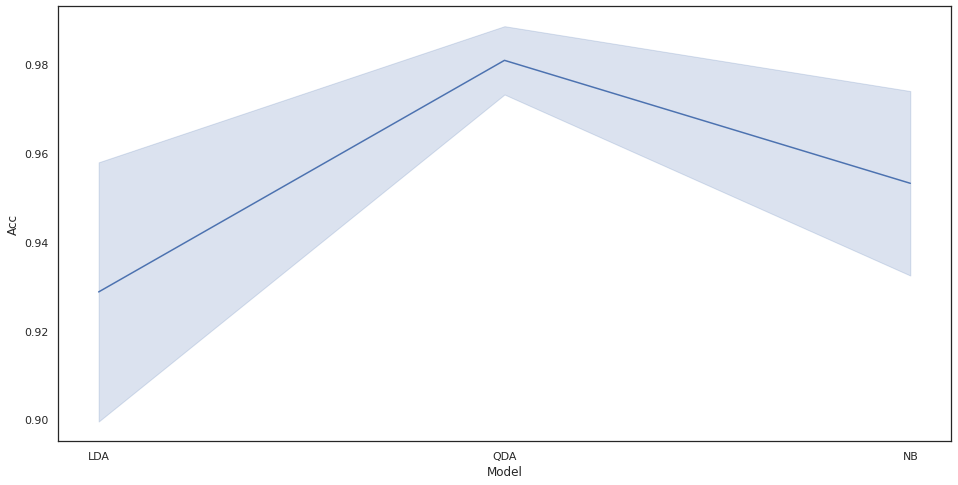

In [95]:
df_val = pd.DataFrame(validation_errors(df_add, models), columns=["Model", "Acc"])
sns.lineplot(x="Model", y="Acc", data=df_val, ci="sd")
plt.show() #ça confirme ce que l'on voit sur la figure, QDA est plus performant


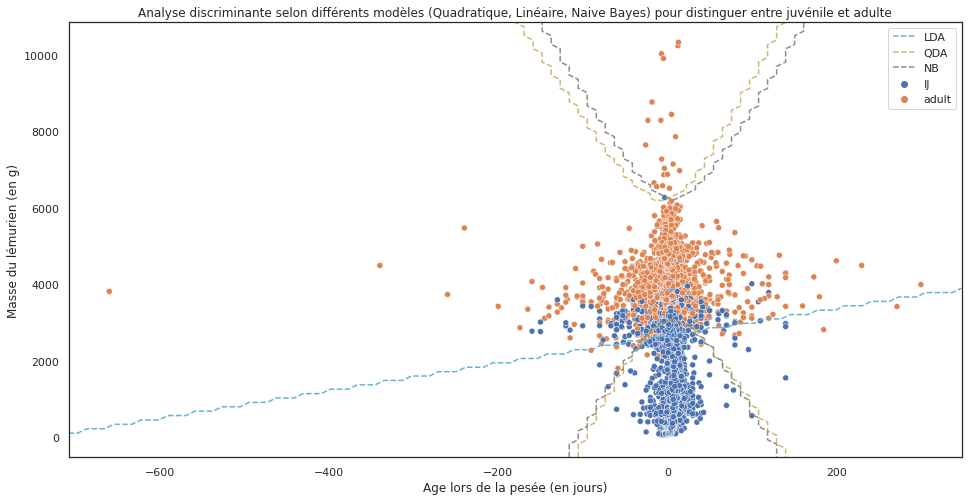

In [96]:

df_ada = pd.DataFrame()
df_ada['age_category']=df['age_category']
df_ada['taxon']=df['taxon']
df_ada['avg_daily_wt_change_g']=df['avg_daily_wt_change_g']
df_ada['weight_g']=df['weight_g']
df_add = pd.DataFrame()

df_add=df_add.append(df_ada.loc[df_ada['taxon']=='PCOQ'])
df_add = df_add.drop(columns = ["taxon"])    # X = coordonnées des points
age_category = df_add.pop('age_category') 
df_add.insert(2, 'age_category', age_category) 
index_with_nan = df_add.index[df_add.isnull().any(axis=1)]
df_add.drop(index_with_nan,0, inplace=True)
df_add
list_cat=[]
for i in range(len(df_add)):
    if df_add.iloc[i]['age_category']=='IJ':
        list_cat.append('IJ')
    else:
        list_cat.append('adult')
age_category = df_add.pop('age_category') 

df_add['age_category']=list_cat
df_add

from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

def add_decision_boundaries(df_add, models):
  colors = sns.color_palette()
  for model, name in models:
    y = df_add.age_category                      # y = colonne étiquette
    X = df_add.drop(columns = ["age_category"])    # X = coordonnées des points
    cls = model()
    cls.fit(X,y)                    # on applique aux données le modèle pris par cls (LDA, QDA, NB)
    add_decision_boundary(cls, 
                          label = name,
                          color = colors.pop(),
                          region = False)
models = [
          (LinearDiscriminantAnalysis, "LDA"),
          (QuadraticDiscriminantAnalysis, "QDA"),
          (GaussianNB, "NB"),
         ]

sns.scatterplot(x= "avg_daily_wt_change_g", 
                y= "weight_g", 
                hue= "age_category",
                data = df_add)
plt.ylabel("Masse du lémurien (en g)")
plt.xlabel("Age lors de la pesée (en jours)")
plt.title("Analyse discriminante selon différents modèles (Quadratique, Linéaire, Naive Bayes) pour distinguer entre juvénile et adulte")

add_decision_boundaries(df_add, models)

In [97]:
from sklearn.svm import SVC
df_ada = pd.DataFrame()
df_ada['age_category']=df['age_category']
df_ada['taxon']=df['taxon']
df_ada['avg_daily_wt_change_g']=df['avg_daily_wt_change_g']
df_ada['weight_g']=df['weight_g']
df_add = pd.DataFrame()

df_add=df_add.append(df_ada.loc[df_ada['taxon']=='PCOQ'])
df_add = df_add.drop(columns = ["taxon"])    # X = coordonnées des points
age_category = df_add.pop('age_category') 
df_add.insert(2, 'age_category', age_category) 
index_with_nan = df_add.index[df_add.isnull().any(axis=1)]
df_add.drop(index_with_nan,0, inplace=True)
df_add
list_cat=[]
for i in range(len(df_add)):
    if df_add.iloc[i]['age_category']=='IJ':
        list_cat.append('IJ')
    else:
        list_cat.append('adult')
age_category = df_add.pop('age_category') 

df_add['age_category']=list_cat
y = df_add.age_category                      # y = colonne étiquette
X = df_add.drop(columns = ["age_category"]) 

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

svclassifier = SVC(kernel='sigmoid')
svclassifier.fit(x_train, y_train)
y_pred = svclassifier.predict(x_test)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[635  99]
 [ 84 945]]
              precision    recall  f1-score   support

          IJ       0.88      0.87      0.87       734
       adult       0.91      0.92      0.91      1029

    accuracy                           0.90      1763
   macro avg       0.89      0.89      0.89      1763
weighted avg       0.90      0.90      0.90      1763



0.8627339761769711


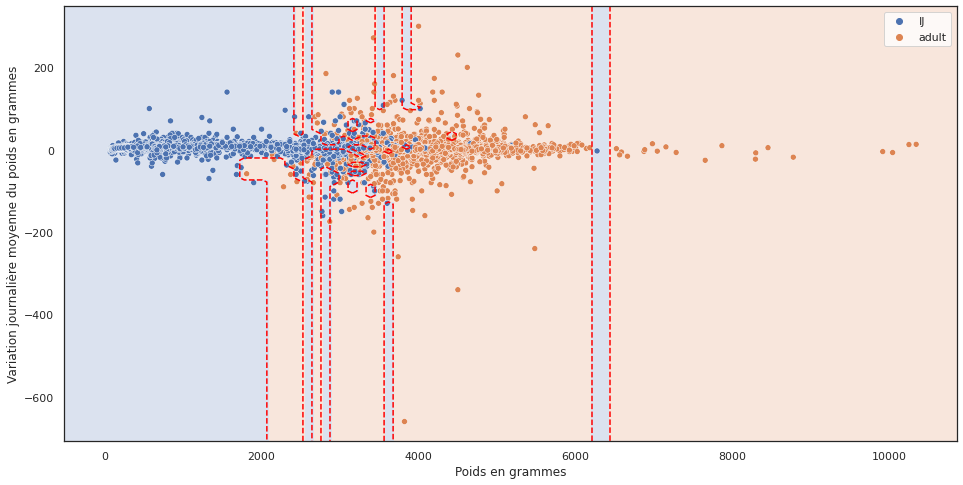

In [98]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.manifold import MDS
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.utils import check_X_y
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
df_ada = pd.DataFrame()
df_ada['age_category']=df['age_category']
df_ada['taxon']=df['taxon']
df_ada['age_at_wt_d']=df['age_at_wt_d']
df_ada['weight_g']=df['weight_g']
df_ada['avg_daily_wt_change_g']=df['avg_daily_wt_change_g']

df_add = pd.DataFrame()

df_add=df_add.append(df_ada.loc[df_ada['taxon']=='PCOQ'])
df_add = df_add.drop(columns = ["taxon"])    # X = coordonnées des points
age_category = df_add.pop('age_category') 
df_add.insert(2, 'age_category', age_category) 
df_add
list_cat=[]
for i in range(len(df_add)):
    if df_add.iloc[i]['age_category']=='IJ':
        list_cat.append('IJ')
    else:
        list_cat.append('adult')
age_category = df_add.pop('age_category') 

df_add['age_category']=list_cat
age_at_wt_d = df_add.pop('age_at_wt_d') 
index_with_nan = df_add.index[df_add.isnull().any(axis=1)]
df_add.drop(index_with_nan,0, inplace=True)

df_add
X = df_add.iloc[:,:-1]
y = df_add.iloc[:,-1]
cls = DecisionTreeClassifier()
model = cls.fit(X, y)
sns.scatterplot(x="weight_g", y="avg_daily_wt_change_g", data=df_add, hue="age_category")
add_decision_boundary(cls)
plt.xlabel("Poids en grammes")
plt.ylabel("Variation journalière moyenne du poids en grammes")
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
model2 = cls.fit(x_train, y_train)
pred_test = model2.predict(x_test)
# Compute accuracy based on test samples
acc = accuracy_score(y_test, pred_test)
print(acc)

1.0


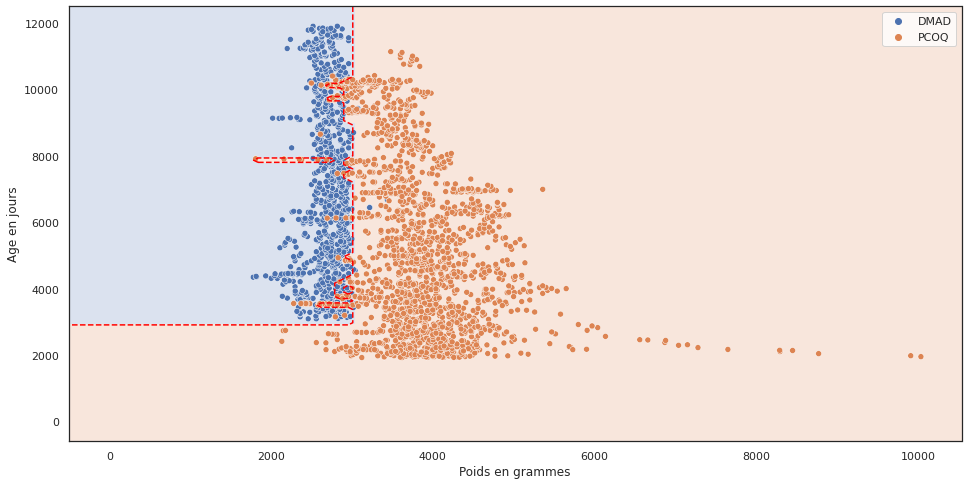

In [100]:
sns.set(rc={"figure.figsize":(16, 8)}) 
sns.set(style='white')
df_ad=pd.DataFrame()
df_ad['birth_month'] = df_taxo['birth_month']
df_ad['age_at_death_y'] = df_taxo['age_at_death_y']
df_ad['weight_g'] = df_taxo['weight_g']
df_ad['age_at_wt_d'] = df_taxo['age_at_wt_d']
df_ad['taxon'] = df_taxo['taxon']
df_ad['age_category'] = df_taxo['age_category']
df_adult=pd.DataFrame()
df_adult=df_adult.append(df_ad.loc[df_ad['age_category']=='adult'])
df_add=pd.DataFrame()
df_add=df_add.append(df_adult.loc[df_adult['taxon']=='DMAD'])
df_add=df_add.append(df_adult.loc[df_adult['taxon']=='PCOQ'])
del(df_add['age_category'])
index_with_nan = df_add.index[df_add.isnull().any(axis=1)]
df_add.drop(index_with_nan,0, inplace=True)
df_add = df_add.drop(columns = ["birth_month"])    # X = coordonnées des points
df_add = df_add.drop(columns = ["age_at_death_y"])    # X = coordonnées des points

#df_add.drop(df_add.birth_month)
#df_add.drop(df_add.age_at_death_y)

from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

def add_decision_boundaries(df_add, models):
  colors = sns.color_palette()
  for model, name in models:
    y = df_add.taxon                      # y = colonne étiquette
    X = df_add.drop(columns = ["taxon"])    # X = coordonnées des points
    cls = model()
    cls.fit(X,y)                    # on applique aux données le modèle pris par cls (LDA, QDA, NB)
    add_decision_boundary(cls, 
                          label = name,
                          color = colors.pop(),
                          region = False)
models = [
          (LinearDiscriminantAnalysis, "LDA"),
          (QuadraticDiscriminantAnalysis, "QDA"),
          (GaussianNB, "NB"),
         ]


X = df_add.iloc[:,:-1]
y = df_add.iloc[:,-1]
cls = DecisionTreeClassifier()
model = cls.fit(X, y)
sns.scatterplot(x="weight_g", y="age_at_wt_d", data=df_add, hue="taxon")
add_decision_boundary(cls)
plt.xlabel("Poids en grammes")
plt.ylabel("Age en jours")
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
pred_test = cls.predict(x_test)
# Compute accuracy based on test samples
acc = accuracy_score(y_test, pred_test)
print(acc)


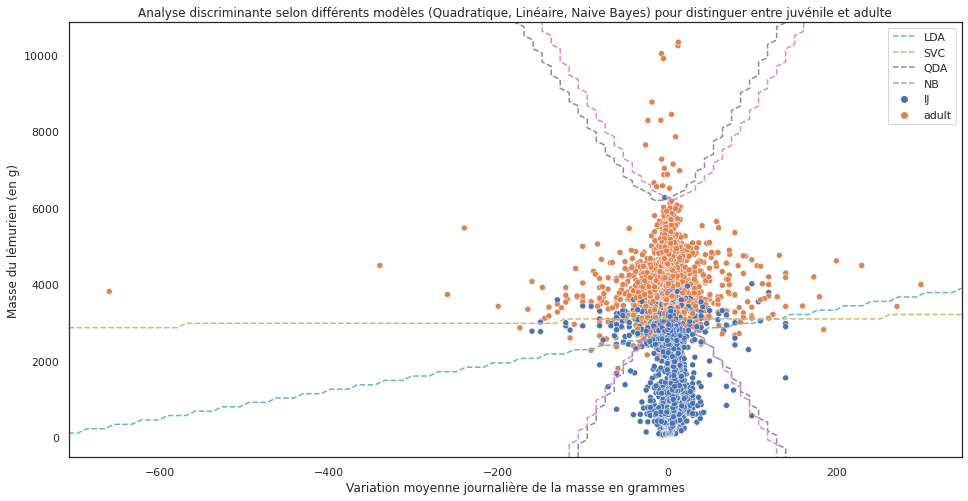

In [101]:

df_ada = pd.DataFrame()
df_ada['age_category']=df['age_category']
df_ada['taxon']=df['taxon']
df_ada['avg_daily_wt_change_g']=df['avg_daily_wt_change_g']
df_ada['weight_g']=df['weight_g']
df_add = pd.DataFrame()

df_add=df_add.append(df_ada.loc[df_ada['taxon']=='PCOQ'])
df_add = df_add.drop(columns = ["taxon"])    # X = coordonnées des points
age_category = df_add.pop('age_category') 
df_add.insert(2, 'age_category', age_category) 
index_with_nan = df_add.index[df_add.isnull().any(axis=1)]
df_add.drop(index_with_nan,0, inplace=True)
df_add
list_cat=[]
for i in range(len(df_add)):
    if df_add.iloc[i]['age_category']=='IJ':
        list_cat.append('IJ')
    else:
        list_cat.append('adult')
age_category = df_add.pop('age_category') 

df_add['age_category']=list_cat
df_add

from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

def add_decision_boundaries(df_add, models):
  colors = sns.color_palette()
  for model, name in models:
    y = df_add.age_category                      # y = colonne étiquette
    X = df_add.drop(columns = ["age_category"])    # X = coordonnées des points
    cls = model()
    cls.fit(X,y)                    # on applique aux données le modèle pris par cls (LDA, QDA, NB)
    add_decision_boundary(cls, 
                          label = name,
                          color = colors.pop(),
                          region = False)
models = [
          (LinearDiscriminantAnalysis, "LDA"),
          (SVC, "SVC"),
          (QuadraticDiscriminantAnalysis, "QDA"),
          (GaussianNB, "NB"),
         ]

sns.scatterplot(x= "avg_daily_wt_change_g", 
                y= "weight_g", 
                hue= "age_category",
                data = df_add)
plt.ylabel("Masse du lémurien (en g)")
plt.xlabel("Variation moyenne journalière de la masse en grammes")
plt.title("Analyse discriminante selon différents modèles (Quadratique, Linéaire, Naive Bayes) pour distinguer entre juvénile et adulte")

add_decision_boundaries(df_add, models)

In [102]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.manifold import MDS
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.utils import check_X_y
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

0.8633011911514464


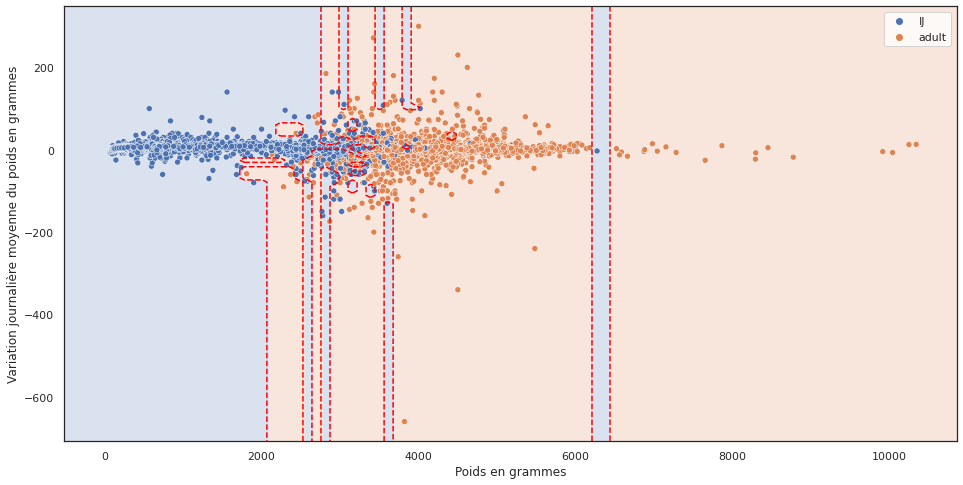

In [103]:
df_ada = pd.DataFrame()
df_ada['age_category']=df['age_category']
df_ada['taxon']=df['taxon']
df_ada['age_at_wt_d']=df['age_at_wt_d']
df_ada['weight_g']=df['weight_g']
df_ada['avg_daily_wt_change_g']=df['avg_daily_wt_change_g']

df_add = pd.DataFrame()

df_add=df_add.append(df_ada.loc[df_ada['taxon']=='PCOQ'])
df_add = df_add.drop(columns = ["taxon"])    # X = coordonnées des points
age_category = df_add.pop('age_category') 
df_add.insert(2, 'age_category', age_category) 
df_add
list_cat=[]
for i in range(len(df_add)):
    if df_add.iloc[i]['age_category']=='IJ':
        list_cat.append('IJ')
    else:
        list_cat.append('adult')
age_category = df_add.pop('age_category') 

df_add['age_category']=list_cat
age_at_wt_d = df_add.pop('age_at_wt_d') 
index_with_nan = df_add.index[df_add.isnull().any(axis=1)]
df_add.drop(index_with_nan,0, inplace=True)

df_add
X = df_add.iloc[:,:-1]
y = df_add.iloc[:,-1]
cls = DecisionTreeClassifier()
model = cls.fit(X, y)
sns.scatterplot(x="weight_g", y="avg_daily_wt_change_g", data=df_add, hue="age_category")
add_decision_boundary(cls)
plt.xlabel("Poids en grammes")
plt.ylabel("Variation journalière moyenne du poids en grammes")
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
model2 = cls.fit(x_train, y_train)
pred_test = model2.predict(x_test)
# Compute accuracy based on test samples
acc = accuracy_score(y_test, pred_test)
print(acc)

0.9571183533447685


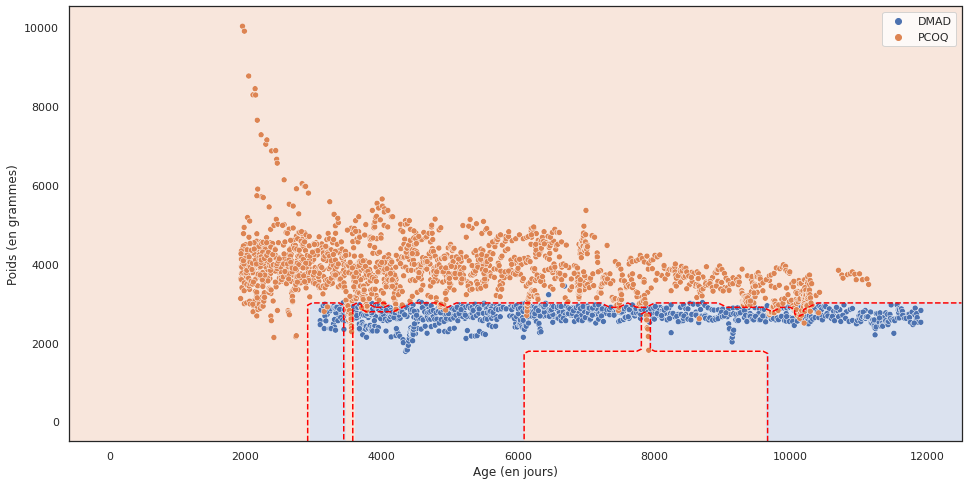

In [104]:
sns.set(rc={"figure.figsize":(16, 8)}) 
sns.set(style='white')
df_ad=pd.DataFrame()
df_ad['birth_month'] = df_taxo['birth_month']
df_ad['age_at_death_y'] = df_taxo['age_at_death_y']
df_ad['weight_g'] = df_taxo['weight_g']
df_ad['age_at_wt_d'] = df_taxo['age_at_wt_d']
df_ad['taxon'] = df_taxo['taxon']
df_ad['age_category'] = df_taxo['age_category']
df_adult=pd.DataFrame()
df_adult=df_adult.append(df_ad.loc[df_ad['age_category']=='adult'])
df_add=pd.DataFrame()
df_add=df_add.append(df_adult.loc[df_adult['taxon']=='DMAD'])
df_add=df_add.append(df_adult.loc[df_adult['taxon']=='PCOQ'])
del(df_add['age_category'])
index_with_nan = df_add.index[df_add.isnull().any(axis=1)]
df_add.drop(index_with_nan,0, inplace=True)
df_add = df_add.drop(columns = ["birth_month"])    # X = coordonnées des points
df_add = df_add.drop(columns = ["age_at_death_y"])    # X = coordonnées des points
age_at_wt_d = df_add.pop('age_at_wt_d') 
df_add.insert(0, 'age_at_wt_d', age_at_wt_d) 
#df_add.drop(df_add.birth_month)
#df_add.drop(df_add.age_at_death_y)

from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

def add_decision_boundaries(df_add, models):
  colors = sns.color_palette()
  for model, name in models:
    y = df_add.taxon                      # y = colonne étiquette
    X = df_add.drop(columns = ["taxon"])    # X = coordonnées des points
    cls = model()
    cls.fit(X,y)                    # on applique aux données le modèle pris par cls (LDA, QDA, NB)
    add_decision_boundary(cls, 
                          label = name,
                          color = colors.pop(),
                          region = False)
models = [
          (LinearDiscriminantAnalysis, "LDA"),
          (QuadraticDiscriminantAnalysis, "QDA"),
          (GaussianNB, "NB"),
         ]


X = df_add.iloc[:,:-1]
y = df_add.iloc[:,-1]
cls = DecisionTreeClassifier()
model = cls.fit(X, y)
sns.scatterplot(x="age_at_wt_d", y="weight_g", data=df_add, hue="taxon")
add_decision_boundary(cls)
plt.ylabel("Poids (en grammes)")
plt.xlabel("Age (en jours)")
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
model2 = cls.fit(x_train, y_train)
pred_test = model2.predict(x_test)
# Compute accuracy based on test samples
acc = accuracy_score(y_test, pred_test)
print(acc)
